In [18]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from EOF import EOF
import datetime 

In [19]:
# file  = "HSt42_20_3000day/RH80_PR20_3000day_startfrom_0day_final.dat"
# ds = h5py.File(file, "r")
# print(ds.keys())
# dycore = Dycore(file)
# u = dycore.getVar("grid_u_c_xyzt")
# # print(u.shape)

In [20]:
from Dycore import Dycore
def read_all_var(pr_start, pr_to, pr_leap, start, end, internal_day, total_file):
    total_pr = int((pr_to - pr_start) / pr_leap)
    total_day = int(total_file * internal_day)
    
    qv_shape = (total_pr, total_day, 20, 64, 128)
    qv_diff_shape = (total_pr, total_day, 20, 64, 128)
    u_shape = (total_pr, total_day, 20, 64, 128)
    v_shape = (total_pr, total_day, 20, 64, 128)
    t_shape = (total_pr, total_day, 20, 64, 128)
    p_shape = (total_pr, total_day, 20, 64, 128)
    ps_shape = (total_pr, total_day, 20, 64, 128)
    p_half_shape = (total_pr, total_day, 21, 64, 128)
    
    qv = np.zeros(qv_shape)
    qv_diff = np.zeros(qv_diff_shape)
    u = np.zeros(u_shape)
    v = np.zeros(v_shape)
    t = np.zeros(t_shape)
    p = np.zeros(p_shape)
    ps = np.zeros(ps_shape)
    p_half = np.zeros(p_half_shape)
    
    a = 0
    for pr in range(pr_start, pr_to, pr_leap):
        k = 0
        for day in range(start, end, internal_day):
            print(day)
            if pr == 8 and day == 7500:
                print("PR=8, 7500day file miss")
            else:
                file = f"HSt42_{pr}/RH80_PR{pr}_20000day_startfrom_{day}day_final.dat"
                dycore = Dycore(file)
                
                start_index = k * 100
                end_index = (k + 1) * 100
                
                qv[a, start_index:end_index, :, :, :] = dycore.qv
                qv_diff[a, start_index:end_index, :, :, :] = dycore.qv_diff
                u[a, start_index:end_index, :, :, :] = dycore.u
                v[a, start_index:end_index, :, :, :] = dycore.v
                t[a, start_index:end_index, :, :, :] = dycore.t
                ps[a, start_index:end_index, :, :, :] = dycore.ps
                p[a, start_index:end_index, :, :, :] = dycore.p
                p_half[a, start_index:end_index, :, :, :] = dycore.p_half
                k += 1
        a += 1
    return qv, qv_diff, u, v, t, p, ps, p_half

In [26]:
pr_start = 50
pr_leap = 10
pr_to = 60
total_pr = (pr_to - pr_start) / pr_leap

start = 0
end   = 5200
internal_day = 100
total_day = int((end -start)/internal_day) * internal_day

total_file = int((end - start) / internal_day)
# file  = "HSt42_0/RH80_PR0_1600day_startfrom_0day_final.dat"

# dycore = Dycore(file)
qv, qv_diff, u, v, t, p, ps, p_half = read_all_var(pr_start, pr_to, pr_leap, start , end, internal_day, total_file)  # 
print("done")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
done


In [5]:
qv_diff.shape

(1, 7600, 20, 64, 128)

In [28]:
# put all pr 0-50 500 - 10000day all var into one file 
# with h5py.File('500_10000day_all_var.h5','w') as f :
#     f.create_dataset('u',data=u)
#     f.create_dataset('v',data=v)
#     f.create_dataset('qv',data=qv)
#     f.create_dataset('qv_diff',data=qv_diff)
#     f.create_dataset('p',data=p)
#     f.create_dataset('ps',data=ps)
#     f.create_dataset('t',data=t)
#     f.create_dataset('p_half',data=p_half)
    
    
    
    

In [8]:
### read variables ###
u_file       = h5py.File("PR0_50_0_10000day_u.h5", "r")
w_file       = h5py.File("PR0_50_0_10000day_w.h5", "r")

qv_file      = h5py.File("PR0_50_0_10000day_qv.h5", "r")
qv_diff_file = h5py.File("PR0_50_0_10000day_qv_diff.h5", "r")
p_file       = h5py.File("PR0_50_0_10000day_p.h5", "r")
ps_file      = h5py.File("PR0_50_0_10000day_ps.h5", "r")
p_half_file  = h5py.File("PR0_50_0_10000day_p_half.h5", "r")

z_full_file  = h5py.File("PR0_50_0_10000day_z_full.h5", "r")



print("---1---")
u_origin       = np.asarray(u_file["u"][:,int(start):end,:,:,:])
print("---2---")
qv_diff_origin = np.asarray(qv_diff_file["qv_diff"][:,int(start):end,:,:,:])
print("---3---")
p_origin       = np.asarray(p_file["p"][:,int(start):end,:,:,:])
print("---4---")
ps_origin      = np.asarray(ps_file["ps"][:,int(start):end,:,:,:])
print("---5---")
p_half_origin  = np.asarray(p_half_file["p_half"][:,int(start):end,:,:,:])
print("---6---")

w_origin       = np.asarray(w_file["w"][:,int(start):end,:,:,:])
z_full_origin       = np.asarray(z_full_file["z_full"][:,int(start):end,:,:,:])


print("done")

u_file.close()
qv_file.close()
qv_diff_file.close()
p_file.close()
ps_file.close()
p_half_file.close()
w_file.close()
z_full_file.close()





---1---
---2---
---3---
---4---
---5---
---6---
done


In [13]:
v_file       = h5py.File("PR0_50_0_10000day_v.h5", "r")
v_origin       = np.asarray(v_file["v"][:,int(start):end,:,:,:])
t_file       = h5py.File("PR0_50_0_10000day_t.h5", "r")
t_origin       = np.asarray(t_file["t"][:,int(start):end,:,:,:])

v_file.close()
t_file.close()

print("done")

done


In [ ]:
qv_diff.shape

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

y = np.random.rand(20)

plt.hist(y)
plt.show()

In [ ]:
random.sample(sorted(y), 2, counts=None)

In [ ]:
mean_distribution = np.zeros((10000,))
for i in range(10000):
    mean_distribution[i] = np.mean(random.sample(sorted(y), 10, counts=None))


plt.figure()
plt.hist(mean_distribution[:,])

In [ ]:
### check ####
qv_diff_mean = np.zeros((6,qv_diff.shape[1]))
for i in range(6):
    qv_diff_mean[i] = np.nanmean(qv_diff[i], axis=(1,2,3))
print("---1---")
#################################################################################
qv_mean = np.zeros((6,qv_diff.shape[1]))
for i in range(6):
    qv_mean[i] = np.nanmean(qv[i], axis=(1,2,3))
print("---2---")
#################################################################################
u_mean = np.zeros((6,qv_diff.shape[1]))
for i in range(6):
    u_mean[i] = np.nanmean(u[i], axis=(1,2,3))
print("---3---")

In [ ]:
qv_diff_mean.shape

In [ ]:
xxx = np.arange(start,end,1)
slope_qv_diff = np.zeros(6)
intercept_qv_diff = np.zeros(6)

for i in range(6):
    slope_qv_diff[i], intercept_qv_diff[i] = np.polyfit(xxx,qv_diff_mean[i], 1)
print("---1---")
#################################################################################
slope_qv = np.zeros(6)
intercept_qv = np.zeros(6)

for i in range(6):
    slope_qv[i], intercept_qv[i] = np.polyfit(xxx,qv_mean[i], 1)
print("---2---")
#################################################################################
slope_u = np.zeros(6)
intercept_u = np.zeros(6)

for i in range(6):
    slope_u[i], intercept_u[i] = np.polyfit(xxx,u_mean[i], 1)
print("---3---")

In [ ]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=14)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [ ]:
fig, ax = plt.subplots(3,6, figsize=(18,9), dpi=100.)
grid = plt.GridSpec(3, 6)
create_subtitle(fig, grid[0, ::], 'qv_diff')
create_subtitle(fig, grid[1, ::], 'qv')
create_subtitle(fig, grid[2, ::], 'u')

print("============= qv_diff ===============")

for i in range(6):
    ax[0,i].scatter(xxx[::100], qv_diff_mean[i,::100])
    ax[0,i].plot(xxx, (slope_qv_diff[i]*xxx + intercept_qv_diff[i]), lw=2, color="r")
    print(f"PR={i*10}  slope:", slope_qv_diff[i])
    ax[0,i].set_title(f"PR={i*10}", fontsize=10)
    # ax[0,i].xticks(xxx)
    # ax[0,i].set_xticks(xxx)
    
    # ax[0,i].set_xticklabels(np.arange(500,10000,1000))
    
    ax[0,i].set_xlabel("Day")
print("=============    qv      ===============")


# ax[0,3].set_title("qv_diff", fontsize=14)


for i in range(6):
    ax[1,i].scatter(xxx[::100], qv_mean[i,::100])
    ax[1,i].plot(xxx, (slope_qv[i]*xxx + intercept_qv[i]), lw=2, color="r")
    print(f"PR={i*10}  slope:", slope_qv[i])
    ax[1,i].set_title(f"PR={i*10}", fontsize=10)
    ax[1,i].set_xlabel("Day")
print("=============    u      ===============")




for i in range(6):
    ax[2,i].scatter(xxx[::100], u_mean[i,::100])
    ax[2,i].plot(xxx, (slope_u[i]*xxx + intercept_u[i]), lw=2, color="r")
    print(f"PR={i*10}  slope:", slope_u[i])
    ax[2,i].set_title(f"PR={i*10}", fontsize=10)
    ax[2,i].set_xlabel("Day")
    # ax[2,i].set_ylim([4,8])
    






plt.tight_layout()
# plt.savefig("Check_variables_stability.png", dpi=600., bbox_inches='tight')
    # ax[i].set_xtick(fontsize=3)

In [ ]:
# np.savez_compressed('500_10000day_u.npz', all_u=u)
# np.savez_compressed('500_10000day_v.npz', all_v=v)

In [ ]:
# np.savez_compressed('500_10000day_qv.npz', all_qv=qv)
# np.savez_compressed('500_10000day_qv_diff.npz', all_qv_diff=qv_diff)
# np.savez_compressed('500_10000day_t.npz', all_t=t)
# np.savez_compressed('500_10000day_p.npz', all_p=p)
# np.savez_compressed('500_10000day_ps.npz', all_ps=ps)
# np.savez_compressed('500_10000day_p_half.npz', all_p_half=p_half)







In [602]:
def Cal_EOF_PC(EOF, input, aa, total_pr):
    yn = np.linspace(0,90,np.shape(input)[2])
    cyyn = np.cos(np.deg2rad(yn))
    # (1100, 20, 32)
    input_w = np.zeros(input.shape)
    for i in range(np.shape(input)[0]): 
        for j in range(np.shape(input)[1]):
                input_w[i,j,:] = input[i,j,:] * (cyyn[:])**0.5
    # input: (day, 20,32)
    day  = np.shape(input_w)[0]
    dim1 = np.shape(input_w)[1]
    dim2 = np.shape(input_w)[2]

    # EOF1_all = np.zeros(((total_pr, dim1, dim2)))
    # PC1_all  = np.zeros((total_pr , day))
    
    # EOF2_all = np.zeros(((total_pr, dim1, dim2)))
    # PC2_all  = np.zeros((total_pr , day))
    
    input_reshape = np.reshape(input_w, (day,dim1*dim2))
    judge = day - dim1*dim2
    if judge > 0:
        n_component = dim1*dim2
    else:
        n_component = day
    print("n_component:",n_component)
    single_EOF = EOF((input_reshape,), n_components=n_component, field="1D")
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs    = single_EOF.PC[0,:]
    PC2s   = single_EOF.PC[1,:]
    
    EOFs   = single_EOF.EOF[0,:]
    EOF2s  = single_EOF.EOF[1,:]
    
    PCs_std = PCs.std()
    PCs     = PCs / PCs_std

    PC2s_std = PC2s.std()
    PC2s     = PC2s / PC2s_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std

    EOF2s_std  = EOF2s.std()
    EOF2s      = EOF2s * PC2s_std
    
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy  = np.reshape(EOFs,  (dim1,dim2))
    EOF2s_zy = np.reshape(EOF2s, (dim1,dim2))
    
    # EOF1_all[aa,:,:] = EOFs_zy
    # EOF2_all[aa,:,:] = EOF2s_zy

    # PC1_all[aa,:] = PCs
    # PC2_all[aa,:] = PC2s
    print(aa)
    return EOFs_zy, PCs, EOF2s_zy, PC2s

In [51]:
qv_diff.max()

7.686292237763554e-07

0


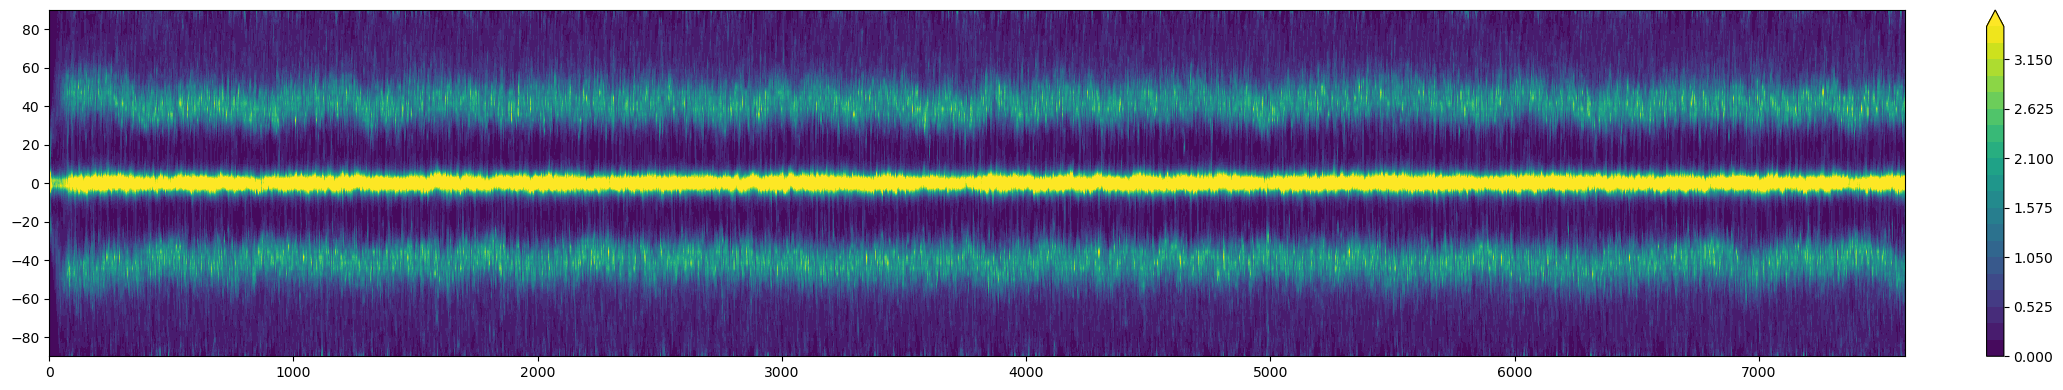

done


In [17]:
# print(p_half.shape)
from Dycore import Dycore
file  = "HSt42_0_20000day/RH80_PR0_20000day_startfrom_0day_final.dat"

dycore = Dycore(file)
### fig
y = np.linspace(-90,90,64)
total_day = int(total_file*internal_day)
time = np.linspace(start, end, total_day)


yy, tt = np.meshgrid(y,time)
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,4))

do_check_qv = True
do_check_KE = False
do_check_t  = False

test = np.zeros(((int((pr_to - pr_start)/pr_leap), tt.shape[0], tt.shape[1])))
a = 0           
for pr in range(pr_start, pr_to, pr_leap):
    if do_check_qv:
        print(a)
        Prec_new, Prec_all   = dycore.cal_pre(qv_diff[a], p_half[a])
        CS = plt.contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,3.5,21), extend="max")    
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04)
        # ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
        # ax[a].set_xlabel("time")
        # ax[a].set_ylabel("latutide")
        test[a] = Prec_new
        a += 1
    if do_check_KE:
        get_KE = dycore.cal_KE(u_origin[a], v_origin[a])   
        CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(60,1200,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
    if do_check_t:
        t_mean = np.nanmean(t[a,:,:,:,:], axis=(1,3))
        CS = ax[a].contourf(tt, yy, t_mean,levels=21, extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_title(f"Temperature [K], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
        
if do_check_qv:
    fig.tight_layout()
    # plt.savefig("check_qv_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_KE:
    fig.tight_layout()
    # plt.savefig("check_KE_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()
if do_check_t:
    fig.tight_layout()
    # plt.savefig("check_T_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()

print("done")

In [57]:
test = np.zeros((6, 7600))
a = 0
for i in range(1):
    test[a] = np.sum(qv_diff[a], axis=(1,2,3))
    a += 1

In [65]:
test.shape

(1, 7600, 64)

In [63]:
check = (test[-1] - test[0])
test.shape

(6, 7600)

TypeError: Input z must be 2D, not 1D

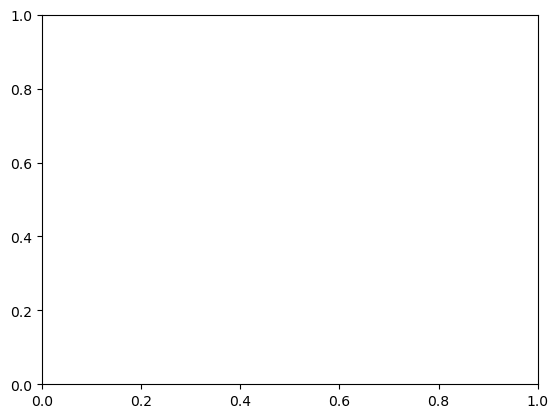

In [62]:
plt.figure()
CS = plt.contourf(tt, yy, check * 86400,levels=np.linspace(0,1,21), extend="both", cmap = "RdBu")
plt.colorbar(CS)
print((check* 86400).max())
print((check* 86400).min())
plt.title("Precipitation pr50 - pr0")

In [41]:
qv_diff.shape

(1, 7600, 20, 64, 128)

Text(0.5, 1.0, 'last 100 day file qv_diff')

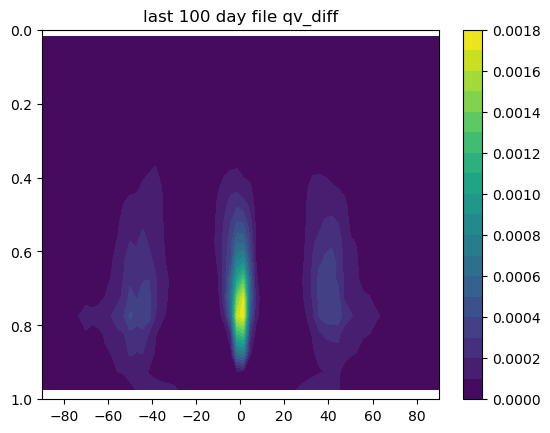

In [40]:
qv_diff2 = qv_diff[0]# dycore.qv_diff
# print(np.nanmax(qv_diff))
# print(np.nanmin(qv_diff))

qv_diff_mean = np.nanmean(qv_diff2[-10:,:,:,:], axis=(0,3))
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

plt.figure()
CS = plt.contourf(yy,sigma_mean2, qv_diff_mean*86400 , levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("last 100 day file qv_diff")

(1.0, 0.0)

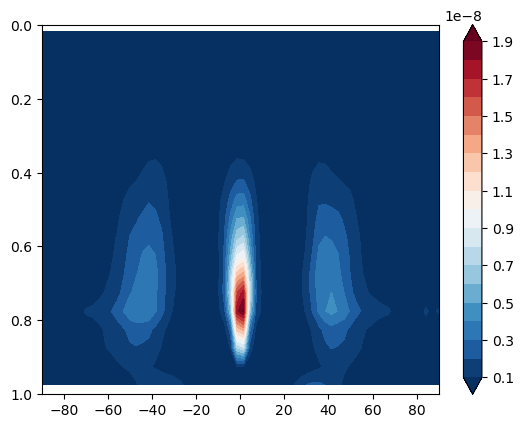

In [55]:
t_mean = np.nanmean(qv_diff[0,-100:], axis=(0,3))
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
plt.figure()
CS = plt.contourf(yy,sigma_mean2, t_mean, levels=21, cmap="RdBu_r", extend="both") 
plt.colorbar(CS)
plt.ylim([1,0])

In [ ]:
a = -1
Vzm = np.nanmean(v[a], axis=3)
Uzm = np.nanmean(u[a], axis=3)

In [ ]:
Vza     = np.zeros(u.shape)
Uza     = np.zeros(u.shape)

for i in range(0,128):
    Vza[a,:,:,:,i]     = v[a,:,:,:,i] - Vzm
    Uza[a,:,:,:,i]     = u[a,:,:,:,i] - Uzm

In [ ]:
M = Uza * Vza
Mzm = np.nanmean(M, axis=(4))


In [ ]:
for i in range(Mzm.shape[1]):
    for j in range(Mzm.shape[2]):
        Mzm[a,i,j,:] = cy[:]**0.5 * Mzm[a,i,j,:]

In [ ]:
plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(Mzm[a], axis=0), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("500-1600day $\overline{u'v'}$")

In [ ]:
plt.figure()
plt.contourf(yy, sigma_mean2,  0.5*np.nanmean(Uza[a]**2 + Vza[a]**2, axis=(0,3)), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("500-1600day EKE$")

In [ ]:
dmdy = np.zeros(((total_day,20,64)))
r = 6371e3
for i in range(1,64-1):
    dmdy[:,:,i] = -(Mzm[a,:,:,i+1] - Mzm[a,:,:,i-1]) / (r * (yd[i+1] - yd[i-1]))
dmdy[:,:, 0] = -(Mzm[a,:,:, 1] - Mzm[a,:,:, 0]) / (r*(yd[ 1] - yd[ 0]))
dmdy[:,:,-1] = -(Mzm[a,:,:,-1] - Mzm[a,:,:,-2]) / (r*(yd[-1] - yd[-2]))

In [ ]:
plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(dmdy, axis=0), levels= np.linspace(-3.2E-5,4E-5,11), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("500-1600day $d\overline{u'v'} / dy$")

# Calculate EOF of u, then plot y-z 

In [606]:
from EOF import EOF

In [607]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)
cy[32:]
u.shape

(2, 10000, 20, 64, 128)

In [608]:
cy.shape

(64,)

(10000, 640)
0
(10000, 640)
1


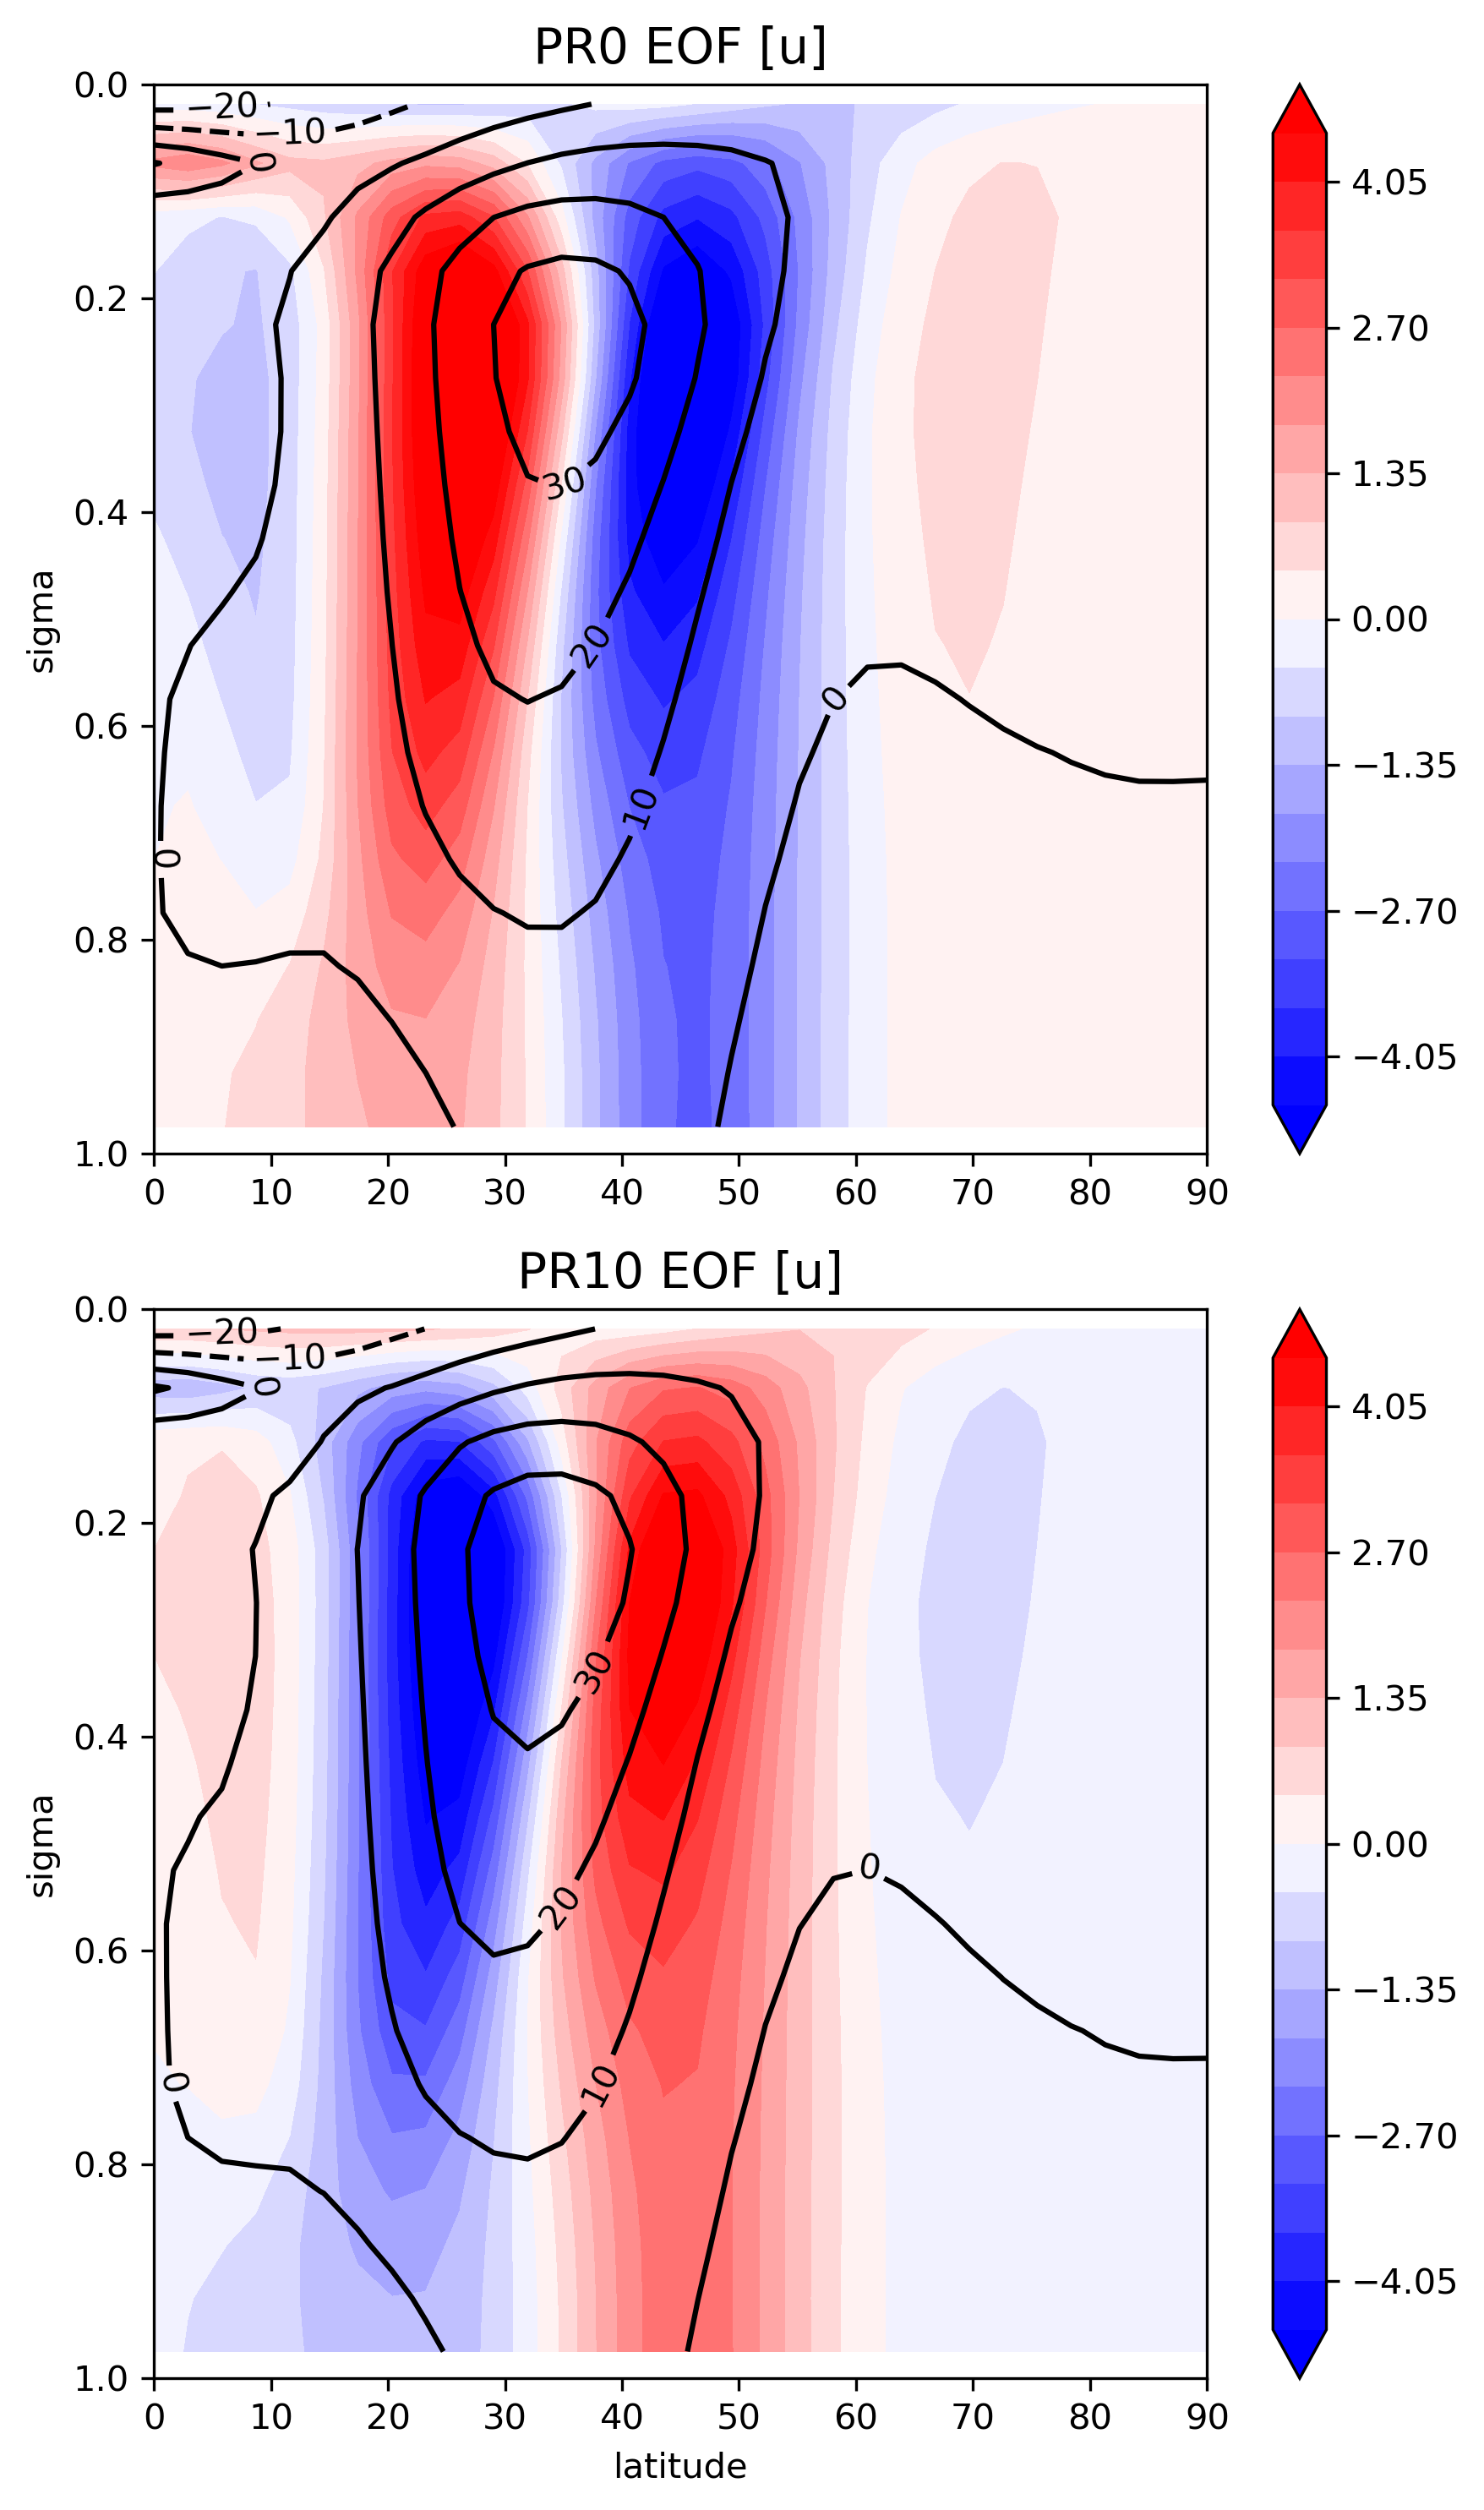

In [609]:
# fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(6,10), dpi=300.)
fig,ax   = plt.subplots(2,figsize=(6,10), dpi=300.)


check_days_length = int(end - start)

EOF1_all = np.zeros(((int(total_pr), 20, 32)))
EOF2_all = np.zeros(((int(total_pr), 20, 32)))

PC1_all = np.zeros((int(total_pr), total_day))
PC2_all = np.zeros((int(total_pr), total_day))


judge = total_day - (u.shape[2] * u.shape[3])/2
if judge >0:
    n_component = int((u.shape[2] * u.shape[3])/2)
else:
    n_component = total_day
explain_all = np.zeros((int(total_pr), n_component))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    sigma_mean      = np.nanmean(p[a,-check_days_length:,:,:,:]/ps[a,-check_days_length:,:,:,:], axis=(0,3))
    sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
    y               = np.linspace(-90,90,64)
    yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

    y_nhalf = np.linspace(0,90,32)
    yy_nhalf, sigma_mean2_nhalf = np.meshgrid(y_nhalf,sigma_onlyz)

    u_nhalf = u[:,:,:,32:,:] 
    u_nhalf_w = np.zeros(u_nhalf.shape)
    # for i in range(np.shape(u)[1]): 
    #     for j in range(np.shape(u)[2]):
    #         for k in range(np.shape(u)[4]):
    #             u_nhalf_w[a,i,j,:,k] = u_nhalf[a,i,j,:,k] * (cy[32:])**0.5
    for i in range(32): # cy[0] and [-1] are np.nan
        u_nhalf_w[a,:,:,i,:] = u_nhalf[a,:,:,i,:] * (cy[i+32])**0.5
    u_zy = np.nanmean(u_nhalf_w[a,:,:,:,:], axis=(3))
    u_zy_reshape = np.reshape(u_zy, (np.shape(u_zy)[0], 20*32))
    print(u_zy_reshape.shape)
    # Step 2: do EOF of u

        
    single_EOF = EOF((u_zy_reshape,), n_components=n_component, field="1D")
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs    = single_EOF.PC[0,:]
    PC2s   = single_EOF.PC[1,:]
    
    EOFs   = single_EOF.EOF[0,:]
    EOF2s  = single_EOF.EOF[1,:]
    
    PCs_std = PCs.std()
    PCs     = PCs / PCs_std

    PC2s_std = PC2s.std()
    PC2s     = PC2s / PC2s_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std

    EOF2s_std  = EOF2s.std()
    EOF2s      = EOF2s * PC2s_std
    
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy  = np.reshape(EOFs, (20,32))
    EOF2s_zy = np.reshape(EOF2s, (20,32))
    
    EOF1_all[a,:,:] = EOFs_zy
    EOF2_all[a,:,:] = EOF2s_zy

    PC1_all[a,:] = PCs
    PC2_all[a,:] = PC2s
    
    # Step 5: plot
    CS = ax[a].contourf(yy_nhalf, sigma_mean2_nhalf, EOFs_zy, levels=np.linspace(-4.5,4.5,21), cmap="bwr", extend="both")
    fig.colorbar(CS, ax=ax[a], extend="both")
    ax[a].set_ylim([1,0])
    ax[a].set_title(f"PR{pr} EOF [u]", fontsize=14)
    ax[a].set_ylabel("sigma")
    ax[-1].set_xlabel("latitude")

    CT = ax[a].contour(yy_nhalf, sigma_mean2_nhalf, np.nanmean(u[a,:,:,32:,:], axis=(0,3)), colors='k', levels=np.arange(-20,50,10))
    plt.clabel(CT)
    # get explained 
    explain_all[a] = single_EOF.explained
    print(a)
    a += 1
    
fig.tight_layout()
# plt.savefig("check_U_EOF.png", dpi=300., bbox_inches='tight')
plt.show()

In [610]:
total_pr = int(total_pr)
boostrap_specific_level_check_05percentage = True
boostrap_specific_level_check_1percentage  = False

if boostrap_specific_level_check_05percentage:
    if pr_leap ==5:
        y_pr0 = 37.53855211598746
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[2] = 0.245966425879397
        z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[4] = 0.2404396827889447
        z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[6] = 0.2302165672110553
        z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[8] = 0.21822737123115576
        z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[10] = 0.20429698492462314
    else:
        y_pr0 = 37.565547707680246
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24744279208542716
        # z_biggest_all[1] = 0.24669235238693465
        z_biggest_all[1] = 0.24683398241206028
        # z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[2] = 0.2400873586683417
        # z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[3] = 0.22946374057788943
        # z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[4] = 0.21615653266331658
        # z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[5] = 0.20424703203517586

if boostrap_specific_level_check_1percentage:
    if pr_leap == 5:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.2504103093592965
        z_biggest_all[2] = 0.25088522298994975
        z_biggest_all[3] = 0.24788092807788945
        z_biggest_all[4] = 0.24516175408291457
        z_biggest_all[5] = 0.23950071451005026
        z_biggest_all[6] = 0.23397497644472362
        z_biggest_all[7] = 0.2242414337311558
        z_biggest_all[8] = 0.21955492305276383
        z_biggest_all[9] = 0.21416552292713567
        z_biggest_all[10] = 0.20697050879396983
    else:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.25088522298994975
        z_biggest_all[2] = 0.24516175408291457
        # z_biggest_all[3] = 0.23397497644472362
        # z_biggest_all[4] = 0.21955492305276383
        # z_biggest_all[5] = 0.20697050879396983

print(y_pr0)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [611]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
print(z_biggest_all)
# print(biggest_u_z_idx)

[0.24744279 0.24683398]


## Original grid U -> EOF

In [612]:
from scipy.interpolate import RectBivariateSpline

In [613]:
# do_interpolation_then_EOF = True

# if do_interpolation_then_EOF:
#     interpolation_times = 10
#     u_zy_thin    = np.zeros(((u_zy.shape[0], 20*interpolation_times, 32*interpolation_times)))
#     yys          = np.linspace(0,90,32*interpolation_times)
#     sigma_mean2s = np.linspace(0,1,20*interpolation_times)
    
#     EOF1_all_thin = np.zeros(((total_pr, u_zy.shape[1]*interpolation_times, u_zy.shape[2]*interpolation_times)))
#     PC1_all_thin  = np.zeros((total_pr , u_zy.shape[0]))
    
#     EOF2_all_thin = np.zeros(((total_pr, u_zy.shape[1]*interpolation_times, u_zy.shape[2]*interpolation_times)))
#     PC2_all_thin  = np.zeros((total_pr , u_zy.shape[0]))
    
#     a = 0
#     for pr in range(pr_start, pr_to, pr_leap):
#         u_zy = np.nanmean(u[a,:,:,32:,:], axis=3)
#         for i in range(u_zy.shape[0]):
#             interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy[i])
#             u_zy_thin[i,:,:] = interp_spline(sigma_mean2s, yys)
            
#         EOF1_all_thin[a], PC1_all_thin[a], EOF2_all_thin[a], PC2_all_thin[a] = Cal_EOF_PC(EOF, u_zy_thin, a, total_pr)
    
#         # print(a)
#         a += 1
#     print("done")





4 0
4 10


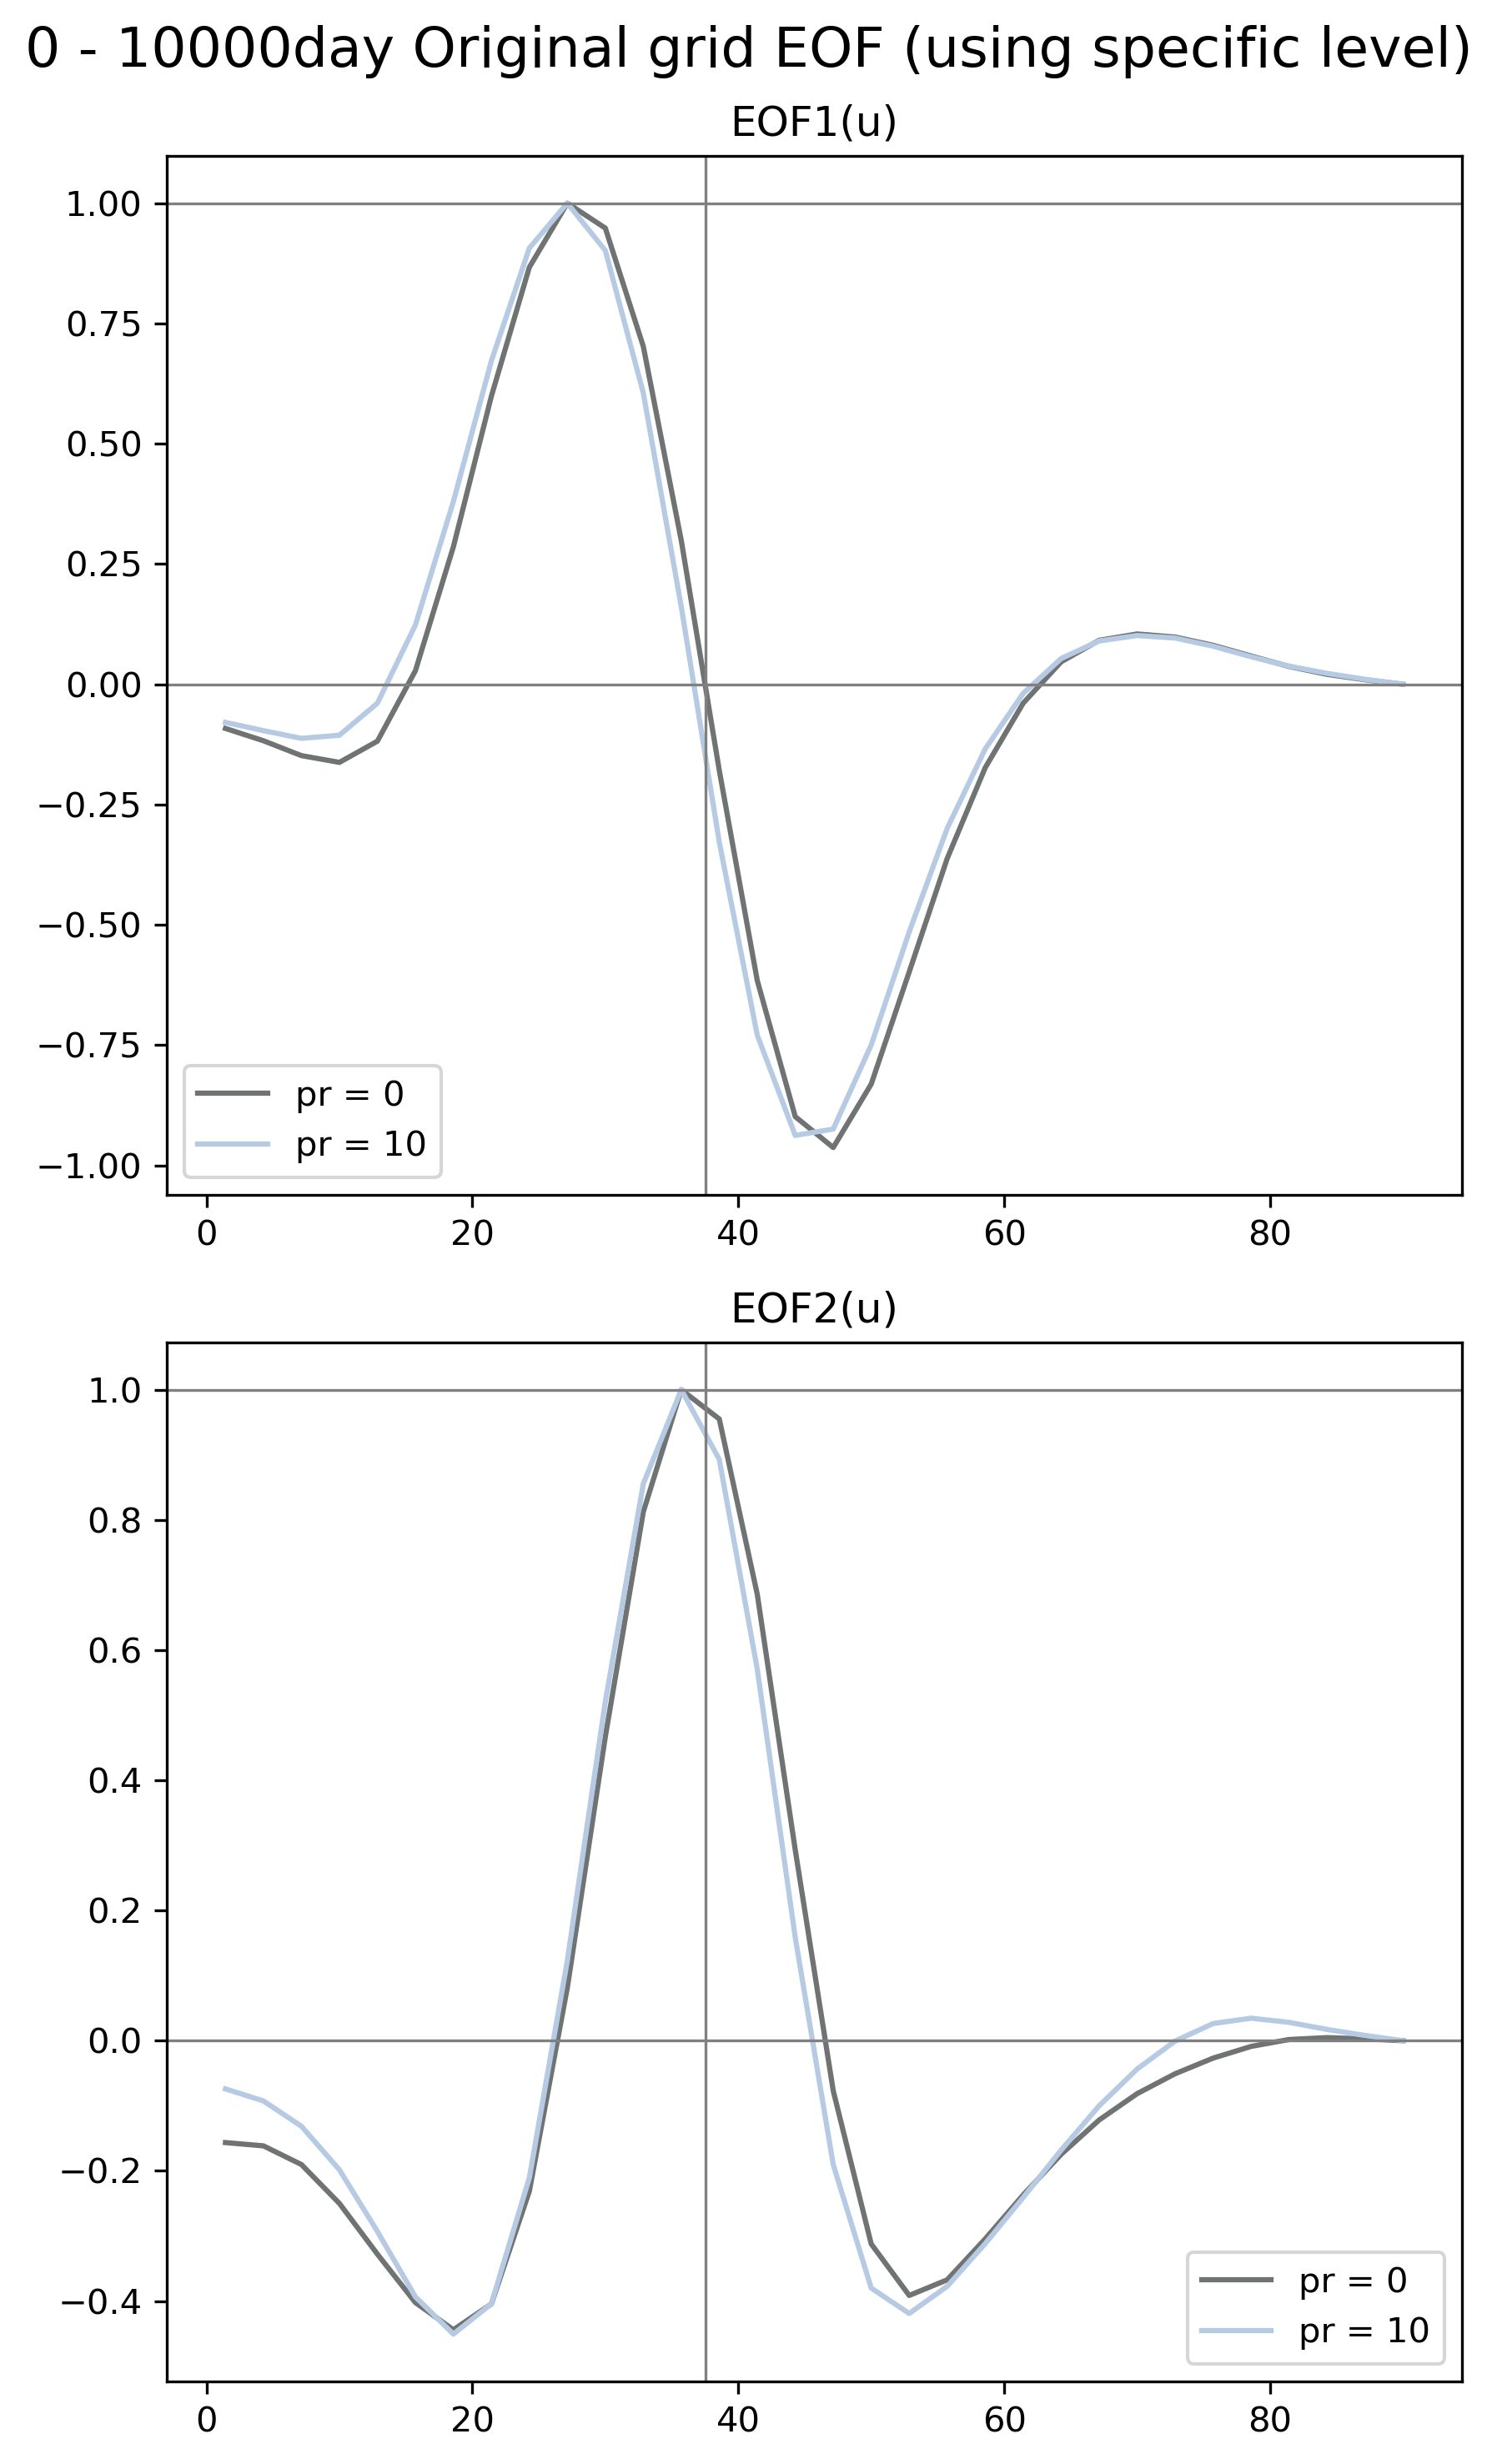

In [614]:
import matplotlib.colors as colors
import matplotlib as mpl

### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########

fig,ax = plt.subplots(2,figsize=(6,10),dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_onlyz, value=z_biggest_all[a])
    print(biggest_u_z_idx, pr)
    yn = y[32:]
    if pr == pr_start:
        control = np.max(EOF1_all[a,biggest_u_z_idx, :])
        ax[0].plot(yn, (EOF1_all[a,biggest_u_z_idx, :]/ control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap:
        control = np.max(-EOF1_all[a,biggest_u_z_idx, :])
        ax[0].plot(yn, (-EOF1_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*2:
        control = np.max(EOF1_all[a,biggest_u_z_idx, :])
        ax[0].plot(yn, (EOF1_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*3:
        control = np.max(EOF1_all[a,biggest_u_z_idx, :])
        ax[0].plot(yn, (EOF1_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*4:
        control = np.max(-EOF1_all[a,biggest_u_z_idx, :])
        ax[0].plot(yn, -(EOF1_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*5:
        control = np.max(-EOF1_all[a,biggest_u_z_idx, :])
        ax[0].plot(yn, -(EOF1_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    # print(control)
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[0].axvline(x=y_pr0, color='gray', lw=0.8)
ax[0].axhline(y=0, color='gray', lw=0.8)
ax[0].axhline(y=1, color='gray', lw=0.8)

ax[0].legend()
ax[0].set_title("EOF1(u)")
#############################################################################
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_onlyz, value=z_biggest_all[a])
    # print(pr/pr_leap)
    # print(biggest_u_z_idx, pr)
    
    # if pr == 10:    
        # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # else:
    # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    yn = y[32:]
    if pr == pr_start:
        control = np.max(-EOF2_all[a,biggest_u_z_idx, :])
        ax[1].plot(yn, -(EOF2_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap:
        control = np.max(-EOF2_all[a,biggest_u_z_idx, :])
        ax[1].plot(yn, (-EOF2_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*2:
        control = np.max(-EOF2_all[a,biggest_u_z_idx, :])
        ax[1].plot(yn, -(EOF2_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*3:
        control = np.max(-EOF2_all[a,biggest_u_z_idx, :])
        ax[1].plot(yn, -(EOF2_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*4:
        control = np.max(-EOF2_all[a,biggest_u_z_idx, :])
        ax[1].plot(yn, -(EOF2_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*5:
        control = np.max(-EOF2_all[a,biggest_u_z_idx, :])
        ax[1].plot(yn, -(EOF2_all[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[1].axvline(x=y_pr0, color='gray', lw=0.8)
ax[1].axhline(y=1, color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].legend()
ax[1].set_title("EOF2(u)")

# plt.suptitle("500 - 2900day Original grid EOF (using specific level)", fontsize=16)
plt.suptitle(f"{start} - {end}day Original grid EOF (using specific level)", fontsize=16)

plt.tight_layout()
# plt.savefig("Original grid EOF(using specific level).png", dpi=600., bbox_inches="tight")

plt.show()


In [615]:
EOF1_all.shape

(2, 20, 32)

In [616]:
y.shape

(64,)

0.0
1.0
0.0
1.0


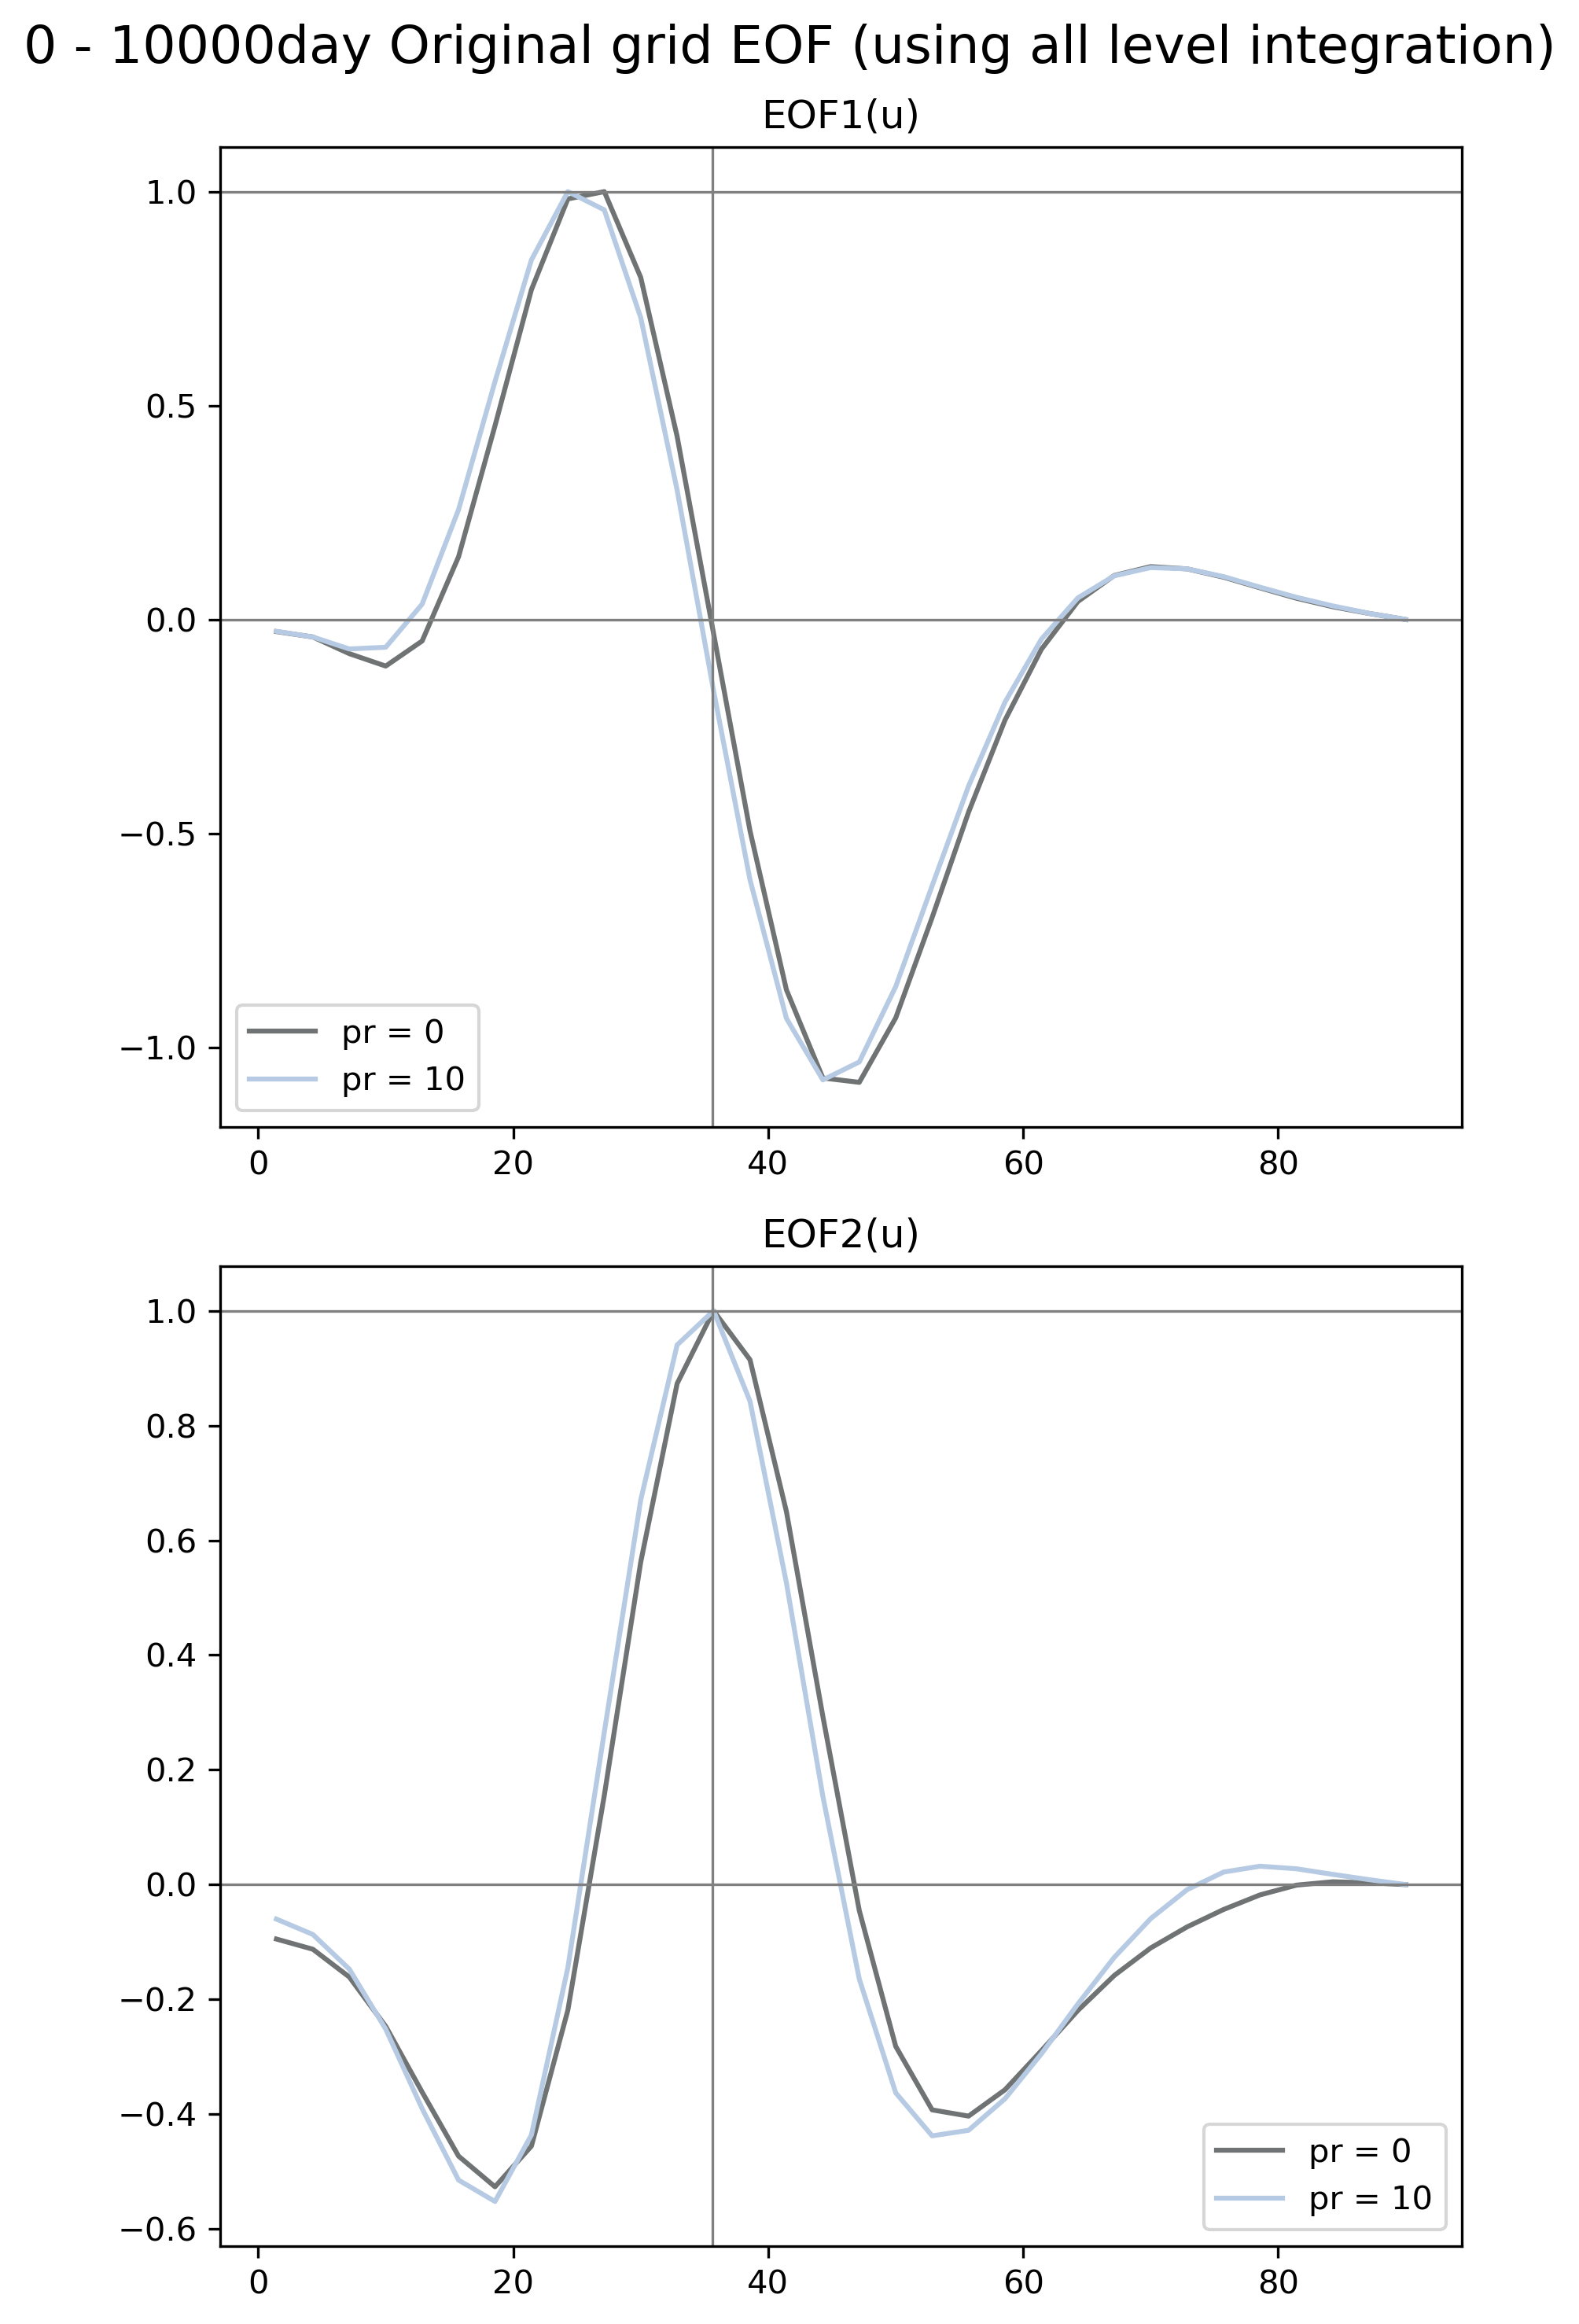

In [617]:
fig,ax = plt.subplots(2,figsize=(6,10),dpi=300.)
boostrap_vertical_average_check_05percentage = True
if boostrap_vertical_average_check_05percentage:
    y_pr0_vertical_average = 35.63125391849529
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    # biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    print(pr/pr_leap)
    # print(biggest_u_z_idx, pr)
    
    # interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], EOF1_all[a,:,:])
    # EOF1_all_thin = interp_spline(sigma_mean2s, yys)
    # if pr == 10:    
        # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # else:
    # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    if pr == pr_start:
        control = np.max(np.nanmean(EOF1_all[a,:, :], axis=0))
        ax[0].plot(yn, (np.nanmean(EOF1_all[a,:, :], axis=0)/ control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap:
        control = np.max(-np.nanmean(EOF1_all[a,:, :], axis=0))
        ax[0].plot(yn, -(np.nanmean(EOF1_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*2:
        control = np.max(np.nanmean(EOF1_all[a,:, :], axis=0))
        ax[0].plot(yn, (np.nanmean(EOF1_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*3:
        control = np.max(np.nanmean(EOF1_all[a,:, :], axis=0))
        ax[0].plot(yn, (np.nanmean(EOF1_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*4:
        control = np.max(-np.nanmean(EOF1_all[a,:, :], axis=0))
        ax[0].plot(yn, -(np.nanmean(EOF1_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*5:
        control = np.max(-np.nanmean(EOF1_all[a,:, :], axis=0))
        ax[0].plot(yn, -(np.nanmean(EOF1_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[0].axvline(x=y_pr0_vertical_average, color='gray', lw=0.8) # using u_vertically_bootstrap_latitude.txt
ax[0].axhline(y=1, color='gray', lw=0.8)
ax[0].axhline(y=0, color='gray', lw=0.8)
ax[0].legend()
ax[0].set_title("EOF1(u)")
###########################################################################
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    # biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    print(pr/pr_leap)
    # print(biggest_u_z_idx, pr)
    
    # interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], EOF2_all[a,:,:])
    # EOF2_all_thin = interp_spline(sigma_mean2s, yys)
    # if pr == 10:    
        # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # else:
    # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    if pr == pr_start:
        control = np.max(-np.nanmean(EOF2_all[a,:, :], axis=0))
        ax[1].plot(yn, -(np.nanmean(EOF2_all[a,:, :], axis=0)/ control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap:
        control = np.max(-np.nanmean(EOF2_all[a,:, :], axis=0))
        ax[1].plot(yn, -(np.nanmean(EOF2_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*2:
        control = np.max(-np.nanmean(EOF2_all[a,:, :], axis=0))
        ax[1].plot(yn, -(np.nanmean(EOF2_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])

    if pr == pr_start+pr_leap*3:
        control = np.max(-np.nanmean(EOF2_all[a,:, :], axis=0))
        ax[1].plot(yn, -(np.nanmean(EOF2_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*4:
        control = np.max(-np.nanmean(EOF2_all[a,:, :], axis=0))
        ax[1].plot(yn, -(np.nanmean(EOF2_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == pr_start+pr_leap*5:
        control = np.max(-np.nanmean(EOF2_all[a,:, :], axis=0))
        ax[1].plot(yn, -(np.nanmean(EOF2_all[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[1].axvline(x=y_pr0_vertical_average, color='gray', lw=0.8)
ax[1].axhline(y=1, color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].legend()
ax[1].set_title("EOF2(u)")

# plt.suptitle("500 - 2900day Original grid EOF (using all level integration)", fontsize=16)
plt.suptitle(f"{start} - {end}day Original grid EOF (using all level integration)", fontsize=16)

plt.tight_layout()
# plt.savefig("Original grid EOF(using all level integration).png", dpi=600., bbox_inches="tight")
plt.show()


## EOF -> interpolation

In [ ]:
do_interpolation_then_EOF = True
interpolation_times = 10

if do_interpolation_then_EOF:
    u_zy_thin    = np.zeros(((u_zy.shape[0], 20*interpolation_times, 32*interpolation_times)))
    yys          = np.linspace(0,90,32*interpolation_times)
    sigma_mean2s = np.linspace(0,1,20*interpolation_times)
    
    EOF1_all = np.zeros(((total_pr, u_zy.shape[1], u_zy.shape[2])))
    PC1_all  = np.zeros((total_pr , u_zy.shape[0]))
    
    EOF2_all = np.zeros(((total_pr, u_zy.shape[1], u_zy.shape[2])))
    PC2_all  = np.zeros((total_pr , u_zy.shape[0]))


    EOF1_all_thin = np.zeros(((total_pr, u_zy.shape[1]*interpolation_times, u_zy.shape[2]*interpolation_times)))
    EOF2_all_thin = np.zeros(((total_pr, u_zy.shape[1]*interpolation_times, u_zy.shape[2]*interpolation_times)))
    
    a = 0
    for pr in range(pr_start, pr_to, pr_leap):
        u_zy = np.nanmean(u[a,:,:,32:,:], axis=3)

            
        EOF1_all[a], PC1_all[a], EOF2_all[a], PC2_all[a] = Cal_EOF_PC(EOF, u_zy, a, total_pr)

        interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], EOF1_all[a])
        EOF1_all_thin[a,:,:] = interp_spline(sigma_mean2s, yys)

        interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], EOF2_all[a])
        EOF2_all_thin[a,:,:] = interp_spline(sigma_mean2s, yys)
        # print(a)
        a += 1
    print("done")





In [ ]:
fig,ax = plt.subplots(2,figsize=(6,10),dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    print(biggest_u_z_idx, pr)
    
    if pr ==0:
        control = np.max(EOF1_all_thin[a,biggest_u_z_idx, :])
        ax[0].plot(yys, (EOF1_all_thin[a,biggest_u_z_idx, :]/ control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 10:
        control = np.max(-EOF1_all_thin[a,biggest_u_z_idx, :])
        ax[0].plot(yys, -(EOF1_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 20:
        control = np.max(EOF1_all_thin[a,biggest_u_z_idx, :])
        ax[0].plot(yys, (EOF1_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==30:
        control = np.max(EOF1_all_thin[a,biggest_u_z_idx, :])
        ax[0].plot(yys, (EOF1_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==40:
        control = np.max(-EOF1_all_thin[a,biggest_u_z_idx, :])
        ax[0].plot(yys, -(EOF1_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==50:
        control = np.max(-EOF1_all_thin[a,biggest_u_z_idx, :])
        ax[0].plot(yys, -(EOF1_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    # print(control)
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[0].axvline(x=y_pr0, color='gray', lw=0.8)
ax[0].axhline(y=0, color='gray', lw=0.8)
ax[0].axhline(y=1, color='gray', lw=0.8)

ax[0].legend()
ax[0].set_title("EOF1(u)")
#############################################################################
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    # print(pr/pr_leap)
    # print(biggest_u_z_idx, pr)
    
    # if pr == 10:    
        # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # else:
    # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    if pr ==0:
        control = np.max(-EOF2_all_thin[a,biggest_u_z_idx, :])
        ax[1].plot(yys, -(EOF2_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 10:
        control = np.max(-EOF2_all_thin[a,biggest_u_z_idx, :])
        ax[1].plot(yys, -(EOF2_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 20:
        control = np.max(-EOF2_all_thin[a,biggest_u_z_idx, :])
        ax[1].plot(yys, -(EOF2_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])

    if pr ==30:
        control = np.max(-EOF2_all_thin[a,biggest_u_z_idx, :])
        ax[1].plot(yys, -(EOF2_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==40:
        control = np.max(-EOF2_all_thin[a,biggest_u_z_idx, :])
        ax[1].plot(yys, -(EOF2_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==50:
        control = np.max(-EOF2_all_thin[a,biggest_u_z_idx, :])
        ax[1].plot(yys, -(EOF2_all_thin[a,biggest_u_z_idx, :]/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[1].axvline(x=y_pr0, color='gray', lw=0.8)
ax[1].axhline(y=1, color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].legend()
ax[1].set_title("EOF2(u)")

plt.suptitle(f"{start}-{end} day EOF (using specific level) -> interpolation", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
fig,ax = plt.subplots(2,figsize=(6,10),dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    print(biggest_u_z_idx, pr)
    
    if pr ==0:
        control = np.max(np.nanmean(EOF1_all_thin[a,:, :], axis=0))
        ax[0].plot(yys, (np.nanmean(EOF1_all_thin[a,:, :], axis=0)/ control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 10:
        control = np.max(-np.nanmean(EOF1_all_thin[a,:, :], axis=0))
        ax[0].plot(yys, -(np.nanmean(EOF1_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 20:
        control = np.max(np.nanmean(EOF1_all_thin[a,:, :], axis=0))
        ax[0].plot(yys, (np.nanmean(EOF1_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==30:
        control = np.max(np.nanmean(EOF1_all_thin[a,:, :], axis=0))
        ax[0].plot(yys, (np.nanmean(EOF1_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==40:
        control = np.max(-np.nanmean(EOF1_all_thin[a,:, :], axis=0))
        ax[0].plot(yys, -(np.nanmean(EOF1_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==50:
        control = np.max(-np.nanmean(EOF1_all_thin[a,:, :], axis=0))
        ax[0].plot(yys, -(np.nanmean(EOF1_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    # print(control)
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[0].axvline(x=y_pr0, color='gray', lw=0.8)
ax[0].axhline(y=0, color='gray', lw=0.8)
ax[0].axhline(y=1, color='gray', lw=0.8)

ax[0].legend()
ax[0].set_title("EOF1(u)")
#############################################################################
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[a])
    # print(pr/pr_leap)
    # print(biggest_u_z_idx, pr)
    
    # if pr == 10:    
        # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    # else:
    # plt.plot(yys, EOF1_all_thin[biggest_u_z_idx, :], label=f"pr = {a*pr_leap}")
    if pr ==0:
        control = np.max(-np.nanmean(EOF2_all_thin[a,:, :], axis=0))
        ax[1].plot(yys, -(np.nanmean(EOF2_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 10:
        control = np.max(-np.nanmean(EOF2_all_thin[a,:, :], axis=0))
        ax[1].plot(yys, -(np.nanmean(EOF2_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 20:
        control = np.max(-np.nanmean(EOF2_all_thin[a,:, :], axis=0))
        ax[1].plot(yys, -(np.nanmean(EOF2_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])

    if pr ==30:
        control = np.max(-np.nanmean(EOF2_all_thin[a,:, :], axis=0))
        ax[1].plot(yys, -(np.nanmean(EOF2_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==40:
        control = np.max(-np.nanmean(EOF2_all_thin[a,:, :], axis=0))
        ax[1].plot(yys, -(np.nanmean(EOF2_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==50:
        control = np.max(-np.nanmean(EOF2_all_thin[a,:, :], axis=0))
        ax[1].plot(yys, -(np.nanmean(EOF2_all_thin[a,:, :], axis=0)/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[1].axvline(x=y_pr0_vertical_average, color='gray', lw=0.8)
ax[1].axhline(y=1, color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].legend()
ax[1].set_title("EOF2(u)")

plt.suptitle(f"{start}-{end} day EOF (using all levels integration) -> interpolation", fontsize=16)
plt.tight_layout()
plt.show()


# u -> EOF, PC -> autocorrelation

In [242]:
u.shape

(6, 9500, 20, 64, 128)

In [618]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from EOF import EOF

In [24]:
a = 0
EKE = np.zeros(u.shape)
for pr in range(pr_start, pr_to, pr_leap):
    Vzm = np.nanmean(v[a], axis=3)
    Tzm = np.nanmean(t[a], axis=3)
    Uzm = np.nanmean(u[a], axis=3)
    
    Vza     = np.zeros(u.shape)
    Uza     = np.zeros(u.shape)
    Tza     = np.zeros(u.shape)
    
    
    for i in range(0,128):
        Vza[a,:,:,:,i]     = v[a,:,:,:,i] - Vzm
        Uza[a,:,:,:,i]     = u[a,:,:,:,i] - Uzm
        Tza[a,:,:,:,i]     = t[a,:,:,:,i] - Tzm
        
        
    EKE[a,:,:,:,:] = (Uza[a,:,:,:,:]**2 + Vza[a,:,:,:,:]**2) * 0.5
    print(a)
    a += 1
print("done")

NameError: name 'v' is not defined

In [619]:
import matplotlib.colors as colors
import matplotlib as mpl
# fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
# mpl.rcParams['axes.linewidth'] = 2

###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
g = 9.81


EOF1_all = np.zeros(((int(total_pr), 20,32)))
EOF2_all = np.zeros(((int(total_pr), 20,32)))


PC1_all = np.zeros((int(total_pr), total_day)) # total_day
PC2_all = np.zeros((int(total_pr), total_day)) # total_day

explain_all = np.zeros((int(total_pr), 640))
judge_reshape = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):    
    # Step1. interpolation
    u_zy = np.nanmean(u[a,:,:,32:,:], axis=(3)) #[time, z, y] 
    # u_zy = np.nanmean(EKE[a,:,:,32:,:], axis=(3)) #[time, z, y] 
    
    cy = np.cos(np.deg2rad(y[32:]))

    
    # Step2. Do EOF
    sigma_mean      = np.nanmean(p[a,-check_days_length:,:,:,:]/ps[a,-check_days_length:,:,:,:], axis=(0,3))
    sigma_onlyz     = np.nanmean(sigma_mean, axis=1)

    y_nhalf = np.linspace(0,90,32)
    yy_nhalf, sigma_mean2_nhalf = np.meshgrid(y_nhalf,sigma_onlyz)

    u_zy_w = np.zeros(u_zy.shape)
    
    for i in range(np.shape(u_zy)[0]): 
        for j in range(np.shape(u_zy)[1]): 
                u_zy_w[i,j,:] = u_zy[i,j,:] * (cy[:])**0.5

    if judge_reshape:
        u_zy_w_reshape = np.reshape(u_zy_w, (np.shape(u_zy)[0], 32*20))
        single_EOF = EOF((u_zy_w_reshape,), n_components=32*20, field="1D")
    else:
        single_EOF = EOF((u_zy_w,), n_components=640, field="2D")
    
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs    = single_EOF.PC[0,:]
    PC2s   = single_EOF.PC[1,:]
    
    EOFs   = single_EOF.EOF[0,:]
    EOF2s  = single_EOF.EOF[1,:]

    PCs_std = PCs.std()
    PCs     = PCs / PCs_std

    PC2s_std = PC2s.std()
    PC2s     = PC2s / PC2s_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std

    EOF2s_std  = EOF2s.std()
    EOF2s      = EOF2s * PC2s_std
    
    # Step 4: reshape (1280,) back to (20,64)
    if judge_reshape:
        EOFs_zy  = np.reshape(EOFs, (20,32))
        EOF2s_zy = np.reshape(EOF2s, (20,32))
        EOF1_all[a,:] = EOFs_zy
        EOF2_all[a,:] = EOF2s_zy
    else:
        EOFs_zy  = np.reshape(EOFs, (20,32))
        EOF2s_zy = np.reshape(EOF2s, (20,32))
        EOF1_all[a,:,:] = EOFs_zy
        EOF2_all[a,:,:] = EOF2s_zy
    


    PC1_all[a,:] = PCs
    PC2_all[a,:] = PC2s

    explain_all[a,:] = single_EOF.explained
    print(a)
    a += 1
print("done")

0
1
done


In [620]:
explain_all.shape

(2, 640)

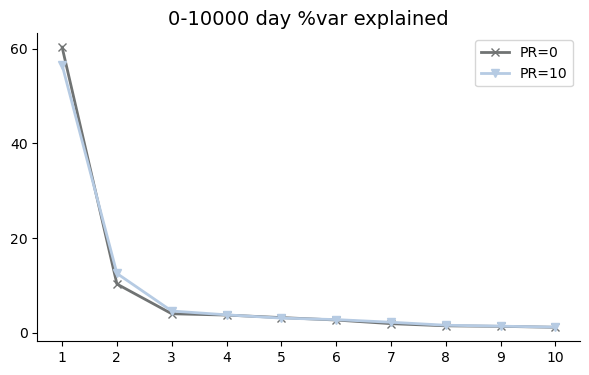

In [621]:
xxx = np.arange(1,11,1)
fig,ax = plt.subplots(figsize=(7,4), dpi=100)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    if pr == pr_start:
        ax.plot(xxx, explain_all[a,:10]*100, "-x", color=colors[int(pr/pr_leap)], lw=2, label="PR=0")
    if pr == pr_start+pr_leap:
        ax.plot(xxx, explain_all[a,:10]*100, "-", color=colors[int(pr/pr_leap)], lw=2, marker='v', label="PR=10")
    if pr == pr_start+pr_leap*2:
        ax.plot(xxx, explain_all[a,:10]*100, "-D", color=colors[int(pr/pr_leap)], lw=2, label="PR=20")
    if pr == pr_start+pr_leap*3:
        ax.plot(xxx, explain_all[a,:10]*100, "-o", color=colors[int(pr/pr_leap)], lw=2, label="PR=30")
    if pr == pr_start+pr_leap*4:
        ax.plot(xxx, explain_all[a,:10]*100, "-*", color=colors[int(pr/pr_leap)], lw=2, label="PR=40")
    if pr == pr_start+pr_leap*5:
        ax.plot(xxx, explain_all[a,:10]*100, "-^", color=colors[int(pr/pr_leap)], lw=2, label="PR=50")
    a += 1
# plt.grid()
plt.title(f"{start}-{end} day %var explained", fontsize=14)
plt.xticks(np.arange(1,11,1))
plt.yticks(np.arange(0,80,20))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend()
# plt.savefig("%var explained.png", dpi=600., bbox_inches="tight")


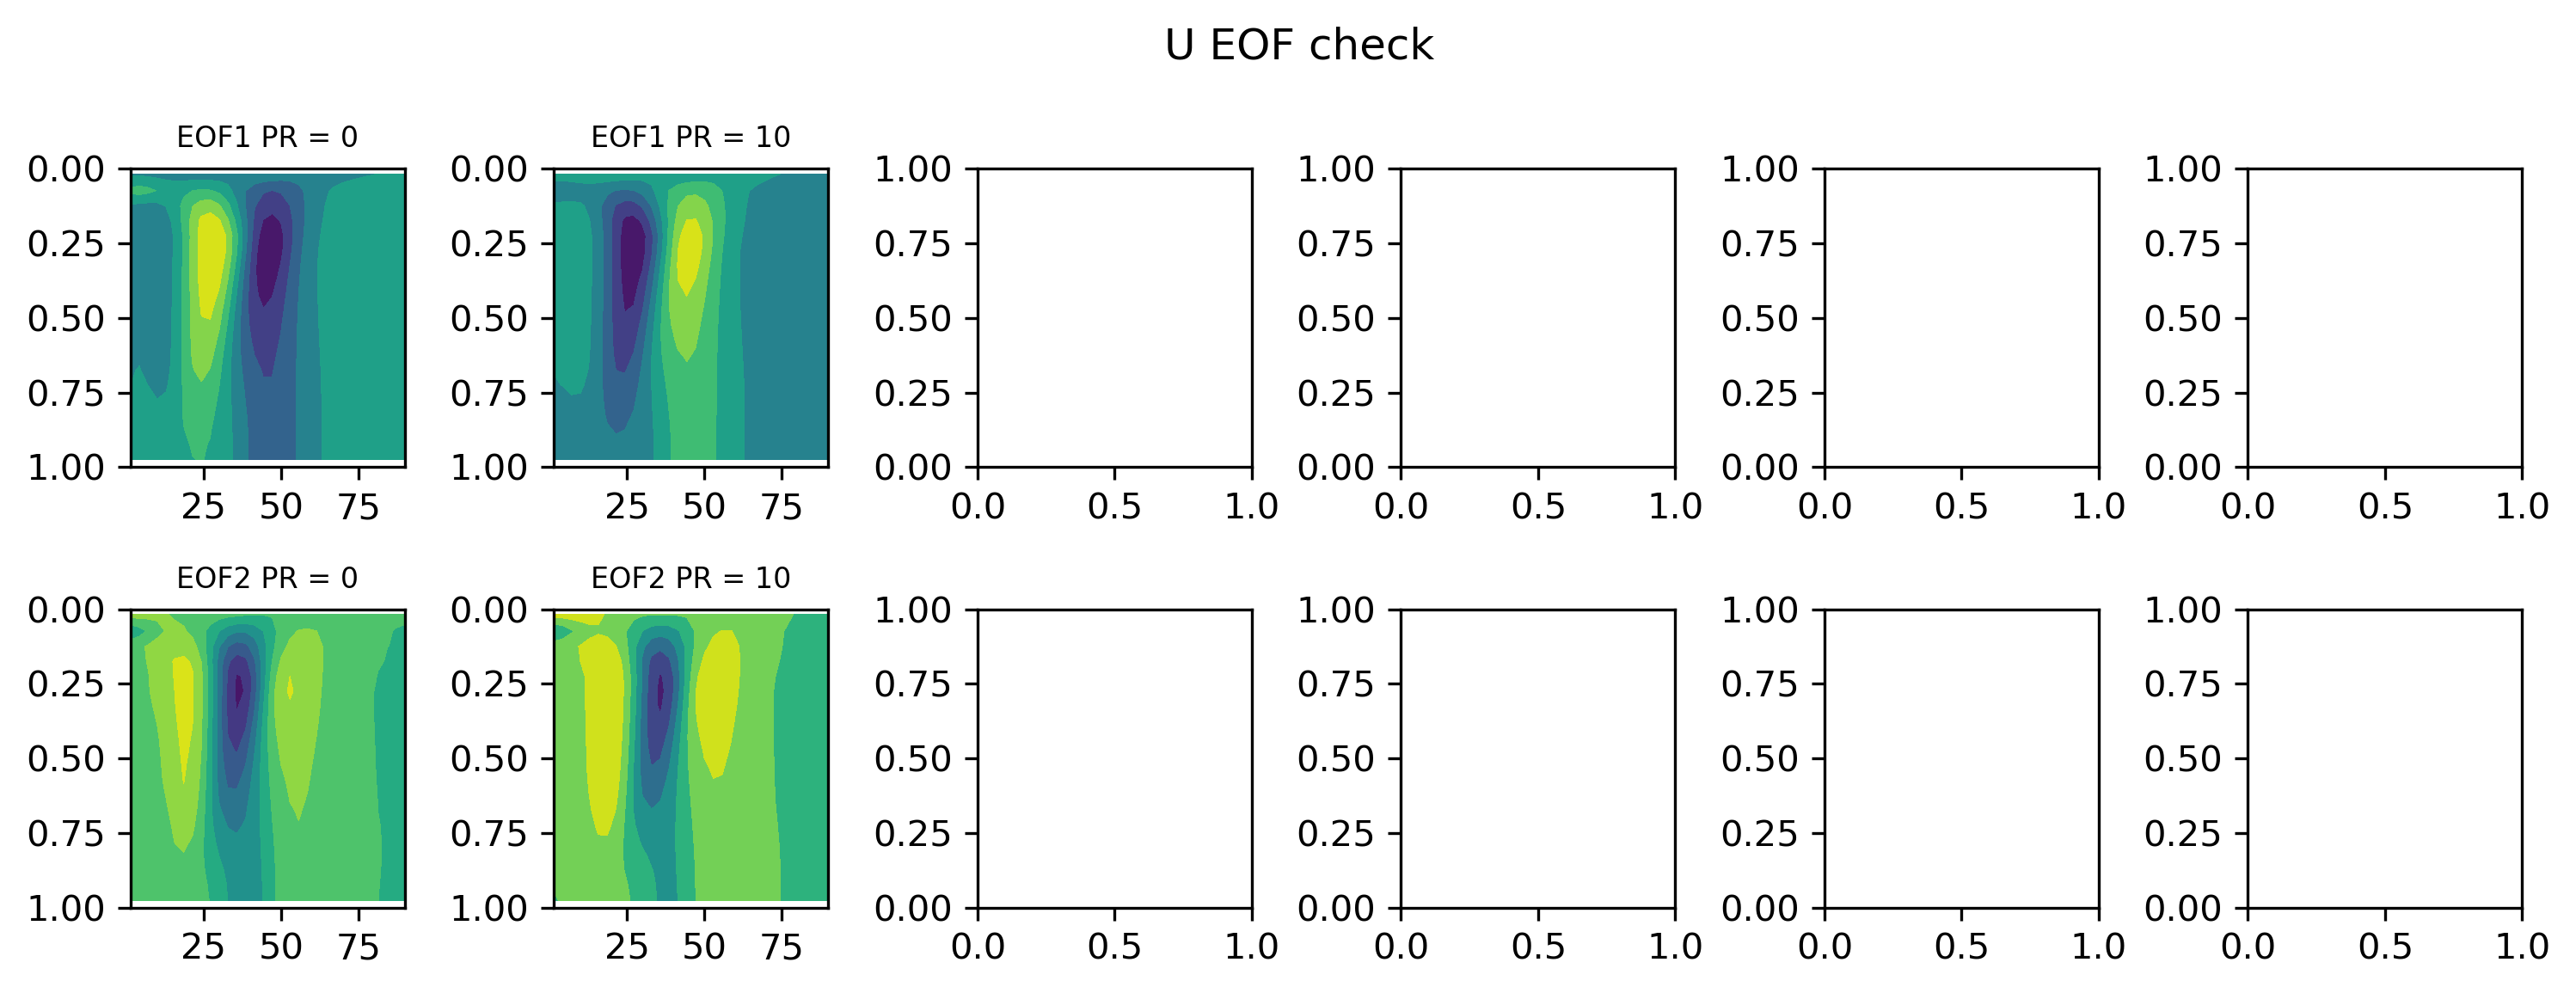

In [622]:
fig, ax = plt.subplots(2,6, figsize=(10,4), dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    ax[0,a].contourf(yy[:,32:], sigma_mean2[:,32:], EOF1_all[a])
    ax[0,a].set_ylim([1,0])
    ax[0,a].set_title(f"EOF1 PR = {pr}", fontsize=8)

    ax[1,a].contourf(yy[:,32:], sigma_mean2[:,32:], EOF2_all[a])
    ax[1,a].set_ylim([1,0])
    ax[1,a].set_title(f"EOF2 PR = {pr}", fontsize=8)
    a+=1
plt.suptitle("U EOF check")
fig.tight_layout(rect=[0, 0.03, 1, 0.999])
# plt.tight_layout()
plt.show()

In [624]:
print(PC1_all[0,:].std())
print(PC1_all[0,:].mean())

print(PC1_all[1,:].std())
print(PC1_all[1,:].mean())


1.0
0.3364741414879063
1.0
-0.7394667212237926


## then all day do autocorrelation

In [625]:
def autocorr1(x,lags):
    corr = np.zeros(int(lags))
    for l in range(lags):
        if l == 0:
            corr[l] = 1.
        else:
            corr[l] = np.corrcoef(x[l:],x[:-l])[0][1]
    # corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in range(lags)]
    return np.array(corr)

In [626]:
def dividied_autocorr1(x,each_length,lags):
    x_div = np.zeros(int(len(x)/each_length))
    # for i in range(each_length):
        # x_div[i] = x[i*each_length:(i+1)*each_length]    
    corr = np.zeros(( int(len(x)/each_length),int(lags) ))
    for i in range(int(len(x)/each_length)):
        for l in range(lags):
            if l == 0:
                corr[i,l] = 1.
            else:
                corr[i,l] = np.corrcoef(x[l:],x[:-l])[0][1]
    return np.array(corr)

In [627]:
corr_div = dividied_autocorr1(PC1_all[0,:], 100, 100)

In [628]:
print(corr_div.shape)

(100, 100)


In [629]:
auto_length = 100
yyy_thin  = autocorr1(PC1_all[0,:], auto_length) 
yyy2_thin = autocorr1(PC1_all[1,:], auto_length) 
yyy3_thin = autocorr1(PC1_all[2,:], auto_length) 
yyy4_thin = autocorr1(PC1_all[3,:], auto_length) 
yyy5_thin = autocorr1(PC1_all[4,:], auto_length) 
yyy6_thin = autocorr1(PC1_all[5,:], auto_length) 

yyy_thin2  = autocorr1(PC2_all[0,:], auto_length) 
yyy2_thin2 = autocorr1(PC2_all[1,:], auto_length) 
yyy3_thin2 = autocorr1(PC2_all[2,:], auto_length) 
yyy4_thin2 = autocorr1(PC2_all[3,:], auto_length) 
yyy5_thin2 = autocorr1(PC2_all[4,:], auto_length) 
yyy6_thin2 = autocorr1(PC2_all[5,:], auto_length) 

IndexError: index 2 is out of bounds for axis 0 with size 2

NameError: name 'yyy3_thin' is not defined

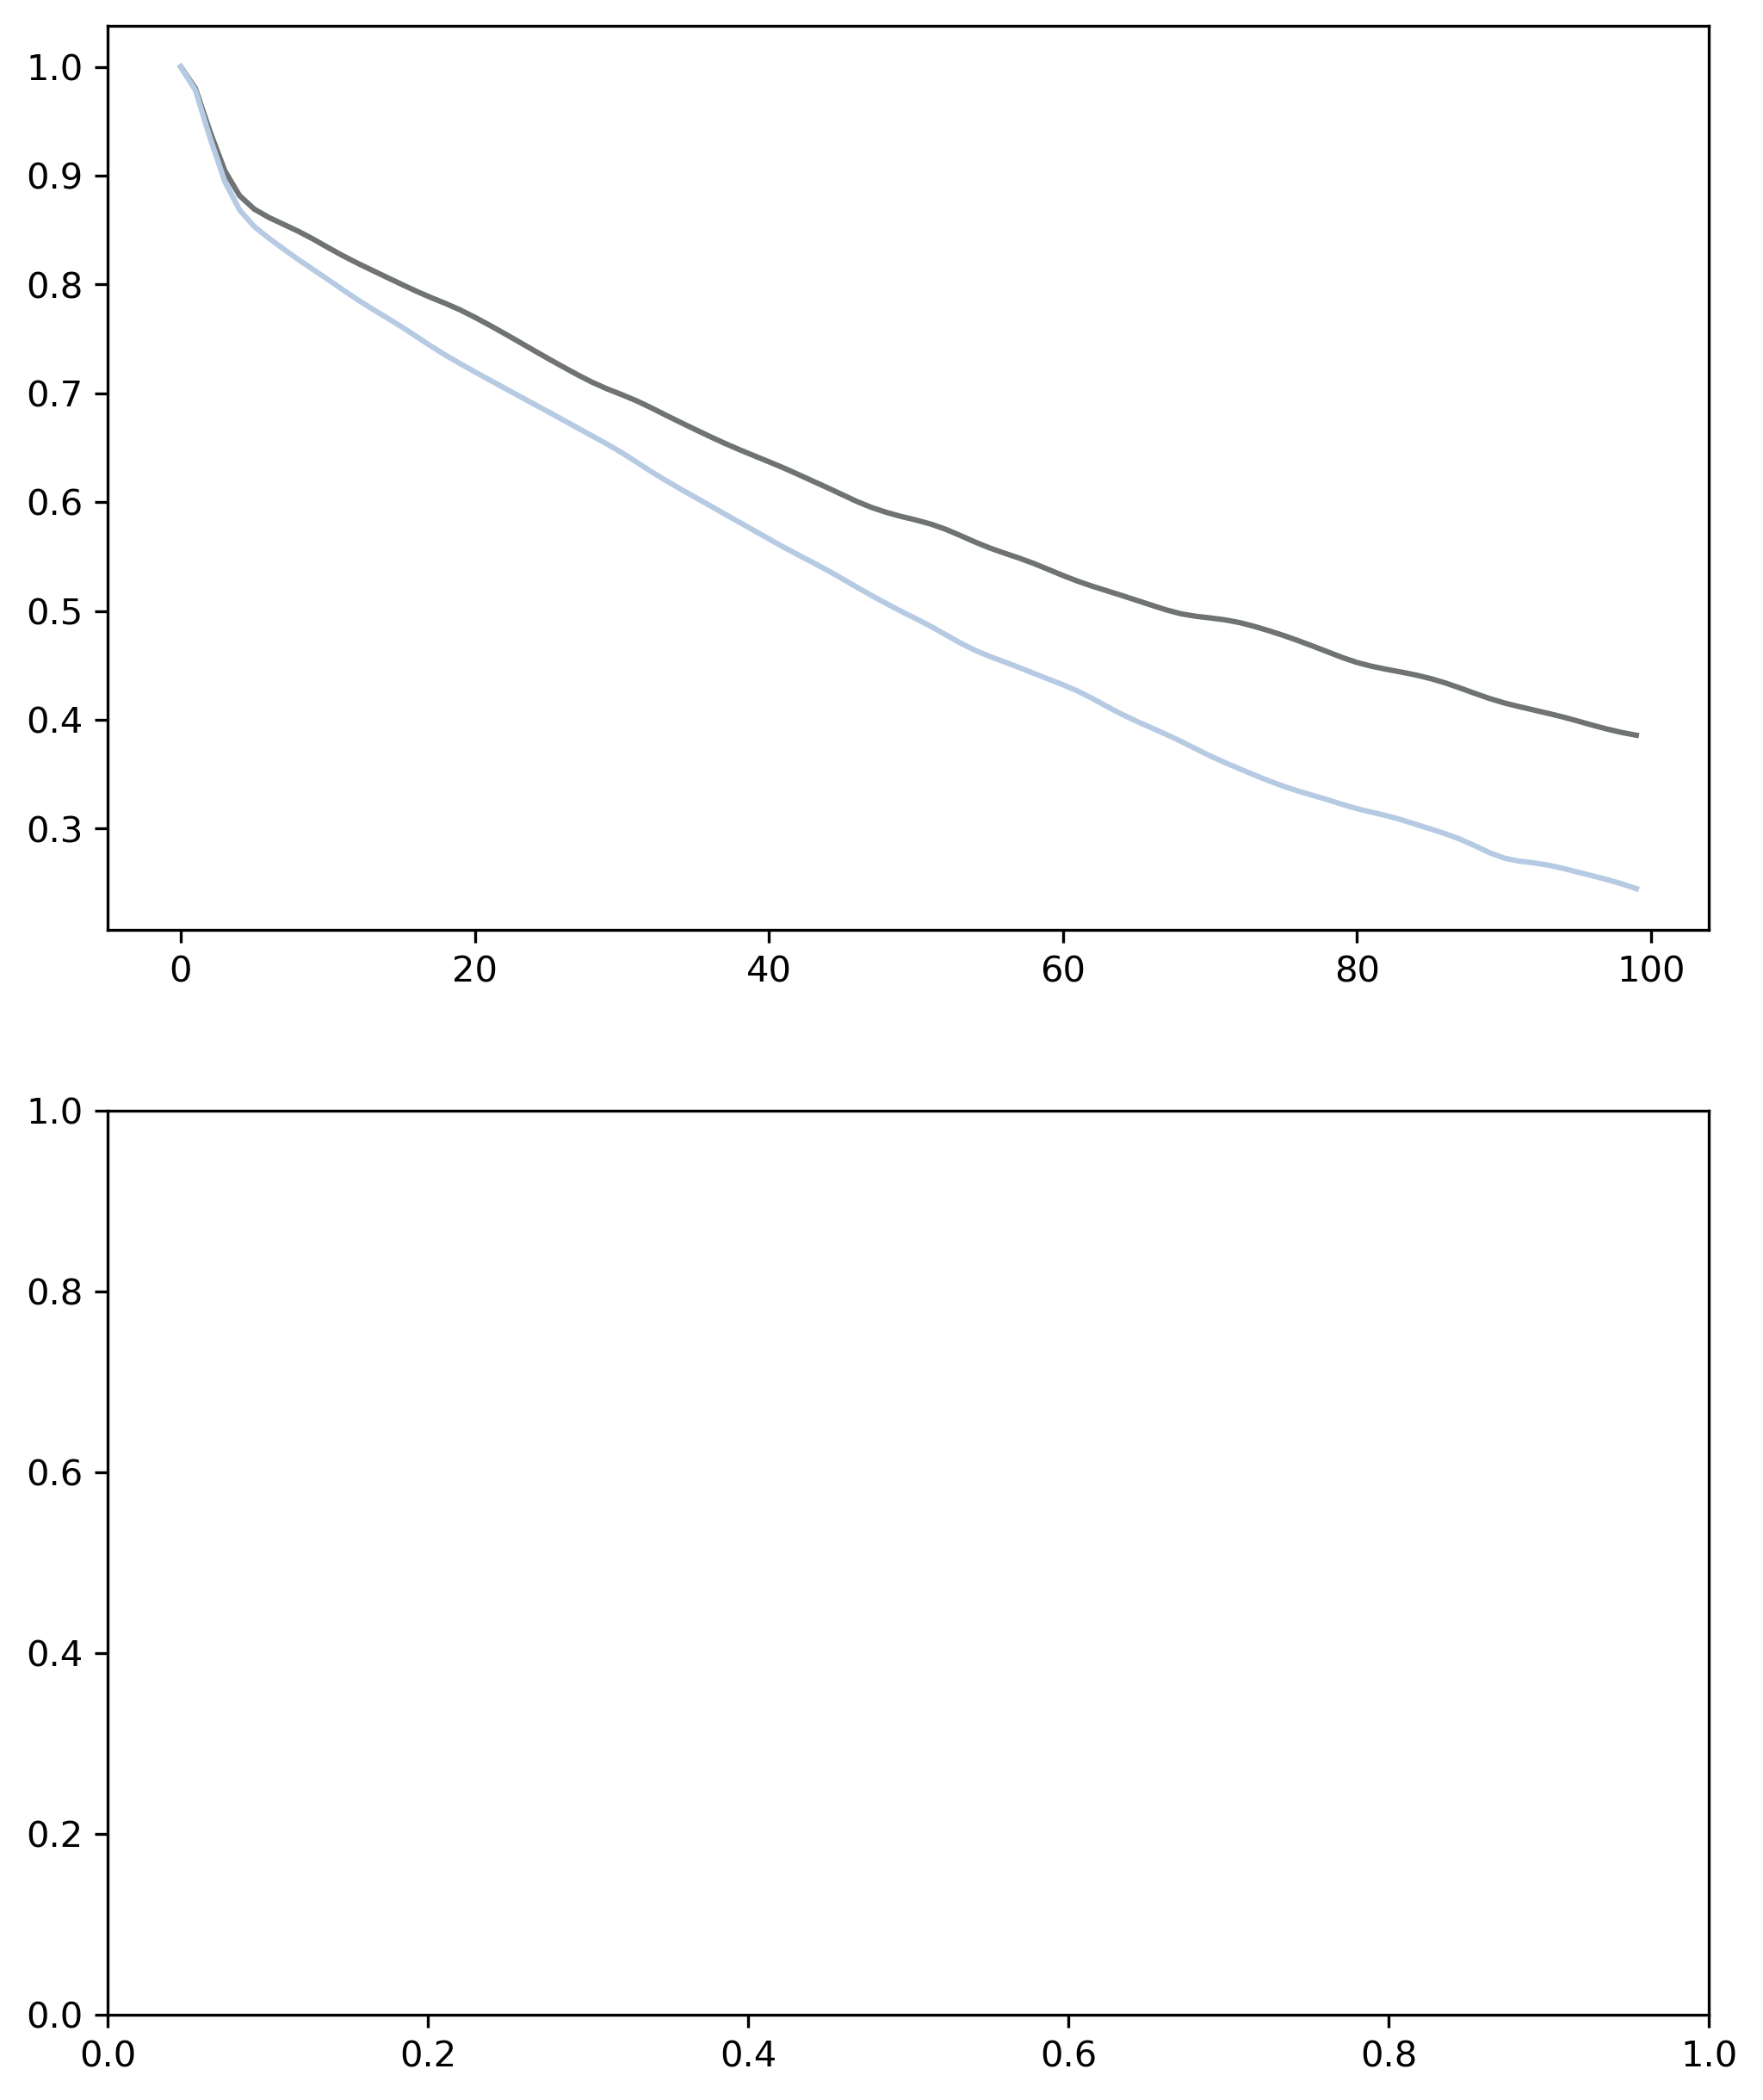

In [630]:
tau = np.arange(0,auto_length,1)
fig, ax = plt.subplots(2,figsize=(8,10),dpi=300)
ax[0].plot(tau, yyy_thin , label=f"PR={pr_start}", color=colors[0])
ax[0].plot(tau, yyy2_thin, label=f"PR={pr_start+pr_leap}", color=colors[1])
ax[0].plot(tau, yyy3_thin, label=f"PR={pr_start+pr_leap*2}", color=colors[2])
ax[0].plot(tau, yyy4_thin, label=f"PR={pr_start+pr_leap*3}", color=colors[3])
ax[0].plot(tau, yyy5_thin, label=f"PR={pr_start+pr_leap*4}", color=colors[4])
ax[0].plot(tau, yyy6_thin, label=f"PR={pr_start+pr_leap*5}", color=colors[5])
ax[0].legend()
ax[0].set_xlim([0,auto_length])
# ax[0].set_title("Original grid PC1 500-2900 day -> EOF, PC ->  autocorrelation")
ax[0].set_title(f"U Original grid PC2 {start}-{end} day -> EOF, PC ->  autocorrelation")


ax[0].grid()

###############################################################

ax[1].plot(tau, yyy_thin2 , label=f"PR={pr_start}", color=colors[0])
ax[1].plot(tau, yyy2_thin2, label=f"PR={pr_start+pr_leap}", color=colors[1])
ax[1].plot(tau, yyy3_thin2, label=f"PR={pr_start+pr_leap*2}", color=colors[2])
ax[1].plot(tau, yyy4_thin2, label=f"PR={pr_start+pr_leap*3}", color=colors[3])
ax[1].plot(tau, yyy5_thin2, label=f"PR={pr_start+pr_leap*4}", color=colors[4])
ax[1].plot(tau, yyy6_thin2, label=f"PR={pr_start+pr_leap*5}", color=colors[5])
ax[1].legend()
ax[1].set_xlim([0,auto_length])
# ax[1].set_title("Original grid PC2 500-2900 day -> EOF, PC ->  autocorrelation")
ax[1].set_title(f"U Original grid PC2 {start}-{end} day -> EOF, PC ->  autocorrelation")

ax[1].grid()
# plt.savefig("Autocorrelation original grid PC12(500 - 10000 day).png", dpi=600., bbox_inches="tight")
plt.show()

## Do effective of degree of freedom

In [631]:
yyy_thin.shape

(100,)

In [632]:
def cal_self_Martin_et_al_1999(window_length, r1):
    """
    T : window length
    r1: lag one autocorrelation of data1
    """
    final = window_length * ( (1-r1[1]) / (1+r1[1]) )
    return final

def cal_cross_dof_Martin_et_al_1999(T, r1, r2):
    """
    T : window length
    r1: lag one autocorrelation of data1
    r2: lag one autocorrelation of data2
    """
    final = np.zeros(T)
    a = 0
    for i in range(T, 0, -1):
        final[i] = i * ( (1-r1[1]*r2[1]) / (1+r1[1]*r2[1]) )
        a += 1
    return final

# Calculate PDF then do statistical test (to determine which day start)

In [633]:
# from scipy.stats import norm
from scipy import stats
import math
def run_t_test(data1, data2, dof1, dof2):
    
    # mean
    data1_mean, data2_mean = np.nanmean(data1), np.nanmean(data2)
    # standard deviation
    data1_sd, data2_sd = np.std(data1), np.std(data2)

    # std^2 / dof
    std_dof = ( ((data1_sd**2) / dof1) + ((data2_sd**2) / dof2) )**0.5

    # t-stat
    t_stat = (data1_mean - data2_mean) / ( std_dof )
    
    # critical value
    alpha = 0.1
    # lower_cv1 =  stats.t.ppf(alpha/2      , dof2) 
    # high_cv1  =  stats.t.ppf(1.0 - alpha/2, dof2) 

    lower_cv1 =  data1_mean - 1.96 * data1_sd / dof1**0.5 
    high_cv1  =  data1_mean + 1.96 * data1_sd / dof1**0.5 
    
    
    # t_test, _ = stats.ttest_rel(data1, data2)
    
    return t_stat, lower_cv1, high_cv1, t_test,_

In [634]:
PC1_all.shape

(2, 10000)

In [639]:
window_length = 500
auto_length = 2

a = 0

### all 9500 day do overlap window 
# PC1_window     = np.zeros((( u.shape[0], int(u.shape[1]/window_length), window_length )))
# overlap version
PC1_window      = np.zeros((( u.shape[0], int(u.shape[1]-window_length), window_length )))

test_stat_all   = np.zeros(( u.shape[0], PC1_window.shape[1]))
pvalue_all      = np.zeros(( u.shape[0], PC1_window.shape[1]))
cv_all          = np.zeros(( u.shape[0], PC1_window.shape[1]))

dof             = np.zeros(( u.shape[0], int(u.shape[1]-window_length)  ))
window_day_auto = np.zeros((( u.shape[0], int(u.shape[1]-window_length), auto_length )))

for pr in range(pr_start, pr_to, pr_leap):
    k = 0
    for i in range(0, u.shape[1]-window_length):
        # Step 1. Divide PC1 into 100 day window, so I got 9500/100 = 95 windows
        PC1_window[a,k,:] = (PC1_all[a,i:i+window_length])
        k += 1

    # Step 2. cal autocorrelation
    last_window_day_auto         = autocorr1(PC1_window[a,-1,:], auto_length)
    for i in range(PC1_window.shape[1]):
        window_day_auto[a,i,:]   = autocorr1(PC1_window[a,i,:], auto_length) 

        # Step 3. cal dof (degree of freedom)
        dof[a,i]          = cal_self_Martin_et_al_1999(window_length, window_day_auto[a,i,:])
        
    # print(test_stat)
    
    a += 1

In [640]:
window_day_auto

array([[[1.        , 0.9353827 ],
        [1.        , 0.93530842],
        [1.        , 0.93515248],
        ...,
        [1.        , 0.98599074],
        [1.        , 0.98598994],
        [1.        , 0.98603466]],

       [[1.        , 0.99057502],
        [1.        , 0.9906029 ],
        [1.        , 0.99062477],
        ...,
        [1.        , 0.9358538 ],
        [1.        , 0.93553645],
        [1.        , 0.93518472]]])

In [641]:
dof.shape

(2, 9500)

In [642]:
print(dof.shape)
print(last_window_day_auto.shape)
print(window_day_auto.shape)
print(PC1_window.shape)
print(PC1_all.shape)


(2, 9500)
(2,)
(2, 9500, 2)
(2, 9500, 500)
(2, 10000)


In [646]:
# dof_2000 = np.zeros(2000)
a = 0
PC1_2000_auto = np.zeros(( u.shape[0], auto_length ))
for pr in range(pr_start, pr_to, pr_leap):
    PC1_2000_auto[a,:]   = autocorr1(PC1_all[a,-2000:], auto_length)
    a += 1


In [647]:
dof_2000 = np.zeros( u.shape[0] )
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    dof_2000[a] = cal_self_Martin_et_al_1999(window_length, PC1_2000_auto[a,:])
    a += 1

In [648]:
dof_2000

array([5.08194821, 5.5303095 ])

In [649]:
dof

array([[16.69367504, 16.71350569, 16.75514374, ...,  3.52702146,
         3.52722429,  3.51588632],
       [ 2.36740215,  2.36036433,  2.35484731, ..., 16.56793462,
        16.6526319 , 16.74653529]])

In [651]:
t_score_all = np.zeros(( u.shape[0], int(u.shape[1]-window_length) ))
t_test_all  = np.zeros(( u.shape[0], int(u.shape[1]-window_length) ))

cv_low_all  = np.zeros(( u.shape[0], int(u.shape[1]-window_length) ))
cv_high_all = np.zeros(( u.shape[0], int(u.shape[1]-window_length) ))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    for i in range(PC1_window.shape[1]):
        ####################### PC1_window
        t_score, low_cv, high_cv, t_test, _ = run_t_test(PC1_all[a,-2000:], PC1_window[a,i,:], dof_2000[a], dof[a,i])
        # print(t_score)
        # print(cv)
        
        t_score_all[a,i] = t_score
        t_test_all[a,i]  = t_test
        cv_low_all[a,i]  = low_cv
        cv_high_all[a,i] = high_cv
        
        # print(i)
    a += 1

In [652]:
cv_high_all.shape

(2, 9500)

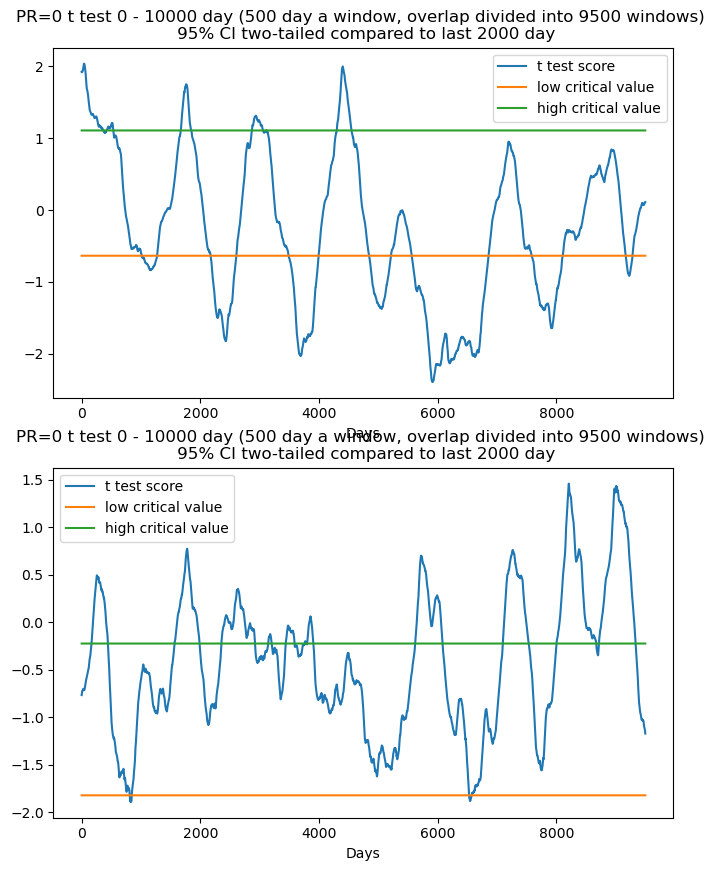

In [661]:
a = 0
fig, ax = plt.subplots(u.shape[0], figsize=(8,10), dpi=100.)
for pr in range(pr_start, pr_to, pr_leap):

    ax[a].plot(t_score_all[a, :], label="t test score")
    # plt.plot(t_test_all[a, ], label="t test score")
    
    ax[a].plot(cv_low_all[a], label="low critical value")
    ax[a].plot(cv_high_all[a], label="high critical value")
    
    ax[a].set_title(f"PR=0 t test 0 - 10000 day ({window_length} day a window, overlap divided into {10000-window_length} windows) \n 95% CI two-tailed compared to last 2000 day")
    ax[a].set_xlabel("Days")
    ax[a].legend()
    a += 1


In [357]:
cv_low_all - cv_high_all

array([[0., 0., 0., ..., 0., 0., 0.]])

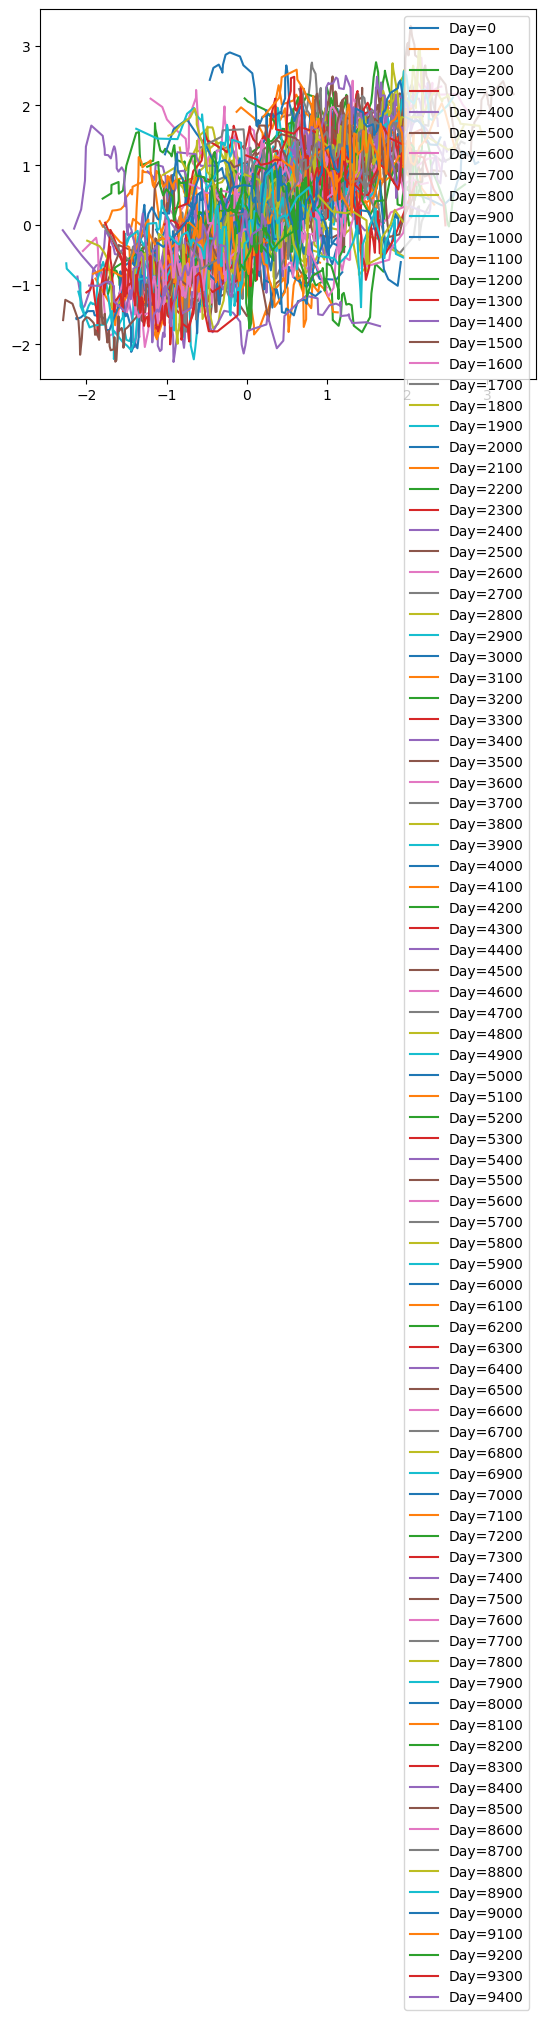

In [39]:
######################################################################################################
a = 0 
# k = 0
# time = np.arange(0,9500)
plt.figure()
for k in range(PC1_window.shape[1]):
    # print(k)
    i = k*window_length
    plt.plot(np.sort(PC1_all[a,i:i+window_length]), PC1_window[a,k,:], label=f"Day={i}")
plt.legend()


# print(np.mean(u[a, i:int(i+100),5,42:,:], axis=(0,2)).shape)
# plt.hist(pdf[a,k,:], bins=20)
# plt.hist(np.mean(u[a, i:int(i+100),5,42:,:], axis=(0,2)),pdf[a,k,:], bins=10, density=True)

# plt.plot(time, pdf[a,k,:])


# print(np.mean(u[a, i:int(i+100),5,:,:], axis=(0,2)).shape)
# print(pdf[a,k,:].shape)

## cal autocorrelation error bar

In [98]:
"""
Step 1. Cal dof (degree of freedom) with equation Martin et al. 1999:
        with whole length of PC1 (NOT need to divide)
        N* = N * ( (1-r) / (1+r) )
        N = 9500, when tau = 0
        N = 9499, when tau = 1 
        .
        .
        .
       
Step 2. cal autocorrelation of whole length of PC1

Step 3. with autocorrelation and dof => cal error bar each tau
"""

'\nStep 1. Cal dof (degree of freedom) with equation Martin et al. 1999:\n        with whole length of PC1 (NOT need to divide)\n        N* = N * ( (1-r) / (1+r) )\n        N = 9500, when tau = 0\n        N = 9499, when tau = 1 \n        .\n        .\n        .\n       \nStep 2. cal autocorrelation of whole length of PC1\n\nStep 3. with autocorrelation and dof => cal error bar each tau\n'

In [99]:
PC1_all.shape

(2, 9500)

In [113]:
dof_whole = cal_self_Martin_et_al_1999(PC1_all.shape[1], PC1_all[0,:])
dof2_whole = cal_self_Martin_et_al_1999(PC1_all.shape[1], PC1_all[1,:])


In [122]:
tau_whole = np.linspace(0,9500,9500)
yyy_thin_whole  = autocorr1(PC1_all[0], 9500)
yyy2_thin_whole = autocorr1(PC1_all[1], 9500)


/home/kaichiht/miniconda3/envs/jupyter_git/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/kaichiht/miniconda3/envs/jupyter_git/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/kaichiht/miniconda3/envs/jupyter_git/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


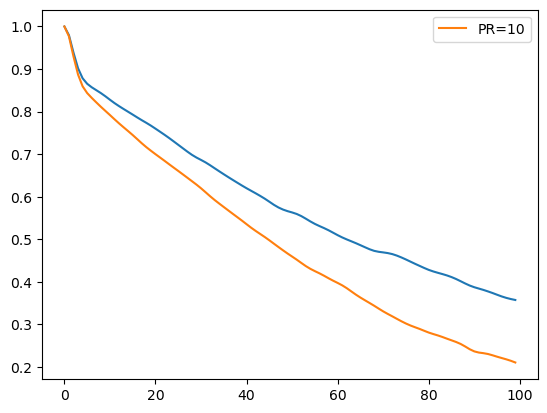

In [126]:
plt.figure()
plt.plot(tau_whole[:100], yyy_thin_whole[:100])
plt.plot(tau_whole[:100], yyy2_thin_whole[:100], label="PR=10")
plt.legend()

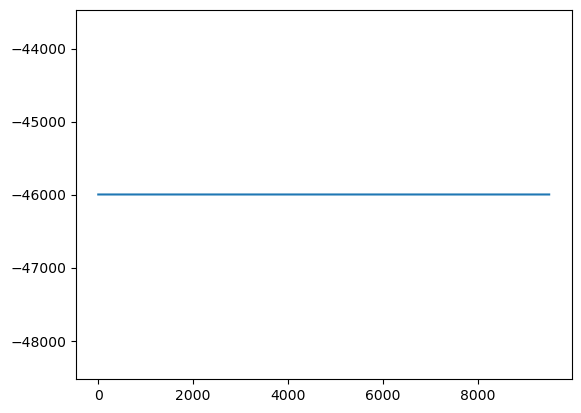

In [1]:
# plt.plot(tau_whole, yyy_thin_whole)
std1 = np.nanstd(yyy_thin_whole[:100], ddof=1)
yerror_all  = np.nanstd(yyy_thin_whole[:100]) / np.sqrt(dof_whole[:100])
yerror2_all = np.nanstd(yyy2_thin_whole[:100]) / np.sqrt(dof2_whole[:100])

print(yerror_all.shape)
plt.errorbar(tau_whole[:100], yyy_thin_whole[:100], yerr=yerror_all, capsize=4, elinewidth=2)
plt.errorbar(tau_whole[:100], yyy2_thin_whole[:100], yerr=yerror2_all, capsize=4, elinewidth=2)



NameError: name 'np' is not defined

In [120]:
dof_whole

array([15844.40853752, 15844.40853752, 15844.40853752, ...,
       15844.40853752, 15844.40853752, 15844.40853752])

## cross correlation

In [ ]:
def crosscorr(x,y,lags):
    corr = np.zeros(int(lags*2+1))
    a = 0
    for l in range(-lags,lags+1):
        if l == 0:
            corr[a] = np.corrcoef(x[:],y[:])[0][1]
        # elif l < 0:
        #     corr[a] = np.corrcoef(x[-l:],y[:l])[0][1]
        # elif l > 0:
        #     corr[a] = np.corrcoef(x[:-l],y[l:])[0][1]
        elif l < 0:
            corr[a] = np.corrcoef(x[-l:],y[:l])[0][1]
        elif l > 0:
            corr[a] = np.corrcoef(x[:-l],y[l:])[0][1]
        a += 1
    return np.array(corr)

In [ ]:
test = np.corrcoef(PC1_all[0,-100:],PC2_all[0,:100])
print(test)


In [ ]:
auto_length = 50
yyy_thin  = crosscorr(PC1_all[0,:],PC2_all[0,:], auto_length) 
yyy2_thin = crosscorr(PC1_all[1,:],PC2_all[1,:], auto_length) 
yyy3_thin = crosscorr(PC1_all[2,:],PC2_all[2,:], auto_length) 
yyy4_thin = crosscorr(PC1_all[3,:],PC2_all[3,:], auto_length) 
yyy5_thin = crosscorr(PC1_all[4,:],PC2_all[4,:], auto_length) 
yyy6_thin = crosscorr(PC1_all[5,:],PC2_all[5,:], auto_length) 

In [ ]:
tau.shape

In [ ]:
tau = np.arange(-auto_length,auto_length+1,1)
fig, ax = plt.subplots(1,figsize=(8,5),dpi=300)
plt.plot(tau, -yyy_thin , label=f"PR={pr_start}", color=colors[0])
plt.plot(tau, yyy2_thin , label=f"PR={pr_start+pr_leap}", color=colors[1])
plt.plot(tau, -yyy3_thin, label=f"PR={pr_start+pr_leap*2}", color=colors[2])
plt.plot(tau, -yyy4_thin , label=f"PR={pr_start+pr_leap*3}", color=colors[3])
plt.plot(tau, yyy5_thin , label=f"PR={pr_start+pr_leap*4}", color=colors[4])
plt.plot(tau, yyy6_thin , label=f"PR={pr_start+pr_leap*5}", color=colors[5])
plt.legend()
# ax[0].set_xlim([-auto_length,0])
# ax[0].set_title("Original grid PC1 500-2900 day -> EOF, PC ->  autocorrelation")
plt.title("U Original grid PC1" + f" {start}-{end}"+"day $C_{Z_{1}Z_{2}}$")
plt.xticks(np.arange(-50,60,10))
# plt.yticks(np.arange(-0.1,0.16,0.1))

plt.xlabel(r"$\tau$")
plt.grid()
# plt.savefig("dCz1z2dtau.png", dpi=300., bbox_inches="tight")


## tau-test

In [ ]:
yyy_thin2[1]

In [ ]:
plt.figure(figsize=(8,6), dpi=300)
total_pr = int(total_pr)
length = 100
total_L_final = np.zeros(total_pr)
total_L = np.zeros((total_pr,length))
aa  = 0
for pr in range(pr_start, pr_to, pr_leap):
    for i in range(1,len(total_L[aa,:])):
        if aa == 0:
            total_L[aa,i]      = np.log(yyy_thin[i])/int(i)
        elif aa == 1:
            total_L[aa,i]      = np.log(yyy2_thin[i])/int(i)
        elif aa == 2:
            total_L[aa,i]      = np.log(yyy3_thin[i])/int(i)
        elif aa == 3:
            total_L[aa,i]      = np.log(yyy4_thin[i])/int(i)
        elif aa == 4:
            total_L[aa,i]      = np.log(yyy5_thin[i])/int(i)
        elif aa == 5:
            total_L[aa,i]      = np.log(yyy6_thin[i])/int(i)
            
        total_L_final[aa] += total_L[aa,i] 
    total_L_final[aa] /= len(total_L[aa,1:])
    plt.plot(total_L[aa,1:], label=f"PR={aa*pr_leap}", color=colors[int(pr/pr_leap)], lw=2)
    plt.legend()
    print(f"PR={aa*10},a=", np.exp(total_L_final[aa]))
    aa += 1
plt.title(f"{start}~{end}day" + r" $dlog(C_{z_{1}z_{1}}) / d\tau$", fontsize=16)
plt.xlabel(r"$\tau $", fontsize=12)
# plt.xticks(np.arange(0,length-1), np.arange(1,length), fontsize=12)
plt.xlim([0,100])
plt.grid()
# plt.savefig("dCz1z1dtau.png", dpi=600.)
plt.show()

In [ ]:
np.exp(total_L_final)

## Red noise

In [ ]:
# Calculate power spectrum
def calc_power_spectrum_NOTME(signal, chunk_size = 80):
    size = np.floor(chunk_size  / 2).astype(int)
    ck   = fft(signal)
    freq = fftfreq(len(signal))
    sp   = 2 * ck * ck.conj() / len(signal)**2
    return freq[:size], sp[:size]

In [ ]:
# red noise model
def time_integral(x: float, a: float, e: float):
    return np.dot(a, x) + e
    
def calc_noise(A, size = 10000):
    sigma       = np.sqrt(1 - A**2)
    white_noise = np.random.normal(0, sigma, size = size)
    noise       = np.random.choice(white_noise)
    return noise
    
def create_red_noise(a, integrate_time = 10000):
    red    = np.zeros(integrate_time)
    red[0] = np.random.normal(0, 1)
    for i in range(integrate_time - 1):
        noise    = calc_noise(a)
        red[i+1] = time_integral(red[i], a, noise)
    return red

def create_red_noise_sample(red_noise, chunk_size, chunk_num, integrate_time = 10000):
    red = np.zeros((chunk_num, chunk_size)) # [20,80]
    for sample in range(chunk_num):
        # randomly select window 
        pos = random.choice(np.arange(0,(integrate_time - chunk_size)))
        # pos = int(pos)
        red[sample,:] = red_noise[int(pos):int(pos+chunk_size)]
        red[sample,:] /= red[sample,:].std()
    return red


In [ ]:
### To do confidence interval
A     = np.zeros(total_pr)
a = 0
integrate_time = 10000
red_noise = np.zeros((total_pr, integrate_time))

for pr in range(pr_start, pr_to, pr_leap):
    if pr == pr_start:
        A[a]  = np.exp(total_L_final)[0]
    elif pr == pr_start+pr_leap:
        A[a]  = np.exp(total_L_final)[1]
    elif pr == pr_start+pr_leap*2:
        A[a]  = np.exp(total_L_final)[2]
    elif pr == pr_start+pr_leap*3:
        A[a]  = np.exp(total_L_final)[3]
    elif pr == pr_start+pr_leap*4:
        A[a]  = np.exp(total_L_final)[4]
    elif pr == pr_start+pr_leap*5:
        A[a]  = np.exp(total_L_final)[5]
        
    # sigma =  np.sqrt(1 - A[a]**2)
    
    red_noise[a,0] = np.random.normal(0, 1)
    for i in range(integrate_time-1):
        noise = calc_noise(A[a])
        red_noise[a,i+1] = time_integral(red_noise[a,i], A[a], noise) # (6,10000) 
    print(a)
    a += 1
print("done")
    

In [ ]:
total_L_final

In [ ]:
print(A)
plt.figure()
plt.plot(red_noise[-1,:])
print(red_noise[-1,].std())
print(red_noise[:,0])

In [ ]:
# Calculate power spectrum
def calc_power_spectrum(signal, chunk_size = 80):
    # Since fft would calculate negative frequency, 
    # size variable determine the length of return fft
    size = np.floor(chunk_size / 2).astype(int)

    # fft return coefficient * number of grid
    ak   = fft(signal) / len(signal)
    freq = fftfreq(len(signal))

    # Base on the equations below
    ak[:size]      *= 2
    ak.imag[:size] *= -1
    sp   =  (ak.real**2 + ak.imag**2)
    return (freq[:size]), sp[:size]

In [ ]:
import random
from scipy.fftpack import fft,ifft,fftfreq, fftshift
import scipy.stats as stats 
test = random.sample(range(0,int(10000/80)),5)
print(test)
print(118*80)

In [ ]:
print(total_day)

In [ ]:
lg = 80
N = int(lg/2)
# judge = total_day / lg
# print(round(judge))
ensemble_size = 3000
chunk_size  = 80
red_all_window = np.zeros((((int(total_pr), ensemble_size, int(total_day/chunk_size), N))))
print(red_all_window.shape)
# Calculate every window in i loop
a = 0
sp_red_list = np.zeros(np.floor(chunk_size /2).astype(int))



sp_red_ens_mean  = np.zeros((total_pr , N))
sp_red_ens_std   = np.zeros((total_pr , N))
sp_conf_ens_high = np.zeros((total_pr , N))
sp_conf_ens_low  = np.zeros((total_pr , N))
sp_theoretical   = np.zeros((total_pr , N))

# red_new = np.zeros(red.shape)
for pr in range(pr_start, pr_to, pr_leap):
    # standardized red_noise [6,10000]
    # red_noise[a] = (red_noise[a] - red_noise[a].mean())/red_noise[a].std()
    
    # Do ensemble loop
    for ens in range(ensemble_size):
        # randomly select 20 windows in red to cal red noise 
        red = create_red_noise_sample(red_noise[a], chunk_size, red_all_window.shape[2], integrate_time) # [20,80]
        
        # then take that 20 window to cal power spectrum
        for sample in range(red_all_window.shape[2]):
            freq_red, sp_red = calc_power_spectrum(red[sample]) # red [20,80] -> calc_power_spectrum -> sp_red[40]
            red_all_window[a, ens, sample,:] = sp_red #/ sp_red.sum()
    ################################################################
    # .mean(axis = 1) mean all 20 windows in each ensemble -> then cal ensemble mean and ensemble std
    # ensemble mean and confidence interval
    sp_red_ens_mean[a,:]  = red_all_window[a, :, :, :].mean(axis = 1).mean(axis = 0)
    sp_red_ens_std[a,:]   = red_all_window[a, :, :, :].mean(axis = 1).std(axis = 0)
    sp_conf_ens_high[a,:] = stats.norm.interval(0.95, sp_red_ens_mean[a,:], sp_red_ens_std[a,:])[1]
    sp_conf_ens_low[a,:]  = stats.norm.interval(0.95, sp_red_ens_mean[a,:], sp_red_ens_std[a,:])[0]

    sp_conf_ens_high[a,:] /= np.sum(sp_red_ens_mean[a,:])
    sp_conf_ens_low[a,:]  /= np.sum(sp_red_ens_mean[a,:])
    sp_red_ens_mean[a,:]  /= np.sum(sp_red_ens_mean[a,:])


    # Calculating theoretical power spectrum of red noise
    PC1_all_new = np.zeros(PC1_all.shape)
    PC1_all_new[a] = (PC1_all[a] - PC1_all[a].mean()) / PC1_all[a].std()
    freq_theoretical, sp_theoretical[a,:] = theoretical_red_noise_power_spectrum(PC1_all_new[a], A[a], chunk_size)
    sp_theoretical[a,:]   /= np.sum(sp_theoretical[a,:])
    

    print(a)
    a += 1
print("done")

In [ ]:
def theoretical_red_noise_power_spectrum(signal, A, chunk_size = 80):
    # a    = calc_a(signal, 1)
    a = A 
    size = np.floor(chunk_size / 2).astype(int)
    freq = fftfreq(chunk_size)
    sp   = (1 - a**2) / (1 + a**2 - 2 * a * np.cos(2 * np.pi * freq))
    # sp = 2*chunk_size / (1 + (freq**2) * (chunk_size**2))
    return freq[:size], sp.real[:size]

In [ ]:
import scipy.stats as stats

In [ ]:
A

In [ ]:
a = 1
plt.figure()
for pr in range(pr_start, pr_to, pr_leap):
    plt.fill_between(freq_red, sp_conf_ens_low[a,:] ,sp_conf_ens_high[a,:], color = "grey", alpha = 0.5)
    plt.plot(freq_red, sp_red_ens_mean[a,:], color = "dimgrey", linestyle = "--", label = "Bootstrapping")
    # a += 1
print((sp_conf_ens_high[a] - sp_conf_ens_low[a]).min())

In [ ]:
PC1_all_new = np.zeros((int(total_pr), int(total_day)))

for i in range(int(total_pr)):
    print(i)
    PC1_all_new[i,:] = (PC1_all[i,:] - PC1_all[i,:].mean()) / PC1_all[i,:].std()

# print(PC1_all_new.std())
# print(PC1_all_new.mean())
#########################################
# from Red noise.ipynb
lg = 80
N = int(lg/2)
judge = total_day / lg
print(round(judge))
if round(judge) == total_day / lg:
    all_window = np.zeros(((int(total_pr),int(total_day/(lg)), int(lg/2))))
else:
    all_window = np.zeros(((int(total_pr),round(judge), int(lg/2))))
    
##########################################
# Calculate every window in i loop
a = 0
chunk_size  = 80
sp_list = np.zeros(np.floor(chunk_size /2).astype(int))
for pr in range(pr_start, pr_to, pr_leap):
    print(i)
    for i in range(0, int(total_day/chunk_size), 1):
        freq, sp = calc_power_spectrum(PC1_all_new[a,i*chunk_size:(i+1)*chunk_size])
        sp_list[:] = sp / sp.sum()  # retaining the total variance in 1
        all_window[a,i,:] = sp_list 
    a += 1
    
#############################################
a = 0
# plot
fig,ax = plt.subplots(6,figsize=(5,15), dpi=100.)
for pr in range(pr_start, pr_to, pr_leap):
    # first mean all windows
    mean_all_window = np.nanmean(all_window[a,:,:], axis=0)

    # calculate area for normalized powered
    area     = np.trapz(mean_all_window) 
    area_red = np.trapz(sp_red_ens_mean[a,:])
    area_the = np.trapz(sp_theoretical[a,:])
    

    # then plot normalized power spectrum 
    ax[a].plot(freq,  mean_all_window[:]/area, label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    ax[a].fill_between(freq_red, sp_conf_ens_low[a,:]/area_red, sp_conf_ens_high[a,:]/area_red, color = "grey", alpha = 0.5)
    ax[a].plot(freq_red, sp_red_ens_mean[a,:]/area_red, color = "dimgrey", linestyle = "--", label = "Red noise")

    ax[a].plot(freq_theoretical, sp_theoretical[a]/area_the, color = "k", linestyle = ":", label = "Theoretical")
    ###################################################################################
    ax[a].set_xlabel('Cycles/day',fontsize=12)
    ax[a].set_ylabel('Normalized Power',fontsize=12)
    # ax[a].set_title("")
    print("coefficient =", np.sum(np.nanmean(all_window[a,:,:], axis=0)))
    ax[a].set_xticks(np.arange(0,0.55,0.05))
    
    ax[a].legend()
    ax[a].set_xscale('log')
    ax[a].grid()
    
    # ax[a].set_xlim([-0.005,0.25])
    ax[a].set_ylim([0,0.5])
    a+=1
plt.suptitle(f"{start} - {end} day U PC2 NH, CI = 0.95", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
# plt.savefig("Red noise Power spectrum(2000-10000 day).png", dpi=600., bbox_inches='tight')
plt.show()

In [ ]:
area

## Check meridional T

In [ ]:
print(t.shape)

In [ ]:
t_mean = np.zeros((total_pr, 32))
a = 0
for i in range(pr_start, pr_to, pr_leap):
    t_mean[a,:] = np.nanmean(t[a,:,:,32:,:], axis=(0,1,3))
    a += 1

In [ ]:
t_mean.shape

In [ ]:
a = 0
xx = np.linspace(0,90,32)
fig, ax = plt.subplots(2, figsize=(8,10),dpi=300.)
for pr in range(pr_start, pr_to, pr_leap):
    ax[0].plot(xx, t_mean[a], label=f"PR={a*10}", color=colors[int(pr/pr_leap)])
    a += 1
ax[0].legend()
ax[0].set_title("NH T using all level mean")
ax[0].grid()
### Do partial T / partial y

dtdy = np.zeros(t_mean.shape)
for a in range(total_pr):
    for i in range(1, t_mean.shape[1]-1):
        dtdy[a,i] = (t_mean[a,i+1] - t_mean[a,i-1]) / np.deg2rad(y[i+1] - y[i-1])
    dtdy[a,0] = (t_mean[a,1] - t_mean[a,0]) / np.deg2rad(y[1] - y[0])
    dtdy[a,-1] = (t_mean[a,-1] - t_mean[a,-2]) / np.deg2rad(y[-1] - y[-2])

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    ax[1].plot(xx, dtdy[a], label=f"PR={a*10}", color=colors[int(pr/pr_leap)])
    a += 1
ax[1].legend()
ax[1].set_title("NH dT/dy using all level mean")
ax[1].grid()
plt.show()


## 200 day window checking CI
    

In [ ]:
u.shape
u_6000 = u[:,:6000,:,:,:]
print(u_6000.shape)

In [ ]:
window_length = 200
u_windows     = np.zeros((((total_pr, window_length, 20, 32)))) # np.zeros((((u.shape[0], int(u.shape[1]/window_length), u.shape[2], u.shape[3], u.shape[4]))))
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    for i in range(0, u.shape[1], window_length):
        if i == 0:
            u_windows[a,:,:] +=  np.nanmean(u[a,i:i+200,:,32:,:], axis=(3)) 
        else:
            aa = int(i-100)
            u_windows[a,:,:] +=  np.nanmean(u[a,aa:aa+200,:,32:,:], axis=(3)) 
    a += 1
u_windows /= int(60)
print(u_windows.shape)
print(int(u.shape[1]/window_length))

In [ ]:
print(u[-1,aa:aa+200,:,32:,:].shape)
print(aa)

In [ ]:
plt.figure()
plt.contourf(yy[:,32:], sigma_mean2[:,32:], np.mean(u_windows[0], axis=0))
plt.ylim([1,0])

a = 0
plt.figure()
for pr in range(pr_start, pr_to, pr_leap):
    plt.plot(np.mean(u_windows[a,:,5,:], axis=0), color=colors[int(pr/pr_leap)], label=f"PR={a*10}")
    a += 1
plt.legend()
plt.title("1000-8000 day 200day mean window overlap 100day (all level 5)")


In [ ]:
g = 9.81
EOF1_all = np.zeros(((int(total_pr), 20,32)))
EOF2_all = np.zeros(((int(total_pr), 20,32)))


PC1_all = np.zeros((int(total_pr), window_length)) # total_day
PC2_all = np.zeros((int(total_pr), window_length)) # total_day

explain_all = np.zeros((int(total_pr), u_windows.shape[1]))
judge_reshape = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):    
    # Step1. interpolation
    u_zy = u_windows[a] #[time, z, y] 
    # u_zy = np.nanmean(EKE[a,:,:,32:,:], axis=(3)) #[time, z, y] 
    
    cy = np.cos(np.deg2rad(y[32:]))

    
    # Step2. Do EOF
    sigma_mean      = np.nanmean(p[a,-check_days_length:,:,:,:]/ps[a,-check_days_length:,:,:,:], axis=(0,3))
    sigma_onlyz     = np.nanmean(sigma_mean, axis=1)


    u_zy_w = np.zeros(u_zy.shape)
    
    for i in range(np.shape(u_zy)[0]): 
        for j in range(np.shape(u_zy)[1]): 
                u_zy_w[i,j,:] = u_zy[i,j,:] * (cy[:])**0.5

    u_zy_w_reshape = np.reshape(u_zy_w, (np.shape(u_zy)[0], 32*20))
    single_EOF = EOF((u_zy_w_reshape,), n_components=np.shape(u_zy)[0], field="1D")
    
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs    = single_EOF.PC[0,:]
    PC2s   = single_EOF.PC[1,:]
    
    EOFs   = single_EOF.EOF[0,:]
    EOF2s  = single_EOF.EOF[1,:]

    PCs_std = PCs.std()
    PCs     = PCs / PCs_std

    PC2s_std = PC2s.std()
    PC2s     = PC2s / PC2s_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std

    EOF2s_std  = EOF2s.std()
    EOF2s      = EOF2s * PC2s_std
    
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy  = np.reshape(EOFs, (20,32))
    EOF2s_zy = np.reshape(EOF2s, (20,32))
    EOF1_all[a,:,:] = EOFs_zy
    EOF2_all[a,:,:] = EOF2s_zy
    
    PC1_all[a,:] = PCs
    PC2_all[a,:] = PC2s

    explain_all[a,:] = single_EOF.explained
    print(a)
    a += 1
print("done")

In [ ]:
fig, ax = plt.subplots(2,6, figsize=(10,4), dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    ax[0,a].contourf(yy[:,32:], sigma_mean2[:,32:], EOF1_all[a])
    ax[0,a].set_ylim([1,0])
    ax[0,a].set_title(f"EOF1 PR = {pr}", fontsize=8)

    ax[1,a].contourf(yy[:,32:], sigma_mean2[:,32:], EOF2_all[a])
    ax[1,a].set_ylim([1,0])
    ax[1,a].set_title(f"EOF2 PR = {pr}", fontsize=8)
    a+=1
plt.suptitle("U EOF 200day mean window overlap 100day (all level 5) check")
fig.tight_layout(rect=[0, 0.03, 1, 0.999])
# plt.tight_layout()
plt.show()

In [ ]:
auto_length = 100
yyy_thin  = autocorr1(PC1_all[0,:], auto_length) 
yyy2_thin = autocorr1(PC1_all[1,:], auto_length) 
yyy3_thin = autocorr1(PC1_all[2,:], auto_length) 
yyy4_thin = autocorr1(PC1_all[3,:], auto_length) 
yyy5_thin = autocorr1(PC1_all[4,:], auto_length) 
yyy6_thin = autocorr1(PC1_all[5,:], auto_length) 

yyy_thin2  = autocorr1(PC2_all[0,:], auto_length) 
yyy2_thin2 = autocorr1(PC2_all[1,:], auto_length) 
yyy3_thin2 = autocorr1(PC2_all[2,:], auto_length) 
yyy4_thin2 = autocorr1(PC2_all[3,:], auto_length) 
yyy5_thin2 = autocorr1(PC2_all[4,:], auto_length) 
yyy6_thin2 = autocorr1(PC2_all[5,:], auto_length) 

In [ ]:
tau = np.arange(0,auto_length,1)
fig, ax = plt.subplots(2,figsize=(8,10),dpi=300)
ax[0].plot(tau, yyy_thin , label="PR=0", color=colors[0])
ax[0].plot(tau, yyy2_thin, label="PR=10", color=colors[1])
ax[0].plot(tau, yyy3_thin, label="PR=20", color=colors[2])
ax[0].plot(tau, yyy4_thin, label="PR=30", color=colors[3])
ax[0].plot(tau, yyy5_thin, label="PR=40", color=colors[4])
ax[0].plot(tau, yyy6_thin, label="PR=50", color=colors[5])
ax[0].legend()
ax[0].set_xlim([0,auto_length])
# ax[0].set_title("Original grid PC1 500-2900 day -> EOF, PC ->  autocorrelation")
ax[0].set_title("U 1000-8000 day 200day mean window overlap 100day (all level 5) \n Original grid PC1 -> EOF, PC ->  autocorrelation")

ax[0].grid()

###############################################################

ax[1].plot(tau, yyy_thin2 , label="PR=0", color=colors[0])
ax[1].plot(tau, yyy2_thin2, label="PR=10", color=colors[1])
ax[1].plot(tau, yyy3_thin2, label="PR=20", color=colors[2])
ax[1].plot(tau, yyy4_thin2, label="PR=30", color=colors[3])
ax[1].plot(tau, yyy5_thin2, label="PR=40", color=colors[4])
ax[1].plot(tau, yyy6_thin2, label="PR=50", color=colors[5])
ax[1].legend()
ax[1].set_xlim([0,auto_length])
# ax[1].set_title("Original grid PC2 500-2900 day -> EOF, PC ->  autocorrelation")
ax[1].set_title("U 1000-8000 day 200day mean window overlap 100day (all level 5) \n Original grid PC2 -> EOF, PC ->  autocorrelation")

ax[1].grid()
# plt.savefig("Autocorrelation original grid PC12(1000 - 7000 day).png", dpi=300., bbox_inches="tight")
plt.show()

In [ ]:
# Calculate power spectrum
def calc_power_spectrum_mean_windows(signal, chunk_size = 50):
    # Since fft would calculate negative frequency, 
    # size variable determine the length of return fft
    size = np.floor(chunk_size / 2).astype(int)

    # fft return coefficient * number of grid
    ak   = fft(signal) / len(signal)
    freq = fftfreq(len(signal))

    # Base on the equations below
    ak[:size]      *= 2
    ak.imag[:size] *= -1
    sp   =  (ak.real**2 + ak.imag**2)
    return (freq[:size]), sp[:size]

In [ ]:
PC2_all_new = np.zeros((int(total_pr), int(window_length)))

for i in range(int(total_pr)):
    print(i)
    PC2_all_new[i,:] = (PC2_all[i,:] - PC2_all[i,:].mean()) / PC2_all[i,:].std()

# print(PC1_all_new.std())
# print(PC1_all_new.mean())
#########################################
# from Red noise.ipynb
lg = 50
N = int(lg/2)
judge = total_day / lg
print(round(judge))
if round(judge) == total_day / lg:
    all_window = np.zeros(((int(total_pr),int(window_length/(lg)), int(lg/2))))
else:
    all_window = np.zeros(((int(total_pr),round(judge), int(lg/2))))
    
##########################################
# Calculate every window in i loop
a = 0
chunk_size  = 50
sp_list = np.zeros(np.floor(chunk_size /2).astype(int))
for pr in range(pr_start, pr_to, pr_leap):
    print(i)
    for i in range(0, int(window_length/chunk_size), 1):
        freq, sp = calc_power_spectrum_mean_windows(PC2_all_new[a,i*chunk_size:(i+1)*chunk_size])
        sp_list[:] = sp / sp.sum()  # retaining the total variance in 1
        all_window[a,i,:] = sp_list 
    a += 1
#############################################
print(all_window.shape)

In [ ]:
sp_conf_ens_high = np.zeros((total_pr , all_window.shape[2]))
sp_conf_ens_low  = np.zeros((total_pr , all_window.shape[2]))
a = 0
# plot
fig,ax = plt.subplots(6,figsize=(7,24), dpi=150.)
for pr in range(pr_start, pr_to, pr_leap):
    # first mean all windows
    mean_all_window = np.nanmean(all_window[a,:,:], axis=0)

    # calculate area for normalized powered
    area     = np.trapz(mean_all_window) 
    # area_red = np.trapz(sp_red_ens_mean[a,:])

    # then plot normalized power spectrum 
    ax[a].plot(freq,  mean_all_window[:]/area, label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    ax[a].fill_between(freq, sp_conf_ens_low[a,:]/area, sp_conf_ens_high[a,:]/area, color = "grey", alpha = 0.5)
    # ax[a].plot(freq_red, sp_red_ens_mean[a,:]/area_red, color = "dimgrey", linestyle = "--", label = "Red noise")
    ###################################################################################
    ax[a].set_xlabel('Cycles/day',fontsize=12)
    ax[a].set_ylabel('Normalized Power',fontsize=12)
    # ax[a].set_title("")
    print("coefficient =", np.sum(np.nanmean(all_window[a,:,:], axis=0)))
    ax[a].grid()
    ax[a].set_xticks(np.arange(0,0.55,0.05))
    
    ax[a].legend()
    ax[a].set_xlim([-0.005,0.25])
    a+=1
plt.suptitle("1000 - 7000 day U PC2 NH, CI = 0.9", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
# plt.savefig("Red noise Power spectrum.png", dpi=300., bbox_inches='tight')
plt.show()

In [ ]:
sp_conf_ens_high

# u vertical integration -> EOF, PC -> autocorrelation

In [ ]:
import matplotlib.colors as colors
import matplotlib as mpl
# fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
# mpl.rcParams['axes.linewidth'] = 2

###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
g = 9.81


EOF1_all = np.zeros((int(total_pr),32))
EOF2_all = np.zeros((int(total_pr),32))


PC1_all = np.zeros((int(total_pr), total_day)) # total_day
PC2_all = np.zeros((int(total_pr), total_day)) # total_day

judge_reshape = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):    
    # Step1. interpolation
    u_zy = np.nanmean(u[a,:,:,32:,:], axis=(1,3)) #[time, y] 
    # u_zy = np.nanmean(EKE[a,:,:,32:,:], axis=(3)) #[time, z, y] 
    
    cy = np.cos(np.deg2rad(y[32:]))

    
    # Step2. Do EOF
    sigma_mean      = np.nanmean(p[a,-check_days_length:,:,:,:]/ps[a,-check_days_length:,:,:,:], axis=(0,3))
    sigma_onlyz     = np.nanmean(sigma_mean, axis=1)

    y_nhalf = np.linspace(0,90,32)
    yy_nhalf, sigma_mean2_nhalf = np.meshgrid(y_nhalf,sigma_onlyz)

    u_zy_w = np.zeros(u_zy.shape)
    
    for i in range(np.shape(u_zy)[0]): 
                u_zy_w[i,:] = u_zy[i,:] * (cy[:])**0.5

    u_zy_w_reshape = np.reshape(u_zy_w, (np.shape(u_zy)[0], 32))
    single_EOF = EOF((u_zy_w_reshape,), n_components=32, field="1D")
    single_EOF.get()
    
    # Step 3: PC / PC_std and EOF * PC_std
    PCs    = single_EOF.PC[0,:]
    PC2s   = single_EOF.PC[1,:]
    
    EOFs   = single_EOF.EOF[0,:]
    EOF2s  = single_EOF.EOF[1,:]

    PCs_std = PCs.std()
    PCs     = PCs / PCs_std

    PC2s_std = PC2s.std()
    PC2s     = PC2s / PC2s_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std

    EOF2s_std  = EOF2s.std()
    EOF2s      = EOF2s * PC2s_std
    
    # Step 4:
    EOFs_zy  = EOFs   
    EOF2s_zy = EOF2s 
    EOF1_all[a,:] = EOFs_zy
    EOF2_all[a,:] = EOF2s_zy
    


    PC1_all[a,:] = PCs
    PC2_all[a,:] = PC2s

    print(a)
    a += 1
print("done")

In [ ]:
fig, ax = plt.subplots(2, figsize=(8,10),dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    if pr ==0:
        control = np.max(-(EOF1_all[a,:]))
        ax[0].plot(xx, -((EOF1_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 10:
        control = np.max(-(EOF1_all[a,:]))
        ax[0].plot(xx, -((EOF1_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 20:
        control = np.max((EOF1_all[a,:]))
        ax[0].plot(xx, ((EOF1_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])

    if pr ==30:
        control = np.max((EOF1_all[a,:]))
        ax[0].plot(xx, ((EOF1_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==40:
        control = np.max(-(EOF1_all[a,:]))
        ax[0].plot(xx, -((EOF1_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==50:
        control = np.max((EOF1_all[a,:]))
        ax[0].plot(xx, ((EOF1_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    ##############################################################################################################
    
    if pr ==0:
        control = np.max(-(EOF2_all[a,:]))
        ax[1].plot(xx, -((EOF2_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 10:
        control = np.max(-(EOF2_all[a,:]))
        ax[1].plot(xx, -((EOF2_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr == 20:
        control = np.max(-(EOF2_all[a,:]))
        ax[1].plot(xx, -((EOF2_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])

    if pr ==30:
        control = np.max(-(EOF2_all[a,:]))
        ax[1].plot(xx, -((EOF2_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==40:
        control = np.max(-(EOF2_all[a,:]))
        ax[1].plot(xx, -((EOF2_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    if pr ==50:
        control = np.max(-(EOF2_all[a,:]))
        ax[1].plot(xx, -((EOF2_all[a,:])/control), label=f"pr = {a*pr_leap}", color=colors[int(pr/pr_leap)])
    
    # plt.plot(y[:], EOF1_all[a,5, :], label=f"pr = {a*pr_leap}")
    
    a += 1
ax[1].axvline(x=y_pr0_vertical_average, color='gray', lw=0.8)
ax[1].axhline(y=1, color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].legend()
ax[1].set_title("EOF2(u)")
ax[0].grid()
plt.suptitle("EOF (using all levels integration)", fontsize=16)
plt.tight_layout()
plt.show()


## autocorrelation

In [ ]:
auto_length = 100
yyy_thin  = autocorr1(PC1_all[0,:], auto_length) 
yyy2_thin = autocorr1(PC1_all[1,:], auto_length) 
yyy3_thin = autocorr1(PC1_all[2,:], auto_length) 
yyy4_thin = autocorr1(PC1_all[3,:], auto_length) 
yyy5_thin = autocorr1(PC1_all[4,:], auto_length) 
yyy6_thin = autocorr1(PC1_all[5,:], auto_length) 

yyy_thin2  = autocorr1(PC2_all[0,:], auto_length) 
yyy2_thin2 = autocorr1(PC2_all[1,:], auto_length) 
yyy3_thin2 = autocorr1(PC2_all[2,:], auto_length) 
yyy4_thin2 = autocorr1(PC2_all[3,:], auto_length) 
yyy5_thin2 = autocorr1(PC2_all[4,:], auto_length) 
yyy6_thin2 = autocorr1(PC2_all[5,:], auto_length) 

In [ ]:
tau = np.arange(0,auto_length,1)
fig, ax = plt.subplots(2,figsize=(8,10),dpi=300)
ax[0].plot(tau, yyy_thin , label="PR=0", color=colors[0])
ax[0].plot(tau, yyy2_thin, label="PR=10", color=colors[1])
ax[0].plot(tau, yyy3_thin, label="PR=20", color=colors[2])
ax[0].plot(tau, yyy4_thin, label="PR=30", color=colors[3])
ax[0].plot(tau, yyy5_thin, label="PR=40", color=colors[4])
ax[0].plot(tau, yyy6_thin, label="PR=50", color=colors[5])
ax[0].legend()
ax[0].set_xlim([0,auto_length])
# ax[0].set_title("Original grid PC1 500-2900 day -> EOF, PC ->  autocorrelation")
ax[0].set_title("U vertical integration PC1 1000-5500 day -> EOF, PC ->  autocorrelation")

ax[0].grid()

###############################################################

ax[1].plot(tau, yyy_thin2 , label="PR=0", color=colors[0])
ax[1].plot(tau, yyy2_thin2, label="PR=10", color=colors[1])
ax[1].plot(tau, yyy3_thin2, label="PR=20", color=colors[2])
ax[1].plot(tau, yyy4_thin2, label="PR=30", color=colors[3])
ax[1].plot(tau, yyy5_thin2, label="PR=40", color=colors[4])
ax[1].plot(tau, yyy6_thin2, label="PR=50", color=colors[5])
ax[1].legend()
ax[1].set_xlim([0,auto_length])
# ax[1].set_title("Original grid PC2 500-2900 day -> EOF, PC ->  autocorrelation")
ax[1].set_title("U vertical integration PC2 1000-5500 day -> EOF, PC ->  autocorrelation")

ax[1].grid()
# plt.savefig("Autocorrelation original grid PC12(500 - 2900 day).png", dpi=300., bbox_inches="tight")
plt.show()

# Red noise

In [ ]:
from scipy.fftpack import fft,ifft,fftfreq, fftshift

In [ ]:
a = 0
PC1_covariance = np.cov(PC1_all_thin[a])
print(PC1_covariance)

In [ ]:
print(PC1_all_thin[a].shape)
lg = 80
N = int(lg/2)
judge = total_day / lg
print(round(judge))
if round(judge) == total_day / lg:
    all_window = np.zeros(((int(total_pr),int(total_day/lg), int(lg))), dtype=np.complex_)
else:
    all_window = np.zeros(((total_pr,round(judge), int(lg))), dtype=np.complex_)
    
print(int(total_day/lg))
    

print(all_window.shape)
# print(13*80)
# print(int(total_day/lg))

In [ ]:
print(PC1_all_thin.shape[1])

a = 1
PC1_all_thin_new = np.zeros(PC1_all_thin.shape)
PC1_all_thin_new[a] = (PC1_all_thin[a] - PC1_all_thin[a].mean()) / PC1_all_thin[a].std()
print(PC1_all_thin_new[a].mean())
print(PC1_all_thin_new[a].std())
l = 0
Max_mode = int(lg/2)

for i in range(0 , PC1_all_thin_new.shape[1], lg):
    print(i)
    yf      = fft(PC1_all_thin_new[a,i:i+lg])  / len(PC1_all_thin_new[a,i:i+lg])
    #將傅立葉變換ak轉換成bk、ck
    yf[:] *= 2
    yf[:].imag *= -1
    all_window[a,int(l),:] =  (yf[:].real**2 + yf[:].imag**2)
    # print(lg)
    l += 1
#################################################################################
PC1_all_thin_new[a].std()
plt.figure()
N = yf.shape[0]
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
for i in range(all_window.shape[1]):
    yf    = all_window[a,i,:] # fft(all_window[a,0,:]) / len(fft(all_window[a,0,:]))
    yplot = fftshift(yf)
    plt.plot(xf[Max_mode:],  (yplot)[Max_mode:], label=f"{i}th window")
plt.legend()

plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("80 days window PC1 U fft")
########################################################################
for i in range(all_window.shape[1]):
    mean_all_win += (all_window[a,i,:])
mean_all_win /= 20

Max_mode = int(N/2)
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
yplot = fftshift(mean_all_win)
print(yplot.shape)

plt.figure(dpi=100.)
plt.plot(xf[Max_mode:],  np.abs(yplot)[Max_mode:])
plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("All 80 days window average PC1 U fft")

print("coefficient =", np.sum(np.nanmean(all_window[a,:,:], axis=1)))
# plt.xlim([0,0.25])

In [ ]:
print(PC1_all_thin.shape[1])

a = 1
PC1_all_thin_new = np.zeros(PC1_all_thin.shape)
PC1_all_thin_new[a] = (PC2_all_thin[a] - PC2_all_thin[a].mean()) / PC2_all_thin[a].std()
print(PC1_all_thin_new[a].mean())
print(PC1_all_thin_new[a].std())
l = 0
Max_mode = int(lg/2)

for i in range(0 , PC1_all_thin_new.shape[1], lg):
    print(i)
    yf      = fft(PC1_all_thin_new[a,i:i+lg])  / len(PC1_all_thin_new[a,i:i+lg])
    #將傅立葉變換ak轉換成bk、ck
    yf[:] *= 2
    yf[:].imag *= -1
    all_window[a,int(l),:] =  (yf[:].real**2 + yf[:].imag**2)
    # print(lg)
    l += 1
#################################################################################
PC1_all_thin_new[a].std()
plt.figure()
N = yf.shape[0]
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
for i in range(all_window.shape[1]):
    yf    = all_window[a,i,:] # fft(all_window[a,0,:]) / len(fft(all_window[a,0,:]))
    yplot = fftshift(yf)
    plt.plot(xf[Max_mode:],  (yplot)[Max_mode:], label=f"{i}th window")
plt.legend()

plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("80 days window PC2 U fft")
########################################################################
for i in range(all_window.shape[1]):
    mean_all_win += (all_window[a,i,:])
mean_all_win /= 20

Max_mode = int(N/2)
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
yplot = fftshift(mean_all_win)
print(yplot.shape)

plt.figure(dpi=100.)
plt.plot(xf[Max_mode:],  np.abs(yplot)[Max_mode:])
plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("All 80 days window average PC2 U fft")

print("coefficient =", np.sum(np.nanmean(all_window[a,:,:], axis=1)))
# plt.xlim([-1,10])

## EKE PC red noise

In [ ]:
a = 0
Vzm = np.nanmean(v[a], axis=3)
Uzm = np.nanmean(u[a], axis=3)
Vza     = np.zeros(u.shape)
Uza     = np.zeros(u.shape)

for i in range(0,128):
    Vza[a,:,:,:,i]     = v[a,:,:,:,i] - Vzm
    Uza[a,:,:,:,i]     = u[a,:,:,:,i] - Uzm
M = (0.5*Uza**2 * Vza**2)
Mzm = np.nanmean(M, axis=(4))
for i in range(Mzm.shape[1]):
    for j in range(Mzm.shape[2]):
        Mzm[a,i,j,:] = cy[:]**0.5 * Mzm[a,i,j,:]

In [ ]:
print(Mzm.shape)

In [ ]:
fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(6,10), dpi=300.)

check_days_length = int(end - start)

EOF1_all = np.zeros(((int(total_pr), 20, 10)))
EOF2_all = np.zeros(((int(total_pr), 20, 10)))

PC1_all = np.zeros((int(total_pr), total_day))
PC2_all = np.zeros((int(total_pr), total_day))


judge = total_day - (u.shape[2] * u.shape[3])/2
if judge >0:
    n_component = int((u.shape[2] * u.shape[3])/2)
else:
    n_component = total_day
explain_all = np.zeros((int(total_pr), 10))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    sigma_mean      = np.nanmean(p[a,-check_days_length:,:,:,:]/ps[a,-check_days_length:,:,:,:], axis=(0,3))
    sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
    y               = np.linspace(-90,90,64)
    yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

    y_nhalf = np.linspace(0,90,32)
    yy_nhalf, sigma_mean2_nhalf = np.meshgrid(y_nhalf,sigma_onlyz)

    # u_nhalf = u[:,:,:,32:,:] 
    # u_nhalf_w = np.zeros(u_nhalf.shape)
    # # for i in range(np.shape(u)[1]): 
    # #     for j in range(np.shape(u)[2]):
    # #         for k in range(np.shape(u)[4]):
    # #             u_nhalf_w[a,i,j,:,k] = u_nhalf[a,i,j,:,k] * (cy[32:])**0.5
    # for i in range(32): # cy[0] and [-1] are np.nan
    #     u_nhalf_w[a,:,:,i,:] = u_nhalf[a,:,:,i,:] * (cy[i+32])**0.5
    
    # u_zy = np.nanmean(Mzm[a,:,:,:,:], axis=(3))
    t_mean = np.nanmean(t, axis=4)
    u_zy_reshape = np.reshape(t_mean[a,:,4,45:55], (np.shape(t_mean[a])[0], 10))
    print(u_zy_reshape.shape)
    # Step 2: do EOF of u

        
    single_EOF = EOF((u_zy_reshape,), n_components=10, field="1D")
    single_EOF.get()
    # Step 3: PC / PC_std and EOF * PC_std
    PCs    = single_EOF.PC[0,:]
    PC2s   = single_EOF.PC[1,:]
    
    EOFs   = single_EOF.EOF[0,:]
    EOF2s  = single_EOF.EOF[1,:]
    
    PCs_std = PCs.std()
    PCs     = PCs / PCs_std

    PC2s_std = PC2s.std()
    PC2s     = PC2s / PC2s_std
    
    EOFs_std  = EOFs.std()
    EOFs      = EOFs * PCs_std

    EOF2s_std  = EOF2s.std()
    EOF2s      = EOF2s * PC2s_std
    
    # Step 4: reshape (1280,) back to (20,64)
    EOFs_zy  = np.reshape(EOFs, (10))
    EOF2s_zy = np.reshape(EOF2s, (10))
    
    EOF1_all[a,:,:] = EOFs_zy
    EOF2_all[a,:,:] = EOF2s_zy

    PC1_all[a,:] = PCs
    PC2_all[a,:] = PC2s
    
    # Step 5: plot
    # CS = ax[a].contourf(yy_nhalf, sigma_mean2_nhalf, EOFs_zy, levels=21, cmap="bwr", extend="both")
    # fig.colorbar(CS, ax=ax[a], extend="both")
    # ax[a].set_ylim([1,0])
    # ax[a].set_title(f"PR{pr} EOF [EKE]", fontsize=14)
    # ax[a].set_ylabel("sigma")
    # ax[-1].set_xlabel("latitude")

    # CT = ax[a].contour(yy_nhalf, sigma_mean2_nhalf, np.nanmean(u[a,:,:,32:,:], axis=(0,3)), colors='k', levels=np.arange(-20,50,10))
    # plt.clabel(CT)
    # get explained 
    explain_all[a] = single_EOF.explained
    a += 1
    
fig.tight_layout()
# plt.savefig("check_U_EOF.png", dpi=300., bbox_inches='tight')
plt.show()

In [ ]:
print(PC1_all_thin.shape[1])

a = 0
PC1_all_thin_new = np.zeros(PC1_all_thin.shape)
PC1_all_thin_new[a] = (PC1_all_thin[a] - PC1_all_thin[a].mean()) / PC1_all_thin[a].std()
print(PC1_all_thin_new[a].mean())
print(PC1_all_thin_new[a].std())
l = 0
Max_mode = int(lg/2)

for i in range(0 , PC1_all_thin_new.shape[1], lg):
    print(i)
    yf      = fft(PC1_all_thin_new[a,i:i+lg])  / len(PC1_all_thin_new[a,i:i+lg])
    #將傅立葉變換ak轉換成bk、ck
    yf[:] *= 2
    yf[:].imag *= -1
    all_window[a,int(l),:] =  (yf[:].real**2 + yf[:].imag**2)
    # print(lg)
    l += 1
#################################################################################
PC1_all_thin_new[a].std()
plt.figure()
N = yf.shape[0]
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
for i in range(all_window.shape[1]):
    yf    = all_window[a,i,:] # fft(all_window[a,0,:]) / len(fft(all_window[a,0,:]))
    yplot = fftshift(yf)
    plt.plot(xf[Max_mode:],  (yplot)[Max_mode:], label=f"{i}th window")
plt.legend()

plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("80 days window PC1 EKE fft")
########################################################################
for i in range(all_window.shape[1]):
    mean_all_win += (all_window[a,i,:])
mean_all_win /= 20

Max_mode = int(N/2)
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
yplot = fftshift(mean_all_win)
print(yplot.shape)

plt.figure(dpi=100.)
plt.plot(xf[Max_mode:],  np.abs(yplot)[Max_mode:])
plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("All 80 days window average PC1 EKE fft")

print("coefficient =", np.sum(np.nanmean(all_window[a,:,:], axis=1)))
# plt.xlim([-1,10])

In [ ]:
print(PC1_all_thin.shape[1])

a = 1
PC1_all_thin_new = np.zeros(PC1_all_thin.shape)
PC1_all_thin_new[a] = (PC2_all_thin[a] - PC2_all_thin[a].mean()) / PC2_all_thin[a].std()
print(PC1_all_thin_new[a].mean())
print(PC1_all_thin_new[a].std())
l = 0
Max_mode = int(lg/2)

for i in range(0 , PC1_all_thin_new.shape[1], lg):
    print(i)
    yf      = fft(PC1_all_thin_new[a,i:i+lg])  / len(PC1_all_thin_new[a,i:i+lg])
    #將傅立葉變換ak轉換成bk、ck
    yf[:] *= 2
    yf[:].imag *= -1
    all_window[a,int(l),:] =  (yf[:].real**2 + yf[:].imag**2)
    # print(lg)
    l += 1
#################################################################################
PC1_all_thin_new[a].std()
plt.figure()
N = yf.shape[0]
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
for i in range(all_window.shape[1]):
    yf    = all_window[a,i,:] # fft(all_window[a,0,:]) / len(fft(all_window[a,0,:]))
    yplot = fftshift(yf)
    plt.plot(xf[Max_mode:],  (yplot)[Max_mode:], label=f"{i}th window")
plt.legend()

plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("80 days window PC2 EKE fft")
########################################################################
for i in range(all_window.shape[1]):
    mean_all_win += (all_window[a,i,:])
mean_all_win /= 20

Max_mode = int(N/2)
T = 1 / N
freq  = fftfreq(N, T)
xf    = fftshift(freq)
yplot = fftshift(mean_all_win)
print(yplot.shape)

plt.figure(dpi=100.)
plt.plot(xf[Max_mode:],  np.abs(yplot)[Max_mode:])
plt.xlabel('Wavenumbers',fontsize=12)
plt.ylabel('Magnitudes',fontsize=12)
plt.title("All 80 days window average PC2 EKE fft")

print("coefficient =", np.sum(np.nanmean(all_window[a,:,:], axis=1)))
# plt.xlim([-1,10])

In [ ]:
print(mean_all_win.shape)

# Autocorrelation

In [ ]:
def autocorr1(x,lags):
    corr = np.zeros(int(lags))
    for l in range(lags):
        if l == 0:
            corr[l] = 1.
        else:
            corr[l] = np.corrcoef(x[l:],x[:-l])[0][1]
    # corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in range(lags)]
    return np.array(corr)

In [ ]:
def autocorrelation(input, lags_length):
    data = input
    lags = range(lags_length)
    ''' Python only implementation '''
    
    # Pre-allocate autocorrelation table
    acorr = len(lags) * [0]
    
    # Mean
    mean = sum(data) / len(data) 
    
    # Variance
    var = sum([(x - mean)**2 for x in data]) / len(data) 
    
    # Normalized data
    ndata = [x - mean for x in data]
    
    
    # Go through lag components one-by-one
    for l in lags:
        c = 1 # Self correlation
        
        if (l > 0):
            tmp = [ndata[l:][i] * ndata[:-l][i] 
                   for i in range(len(data) - l)]
            
            c = sum(tmp) / len(data) / var
            
        acorr[l] = c
    return np.array(acorr)

In [ ]:
EOF1_all.shape

In [ ]:
# yyy  = autocorrelation(PC1_all[0], 100)
# yyy2  = autocorrelation(PC1_all[1], 100)
# yyy6  = autocorrelation(PC1_all[5], 100)



yyy  = autocorr1(PC1_all[0,:], 100) 
yyy2 = autocorr1(PC1_all[1,:], 100) 
yyy3 = autocorr1(PC1_all[2,:], 100) 
yyy4 = autocorr1(PC1_all[3,:], 100) 
yyy5 = autocorr1(PC1_all[4,:], 100) 
yyy6 = autocorr1(PC1_all[5,:], 100) 

print(yyy.shape)


In [ ]:
tau = np.linspace(0,100,100)
plt.figure()
plt.scatter(tau, yyy, label="PR=0")
plt.scatter(tau, yyy2, label="PR=10")
plt.scatter(tau, yyy3, label="PR=20")
plt.scatter(tau, yyy4, label="PR=30")
plt.scatter(tau, yyy5, label="PR=40")
plt.scatter(tau, yyy6, label="PR=50")
plt.legend()
plt.xlim([0,100])
plt.title("500-1600 day \n u(20,32) -> EOF, PC -> autocorrelation")
# plt.xlabel("$\tau $")

In [ ]:
plt.figure()
plt.plot(PC1_all[0])
plt.plot(PC1_all[1])
# plt.plot(PC1_all[2])
# plt.plot(PC1_all[3])
# plt.plot(PC1_all[4])
plt.plot(PC1_all[5])

# plt.ylim([1,0])
plt.title("PC [u]", fontsize=14)
# plt.ylabel("sigma")
plt.xlabel("Day")

# explained

In [ ]:
explain_all.shape

In [ ]:
plt.figure()
plt.plot(explain_all[0, :11], '-s', label="PR=0")
plt.plot(explain_all[1, :11], '-v', label="PR=10")
plt.plot(explain_all[2, :11], '-p', label="PR=20")
plt.plot(explain_all[3, :11], '-2', label="PR=30")
plt.plot(explain_all[4, :11], '-3', label="PR=40")
plt.plot(explain_all[5, :11], '-D', label="PR=50")


plt.legend()
plt.title("% var explained")


In [ ]:
plt.figure()
# EOFs_final = np.reshape(EOFs, (20,64))
plt.contourf(yy, sigma_mean2,EOFs_zy[:,:])
# plt.ylim([1,0])
plt.title("EOF [u]", fontsize=14)
# plt.ylabel("sigma")
# plt.xlabel("Day")
plt.ylim([1,0])

In [ ]:
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_zy.mean(axis=0), levels=21)
plt.colorbar(CS)
plt.ylim([1,0])
plt.title("original u")

In [ ]:
print(np.shape((single_EOF.EOF.T.dot(single_EOF.PC)).T))
test = np.reshape((single_EOF.EOF.T.dot(single_EOF.PC)).T, (total_day, 20*64))
test_mean = np.nanmean(test, axis=0)
test_final = np.reshape(test_mean, (20,64))
plt.figure()
CS = plt.contourf(test_final, levels=21)
plt.colorbar(CS)
plt.ylim([20,0])
plt.title("test from EOF and PC back to u")

# plot original u different PR

In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 40

do_check_u = True
fig,ax   = plt.subplots(8,figsize=(5,24), dpi=300.)
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    if do_check_u:
        u_mean = np.nanmean(u, axis=(0,3))
        CS = ax[a].contourf(yy, sigma_mean2, u_mean,levels=np.linspace(-18,36,21), extend="both")
        fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
        ax[a].set_ylim([1,0])
        ax[a].set_title(f"u wind [m/s], PR={pr}")
        ax[-1].set_xlabel("time")
        ax[a].set_ylabel("latutide")
        a += 1
if do_check_u:
    # plt.savefig("check_U_equilibrium.png", dpi=600., bbox_inches='tight')
    fig.tight_layout()
    plt.show()



# Plot different PR latitude profile u

In [ ]:
cy

In [ ]:
import matplotlib.colors as colors
import matplotlib as mpl
from scipy.interpolate import RectBivariateSpline

pr_start = 0
pr_leap = 5
pr_to = 40

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########

do_check_north_jet = True
do_check_south_jet = False
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
pr_north_idx_z = []
pr_north_idx_y = []

# Find the biggest n u wind
n = 20
biggest_n_U_z = np.zeros((pr_file, n)) 
biggest_n_U_y = np.zeros((pr_file, n))
interpolation_times = 10

for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_u:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    
    if do_check_north_jet:
        u_north_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_north_half[:,:,i,:] = u[:,:,i+32,:] * cy[i+32]**0.5
        u_zy = np.nanmean(u_north_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        pr_north_idx_y.append(j)
        pr_north_idx_z.append(k)
        # pr_idx_z_y[a,1] = j

        """
        # Becasue the grid is too coarse to identify the location of biggest u wind,
        # it would calculate the index of the biggest five u wind in the below code block.
        """
        if do_check_biggest_n_U:
            # Step 1. Do interpolation, increasing resolution third times
            interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
            yys          = np.linspace(0, 90, 32*interpolation_times)
            sigma_mean2s = np.linspace(0,  1, 20*interpolation_times)
            
            Y, Z = np.meshgrid(yys, sigma_mean2s)
            
            u_zy_thin = interp_spline(sigma_mean2s, yys)
            # Step 2. Find the biggest n U wind
            small_idx = np.dstack(np.unravel_index(np.argsort(u_zy_thin.ravel()), (np.shape(sigma_mean2s)[0], np.shape(yys)[0]))) # (1, 20*32, 2)
            biggest_n_U_z[a,:] = small_idx[0,-n:,0]
            biggest_n_U_y[a,:] = small_idx[0,-n:,1]
            
        ############################################################################
        ### plot ###
        if pr == 0:
            print("Northern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[32+j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[32:], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Northern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")
        
    if do_check_south_jet:
        u_south_half = np.zeros((((u.shape[0],20,32,128))))
        for i in range(32):
            u_south_half[:,:,i,:] = u[:,:,i,:] * cy[i]**0.5
        u_zy = np.nanmean(u_south_half, axis=(0,3))
        idx_max = np.argmax(u_zy)
        k, j = np.unravel_index(idx_max, u_zy.shape) # which mean maximum z: kth index,
                                                     #            maxumum y: jth index
        if pr == 0:
            print("Southern Hemisphere")
            control = np.nanmax(u_zy[k,:])
            ax[0,0].axvline(x=y[j], color='gray', lw=0.8)
            ax[0,0].axhline(y=0, color='gray', lw=0.8)
        print("PR:",pr,",maximum [z index, y index]:", k,j)
        
        ax[0,0].plot(y[:32], u_zy[k,:] / control, label=f"L = {pr/100}") #, color=colors[int(pr/5)]
        ax[0,0].set_title("Southern Hemisphere U", fontsize=8)
        ax[0,0].set_xlabel("latutide")

    a += 1
# plt.legend()
ax[0,0].legend(prop={'size': 8})
plt.show()

In [ ]:
print(biggest_n_U_z[0,:])
print(biggest_n_U_y[0,:])

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(10, 9), dpi=300.)
ax = ax.ravel()
a = 0
# b = 0
y_north = np.linspace(0,90,32*interpolation_times) 
z_north = np.linspace(0, 1,20*interpolation_times) 

for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    for i in range(n):
        if i == int(n-1):
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])], label=f"PR={pr}")
        else:
            ax[a].scatter(y_north[int(biggest_n_U_y[a,i])], z_north[int(biggest_n_U_z[a,i])])
            
    ax[a].set_title(f"NH PR={pr} "+f"index of the biggest {n} U wind")
    ax[a].set_ylim([0.26,0.20])
    ax[a].set_xlim([34,41])
    ax[a].set_ylabel("sigma")
    ax[a].set_xlabel("latitude")
    ax[a].legend()
    ax[a].grid()
    a += 1
plt.suptitle(f"Interpolate the resolution to {interpolation_times} times")

fig.tight_layout()

# plt.savefig("check_U_index.png", dpi=300., bbox_inches='tight')
plt.show()


In [ ]:
biggest_n_U_y[0,:]

In [ ]:
plt.figure()
a = 0
for pr in range(pr_start, pr_to, pr_leap):
# for pr in range(0, 10, 5):
    # print(pr)
    plt.scatter(y_north[int(np.nanmean(biggest_n_U_y[a,:]))], z_north[int(np.nanmean(biggest_n_U_z[a,:]))], label=f"PR={pr}")
    a+=1
plt.ylim([0.245,0.215])
plt.legend()
plt.title(f"Mean index of the biggest {n} U wind,"+f"interpolational times = {interpolation_times}") 
plt.grid()
# plt.savefig("check_mean_U_index.png", dpi=300., bbox_inches='tight')
plt.show()

# Interplotation

In [ ]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [ ]:
sigma_onlyz

In [ ]:
y[32:]

In [ ]:
u_zy.shape

In [ ]:
interp_spline = RectBivariateSpline(sigma_onlyz, y[32:], u_zy)
yys          = np.linspace(0,90,64)
sigma_mean2s = np.linspace(0,1,40)

Y, Z = np.meshgrid(yys, sigma_mean2s)

u_zy_thin = interp_spline(sigma_mean2s, yys)
# for i in range(yys.shape[0]):
#     zs[i]=f(yys[i],sigma_mean2s[i])

In [ ]:
u_zy_thin.shape

In [ ]:
plt.figure()
plt.contourf(yy[:,32:], sigma_mean2[:,32:], u_zy)
plt.title("Original: (y,z) = (32,20)")
plt.ylim([1,0])

plt.figure()
plt.title("Interpolation: (y,z) = (64,40)")
plt.contourf(Y, Z, u_zy_thin)
plt.ylim([1,0])

# Calculate error bar of the interpolation

In [ ]:
import random
import scipy.stats as st 

In [ ]:
# Null hypothesis: To test the location of maximum u wind in 80 days would be different significantly.
# 
# I have (time, z, y, x) = (800, 20, 32, 128) in each hemisphere.
# Step 1. Interpolate from (80, 20, 32) => (80, 200, 320)
# Step 2. Randomly select the index of the day of 80 days from 200-1000 day 
#         => the reason why choose 80 not 20 or 10, because it takes 25 days to do Fourier transform in Lorenz paper, and 70~80 days to do the low frequency in Nick paper.
# Step 3. From (80, 200, 320) find the each day find the biggest 10% u wind of these 80 days of y-z coordinate,
#         that is 200 * 320 * 10% = 640 indexes. (Want to circle the biggest u wind on the y-z coordinate)
# Step 4. Do mean these 640 indexes => get the single point (y,z)
# Step 5. Repeat step 2-4 1000 times => get 1000 point (y,z)
# Step 6. plot mean and confident interval

In [ ]:
def bootstrap_y(all_index, total_times, each_time, n, intepolation, y , sigma_onlyz, yys, sigma_mean2s):
    sample_idx_mean = []
    CI_low          = []
    CI_high         = []

    # biggest_n_U_z_errorbar_mean_all = np.zeros(np.shape(all_index)[0])# 640
    # biggest_n_U_y_errorbar_mean_all = np.zeros(np.shape(all_index)[0])

    biggest_n_U_z_errorbar_mean_final = np.zeros(total_times)
    biggest_n_U_y_errorbar_mean_final = np.zeros(total_times)
    selected_u_mean_total_time_y        = np.zeros(total_times)
    selected_u_mean_total_time_z        = np.zeros(total_times)
    
    #selected_u_mean_z = np.zeros(total_times)
    # Step 1. Interpolation 
    data_thin = np.zeros(((np.shape(all_index)[0], 20*intepolation, 32*intepolation)))
    
    biggest_n_U_z_errorbar = np.zeros(total_times)
    biggest_n_U_y_errorbar = np.zeros(total_times)
    # top_u_z                  = np.zeros(n)
    # top_u_y                  = np.zeros(n)

    for k in range(np.shape(all_index)[0]):
        interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], all_index[k,:,:])
        data_thin[k,:,:]       = interp_spline(sigma_mean2s, yys)


    for i in range(total_times): 
          # randomly select
          each_time_u   = np.zeros(((each_time, np.shape(data_thin)[1], np.shape(data_thin)[2])))  # randomly select each_time
          # each_time_z   = np.zeros(np.shape(all_index)[2])  # all_index  : (20, 32)each_time
          for j in range(each_time): # 80
              tmp_z  = np.zeros(int(20*32*intepolation*intepolation*n))
              tmp_y  = np.zeros(int(20*32*intepolation*intepolation*n))

              
              random_index_time  = np.random.randint(0, data_thin.shape[0]) #(20,32) (z,y)
              each_time_u[j,:,:] = data_thin[random_index_time, :, :] # (20, 32)
              small_idx_z_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  
              small_idx_y_eachtime = np.dstack(np.unravel_index(np.argsort(each_time_u[j,:,:].ravel()), ((np.shape(each_time_u[j,:,:])[0]), (np.shape(each_time_u[j,:,:])[1]))))  

              tmp_z[:] = small_idx_z_eachtime[0,-int(20*32*intepolation*intepolation*n):,0]
              tmp_y[:] = small_idx_y_eachtime[0,-int(20*32*intepolation*intepolation*n):,1]

              zz_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              yy_idx = np.zeros(int(20*32*intepolation*intepolation*n))
              for q in range(int(20*32*intepolation*intepolation*n)):
                  yy_idx[q] = yys[int(tmp_y[q])]
                  zz_idx[q] = sigma_mean2s[int(tmp_z[q])]
          
          selected_u_mean_total_time_z[i] = np.nanmean(zz_idx)
          selected_u_mean_total_time_y[i] = np.nanmean(yy_idx)

    biggest_n_U_z_errorbar = np.nanmean(selected_u_mean_total_time_z)
    biggest_n_U_y_errorbar = np.nanmean(selected_u_mean_total_time_y)

    ### Let all total_time back to lat, sigma, then calculate CI





    CI_low_mean_z, CI_high_mean_z = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_z)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_z),  
                                                  scale=st.sem(selected_u_mean_total_time_z))

    ############################################################################################
    CI_low_mean_y, CI_high_mean_y = st.t.interval(confidence=0.95, 
                                                  df=np.shape(selected_u_mean_total_time_y)[0]-1, 
                                                  loc=np.mean(selected_u_mean_total_time_y),  
                                                  scale=st.sem(selected_u_mean_total_time_y))
    
    
    return biggest_n_U_z_errorbar, biggest_n_U_y_errorbar, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y



In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 40

### fig
# y = np.linspace(-90, 90, 64)
# yy, tt = np.meshgrid(y,time)
a      = int(0)
plt.figure(figsize=(6,4), dpi=300.)

#########

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
print(total_file)
total_day = int(total_file*internal_day)

u = np.zeros((((800, 20, 64, 128))))

do_check_u_error_bar = True
a = 0
# b = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    # print(u_ini.shape)
    # b = 0
    for k in range(total_file):
        if do_check_u_error_bar:
            if k ==0:
                u[0:100,:,:,:]           = u_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]

    # Step 1. given value
    u_all_mean = np.nanmean(u, axis=(3)) # (800, 20, 32)

    # Step 2. Do interpolation, increasing resolution ten times
    interpolation_times = 10
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)
    
    # # Step 3. Do bootstrap
    total_time = 1000
    each_time = 80           # need to equal to the number of Fourier transform and wannt to see low frequency
    ### n denote to take the biggest n% in each day 
    n = 0.05
    
    selected_u_mean_z, selected_u_mean_y, CI_low_mean_z, CI_high_mean_z, CI_low_mean_y, CI_high_mean_y= bootstrap_y(u_all_mean[:,:,32:], total_time, each_time, n, interpolation_times, y , sigma_onlyz, yys, sigma_mean2s) # each_time need to eqaul to the amount of the number of Fourier transform

    
    y_error2  = CI_high_mean_y - np.nanmean(selected_u_mean_y)
    y_error   = np.nanmean(selected_u_mean_y) - CI_low_mean_y
    print(y_error, y_error2)

    z_error2  = CI_high_mean_z - np.nanmean(selected_u_mean_z)
    z_error   = np.nanmean(selected_u_mean_z) - CI_low_mean_z
    print(z_error, z_error2)
    
    print("PR:",f"{pr},\n z index:CI_high=",(CI_high_mean_z), "mean point=", np.nanmean(selected_u_mean_z),"CI_low=",(CI_low_mean_z))
    print("PR:",f"{pr},\n y index:CI_high=",(CI_high_mean_y), "mean point=", np.nanmean(selected_u_mean_y),"CI_low=",(CI_low_mean_y))
    ###########################################################
    print("===========================")
    print(f"PR={pr}:")
    print("y latitude:")
    
    print("CI high:", CI_high_mean_y)
    print("mean:   ", np.nanmean(selected_u_mean_y))
    print("CI low: ", CI_low_mean_y)
    print("===========================")
    print("z latitude:")
    print("CI high:", CI_high_mean_z)
    print("mean:   ", np.nanmean(selected_u_mean_z))
    print("CI low: ", CI_low_mean_z)
    print("===========================")
    ###############################################################
    plt.scatter( np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), label=f"PR={pr}")
    plt.errorbar(np.nanmean(selected_u_mean_y), np.nanmean(selected_u_mean_z), xerr = np.stack([[y_error], [y_error2]]), yerr = np.stack([[z_error],[z_error2]]), fmt='o', elinewidth=2, capsize=3, ms=2) # 

    a += 1
plt.gca().invert_yaxis()
plt.title(f"200-1000 day files bootstrap {total_time} times ({each_time} time each),\n take the biggest {n} (10%) u wind of {each_time} times (interpolation {interpolation_times} times)")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.legend()
plt.savefig("check_u_index_bootstrap_2percentage.png", dpi=300, bbox_inches='tight')
plt.show()



                

In [ ]:
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

plt.figure()
CS = plt.contourf(yy, sigma_mean2, np.nanmean(u,axis=(0,3)), levels=21)
plt.contour(yy, sigma_mean2, np.nanmean(u,axis=(0,3)), [34,36],colors= 'k')

plt.ylim([1,0])
plt.colorbar(CS)


In [ ]:
sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

u_new = np.mean(u, axis=(0,3))
print(20 * 64 * 0.1)
print(np.shape(u_new[0:2,32:38]))
u_new[0:10,32:44] = 0
plt.figure()
CS = plt.contourf(yy, sigma_mean2, u_new, levels=21)
plt.ylim([1,0])
plt.colorbar(CS)

In [ ]:
### 01/15 final work
### have done bootstrap function
### need to find the y index and z index using bootstrap method

# Reproduce Nick fig.1 using interpolative U

In [ ]:
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

In [ ]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
cy = np.cos(yd)

In [ ]:
# PR=0
interpolation_times = 10
yys           = np.linspace(0, 90, 32*interpolation_times)
sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)

# y_pr0 = 37.278999804075234
# z_pr0 = 0.24744279208542716
print(np.shape(yys))

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [ ]:
print(find_nearest(yys, value=y_pr0))
print(find_nearest(sigma_mean2s, value=z_pr0))


In [ ]:
pr_start = 0
pr_leap = 10
pr_to = 60

start = 500
end   = 1500
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
total_pr  = int((pr_to - pr_start) / pr_leap)
print(total_day)
print(total_pr)

In [ ]:
import matplotlib.colors as colors
import matplotlib as mpl

fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
mpl.rcParams['axes.linewidth'] = 2

###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########
do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
g = 9.81
pr_north_idx_z = []
pr_north_idx_y = []


interpolation_times = 10

EMF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EHF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
u_zy_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EKE_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    u_zy = np.nanmean(u[a], axis=(0,3))
    u_zy_thin = np.zeros((20*interpolation_times, 32*interpolation_times))


    
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)

    cyy = np.cos(np.deg2rad(yys))
    
    
    interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], u_zy[:,32:])
    u_zy_thin[:,:]         = interp_spline(sigma_mean2s, yys)
    u_zy_thin_check[a,:,:] = u_zy_thin

    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
    
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)

    #########################################################################
    ## EMF
    u_prime        = np.rollaxis((np.rollaxis(u[a], 3, 0) - np.nanmean(u[a], axis=3)), 0, 4) 
    v_prime        = np.rollaxis((np.rollaxis(v[a], 3, 0) - np.nanmean(v[a], axis=3)), 0, 4) 
    
    # u_prime_w = np.zeros(u_prime.shape)
    # v_prime_w = np.zeros(v_prime.shape)
    # # t_prime_w = np.zeros(t_prime.shape)
    
    # for i in range(total_day):
    #     for j in range(20):
    #         for k in range(128):
    #             u_prime_w[i,j,:,k] = u_prime[i,j,:,k]* cy[:]**0.5
    #             v_prime_w[i,j,:,k] = v_prime[i,j,:,k]* cy[:]**0.5
    #             # t_prime_w[i,j,:,k] = t_prime[i,j,:,k]* cy[:]**0.5
                
                
    
    Mzmtm      = np.nanmean(u_prime * v_prime, axis=(0,3))
    Mzmtm_thin = np.zeros((20*interpolation_times, 32*interpolation_times))
    
    interp_spline        = RectBivariateSpline(sigma_onlyz, y[32:], Mzmtm[:,32:])
    Mzmtm_thin[:,:]      = interp_spline(sigma_mean2s, yys)

    print("Interpolation done")
    
    Mzmtm_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        Mzmtm_thin_w[i,:] = Mzmtm_thin[i,:] * cyy[:]**0.5
    EMF_check[a,:,:] = Mzmtm_thin_w
    #########################################################################
    ## EKE
    # cal first, then interpolate.
    eddy_kinatic_energy    = 0.5 * np.nanmean((u_prime**2 + v_prime**2)**0.5, axis=(0,3))
    EKE_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    EKE_thin_check[a,:,:] = EKE_thin
    

    EKE_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        EKE_thin_w[i,:] = EKE_thin[i,:] * cyy[:]**0.5
    ###
    # for i in range(800):
    #     for j in range(128):
    #     interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    # EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    #########################################################################
    # EHF
    t_prime        = np.rollaxis((np.rollaxis(t[a], 3, 0) - np.nanmean(t[a], axis=3)), 0, 4)
    b = t_prime / np.nanmean(t[a], axis=0) * 9.81
    eddy_flux_heat      = np.nanmean(b * v_prime, axis=(0, 3))
    eddy_flux_heat_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline            = RectBivariateSpline(sigma_onlyz, y[32:], eddy_flux_heat[:,32:])
    eddy_flux_heat_thin[:,:] = interp_spline(sigma_mean2s, yys)
    
    eddy_flux_heat_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        eddy_flux_heat_thin_w[i,:] = eddy_flux_heat_thin[i,:] * cyy[:]**0.5
    EHF_check[a,:,:] = eddy_flux_heat_thin_w
    #########################################################################
    # Precipitation
    Prec = np.zeros(u.shape)
    for i in range(1,20-1):
        Prec[a,:,i,:,:] = 1/g * qv_diff[a,:,i,:,:] * (p_half[a,:,i+1,:,:] - p_half[a,:,i,:,:])
    Prec[a,:, 0,:,:] = 1/g * qv_diff[a,:, 0,:,:] * (p_half[a,:, 1,:,:] - p_half[a,:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec[a,:,:,:,:], axis=(1))
    Prec_mean_y = np.nanmean(Prec_mean, axis=(0,2))

    

    
    ### plot ###
    """
    # fig[0,0]
    """
    if pr == pr_start:
        # print("Northern Hemisphere")
        control = np.nanmax(u_zy_thin[biggest_u_z_idx,:])
        # ax[0,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    
    ax[0,0].plot(yys, u_zy_thin[biggest_u_z_idx,:] / control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)]) #
    ax[0,0].set_title("[$U_{1}$]", fontsize=12)
    """
    # fig[1,0]
    """
    if pr == pr_start:
        # print("Northern Hemisphere")
        EMF_control = np.nanmax(Mzmtm_thin_w[biggest_u_z_idx,:])

    ax[1,0].plot(yys, Mzmtm_thin_w[biggest_u_z_idx,:] / EMF_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[1,0].set_title("[$EMF_{1}$]", fontsize=12)
    """
    # fig[2,0]
    """
    if pr == pr_start:
        # print("Northern Hemisphere")
        EKE_control = np.nanmax(EKE_thin_w[biggest_u_z_idx,:])
        
    ax[2,0].plot(yys, EKE_thin_w[biggest_u_z_idx,:] / EKE_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,0].set_title("[$EKE_{1}$]", fontsize=12)
    """
    # fig[1,1]
    """
    if pr == pr_start:
        # print("Northern Hemisphere")
        EHF_control = np.nanmax(eddy_flux_heat_thin_w[biggest_u_z_idx,:])
        
    ax[1,1].plot(yys, eddy_flux_heat_thin_w[biggest_u_z_idx,:] / EHF_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[1,1].set_title("[$EHF_{1}$]", fontsize=12)
    """
    # fig[2,1]
    """
    if pr == pr_start:
        # print("Northern Hemisphere")
        EHF_control = np.nanmax(eddy_flux_heat_thin_w[biggest_u_z_idx,:])
        
    ax[2,1].plot(y[:], Prec_mean_y[:]*86400, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,1].set_title("Precipitation [mm/day]", fontsize=12)
    

    a += 1

for i in range(3):
    for j in range(2):
        ax[i,j].spines["right"].set_visible(False)
        ax[i,j].spines["top"].set_visible(False)
        ax[i,j].set_xlabel("latutide", fontsize=8)
        ax[i,j].legend()
        ax[i,j].legend(prop={'size': 8})
        
        ax[i,j].vlines(37.7551444316089, ymin=-0.25,ymax=1.25, color='gray', lw=0.8)
        ax[i,j].axhline(y=0, color='gray', lw=0.8)
        
        
        
        
mpl.rcParams['axes.linewidth'] = 1.5
        
plt.suptitle(f"Using specific levels \n (interpolate the resolution to {interpolation_times} times)")

fig.tight_layout()
# plt.savefig("Nick_fig1_PR0_50.png", dpi=300., bbox_inches='tight')
plt.show()

In [ ]:
Prec_mean_y.shape

# Nick paper fig.1 but using all level intergration

In [ ]:
import matplotlib.colors as colors
import matplotlib as mpl
# u = np.zeros((((total_day, 20, 64, 128))))
# v = np.zeros((((total_day, 20, 64, 128))))
# p = np.zeros((((total_day, 20, 64, 128))))
# ps = np.zeros((((total_day, 20, 64, 128))))
# p_half = np.zeros((((total_day, 21, 64, 128))))
# t = np.zeros((((total_day, 20, 64, 128))))
# qv_diff = np.zeros((((total_day, 20, 64, 128))))



fig, ax = plt.subplots(3, 2, figsize=(10, 9), dpi=300.)
mpl.rcParams['axes.linewidth'] = 2

y = np.linspace(-90, 90, 64)
###
### for color
rgb=([112,115,115])
rgb=np.array(rgb)/255.0
icmap=colors.ListedColormap(rgb,name='my_color')
cmap=mpl.cm.viridis

cmap_color=icmap  
# bound=[1E-4,10E-4,25E-4,50e-4,100E-4,150E-4,200E-4,250e-4]
colors = np.array([[112,115,115],[182,203,227],[89,159,218],[0,83,170],[0,4,167],[0,140,1]])/255
########


do_check_biggest_n_U = True

pr_file = int((pr_to - pr_start) / pr_leap)
a = 0
g = 9.81
pr_north_idx_z = []
pr_north_idx_y = []


interpolation_times = 10

EMF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EHF_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
u_zy_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))
EKE_thin_check = np.zeros(((pr_file, 20*interpolation_times, 32*interpolation_times)))

a = 0
for pr in range(pr_start, pr_to, pr_leap):
    # qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    # for k in range(total_file):
    #     # if k ==0:
    #     #     u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
    #     #     v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
    #     #     t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
    #     #     p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
    #     #     p_half[0:100,:,:,:]             = p_half_ini[k,:,:,:,:]
    #     #     ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
    #     #     qv_diff[0:100,:,:,:]             = qv_diff_ini[k,:,:,:,:]
            
            
            
    #     # else:
    #         u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
    #         v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
    #         t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
    #         p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
    #         p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
    #         ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
    #         qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
            
    # if pr == 0:
    #     if k ==0:
    #         p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
    #         ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
    #     else:
    #         p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
    #         ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            
    #     check_days_length = total_day
    #     sigma_mean      = np.nanmean(p[-check_days_length:,:,:,:]/ps[-check_days_length:,:,:,:], axis=(0,3))
    #     sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
    #     y               = np.linspace(-90,90,64)
    #     yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)


    u_zy = np.nanmean(u[a], axis=(0,3))
    interpolation_times = 10
    u_zy_thin = np.zeros((20*interpolation_times, 32*interpolation_times))


    
    yys           = np.linspace(0, 90, 32*interpolation_times)
    sigma_mean2s  = np.linspace(0,  1, 20*interpolation_times)

    cyy = np.cos(np.deg2rad(yys))
    
    
    interp_spline          = RectBivariateSpline(sigma_onlyz, y[32:], u_zy[:,32:])
    u_zy_thin[:,:]         = interp_spline(sigma_mean2s, yys)
    u_zy_thin_check[a,:,:] = u_zy_thin

    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
    
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)

    #########################################################################
    ## EMF
    u_prime        = np.rollaxis((np.rollaxis(u[a], 3, 0) - np.nanmean(u[a], axis=3)), 0, 4) 
    v_prime        = np.rollaxis((np.rollaxis(v[a], 3, 0) - np.nanmean(v[a], axis=3)), 0, 4) 
    
    # u_prime_w = np.zeros(u_prime.shape)
    # v_prime_w = np.zeros(v_prime.shape)
    # # t_prime_w = np.zeros(t_prime.shape)
    
    # for i in range(total_day):
    #     for j in range(20):
    #         for k in range(128):
    #             u_prime_w[i,j,:,k] = u_prime[i,j,:,k]* cy[:]**0.5
    #             v_prime_w[i,j,:,k] = v_prime[i,j,:,k]* cy[:]**0.5
    #             # t_prime_w[i,j,:,k] = t_prime[i,j,:,k]* cy[:]**0.5
                
                
    
    Mzmtm      = np.nanmean(u_prime * v_prime, axis=(0,3))
    Mzmtm_thin = np.zeros((20*interpolation_times, 32*interpolation_times))
    
    interp_spline        = RectBivariateSpline(sigma_onlyz, y[32:], Mzmtm[:,32:])
    Mzmtm_thin[:,:]      = interp_spline(sigma_mean2s, yys)

    print("Interpolation done")
    
    Mzmtm_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        Mzmtm_thin_w[i,:] = Mzmtm_thin[i,:] * cyy[:]**0.5
    EMF_check[a,:,:] = Mzmtm_thin_w
    #########################################################################
    ## EKE
    # cal first, then interpolate.
    eddy_kinatic_energy    = 0.5 * np.nanmean((u_prime**2 + v_prime**2)**0.5, axis=(0,3))
    EKE_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    EKE_thin_check[a,:,:] = EKE_thin
    

    EKE_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        EKE_thin_w[i,:] = EKE_thin[i,:] * cyy[:]**0.5
    ###
    # for i in range(800):
    #     for j in range(128):
    #     interp_spline      = RectBivariateSpline(sigma_onlyz, y[32:], eddy_kinatic_energy[:,32:])
    # EKE_thin[:,:]      = interp_spline(sigma_mean2s, yys)
    #########################################################################
    # EHF
    t_prime        = np.rollaxis((np.rollaxis(t[a], 3, 0) - np.nanmean(t[a], axis=3)), 0, 4)
    b = t_prime / np.nanmean(t[a], axis=0) * 9.81
    eddy_flux_heat      = np.nanmean(b * v_prime, axis=(0, 3))
    eddy_flux_heat_thin = np.zeros((20*interpolation_times, 32*interpolation_times))

    interp_spline            = RectBivariateSpline(sigma_onlyz, y[32:], eddy_flux_heat[:,32:])
    eddy_flux_heat_thin[:,:] = interp_spline(sigma_mean2s, yys)
    
    eddy_flux_heat_thin_w = np.zeros((20*interpolation_times, 32*interpolation_times))
    for i in range(20*interpolation_times):
        eddy_flux_heat_thin_w[i,:] = eddy_flux_heat_thin[i,:] * cyy[:]**0.5
    EHF_check[a,:,:] = eddy_flux_heat_thin_w
    #########################################################################
    # Precipitation
    Prec = np.zeros(u.shape)
    for i in range(1,20-1):
        Prec[a,:,i,:,:] = 1/g * qv_diff[a,:,i,:,:] * (p_half[a,:,i+1,:,:] - p_half[a,:,i,:,:])
    Prec[a,:, 0,:,:] = 1/g * qv_diff[a,:, 0,:,:] * (p_half[a,:, 1,:,:] - p_half[a,:, 0,:,:])
    # self.Prec[:,-1,:,:] = 1/self.g * self.qv[:,-1,:,:] * (self.p_half[:,-1,:,:] - self.p_half[:,-2,:,:])
    
    Prec_mean = np.nansum(Prec[a,:,:,:,:], axis=(1))
    Prec_mean_y = np.nanmean(Prec_mean, axis=(0,2))

    

    
    ### plot ###
    """
    # fig[0,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # control = np.nanmax(u_zy_thin[:,:], axis=0)
        # ax[0,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[0,0].vlines(37.6316129032258, ymin=-0.25,ymax=1.25, color='gray', lw=0.8)
        
        ax[0,0].axhline(y=0, color='gray', lw=0.8)
    
    ax[0,0].plot(yys, np.nanmean(u_zy_thin[:,:], axis=0), label=f"L = {pr/100}", color=colors[int(pr/pr_leap)]) #
    ax[0,0].set_title("[$U_{1}$]", fontsize=12)
    """
    # fig[1,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # EMF_control = np.nanmax(Mzmtm_thin_w[:,:], axis=0)
        ax[1,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[1,0].axhline(y=0, color='gray', lw=0.8)

    ax[1,0].plot(yys, np.nanmean(Mzmtm_thin_w[:,:], axis=0) , label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[1,0].set_title("[$EMF_{1}$]", fontsize=12)
    """
    # fig[2,0]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # EKE_control = np.nanmax(EKE_thin_w[:,:], axis=0)
        ax[2,0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[2,0].axhline(y=0, color='gray', lw=0.8)
        
    ax[2,0].plot(yys, np.nanmean(EKE_thin_w[:,:], axis=0), label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,0].set_title("[$EKE_{1}$]", fontsize=12)
    """
    # fig[1,1]
    """
    # if pr == 0:
    #     # print("Northern Hemisphere")
    #     EHF_control = np.nanmax(eddy_flux_heat_thin_w[:,:], axis=0)
    #     ax[1,1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    #     ax[1,1].axhline(y=0, color='gray', lw=0.8)
        
    # ax[1,1].plot(yys, np.nanmean(eddy_flux_heat_thin_w[:,:], axis=0) / EHF_control, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    # ax[1,1].set_title("[$EHF_{1}$]", fontsize=12)
    """
    # fig[2,1]
    """
    if pr == 0:
        # print("Northern Hemisphere")
        # EHF_control = np.nanmax(eddy_flux_heat_thin_w[biggest_u_z_idx,:])
        ax[2,1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[2,1].axhline(y=0, color='gray', lw=0.8)
        
    ax[2,1].plot(y[:], Prec_mean_y[:]*86400, label=f"L = {pr/100}", color=colors[int(pr/pr_leap)])
    ax[2,1].set_title("Precipitation [mm/day]", fontsize=12)
    

    a += 1

for i in range(3):
    for j in range(2):
        ax[i,j].spines["right"].set_visible(False)
        ax[i,j].spines["top"].set_visible(False)
        ax[i,j].set_xlabel("latutide", fontsize=8)
        ax[i,j].legend()
        ax[i,j].legend(prop={'size': 8})
        
        
mpl.rcParams['axes.linewidth'] = 1.5
        
plt.suptitle(f"All levels integration and interpolate the resolution to {interpolation_times} times")

fig.tight_layout()
# plt.savefig("Nick_fig1_PR0_50.png", dpi=300., bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
plt.plot(yys, np.nanmean(u_zy_thin[:,:], axis=0) ,label=f"L = {pr/100}", color=colors[int(pr/pr_leap)]) #


In [ ]:
EMF_check.shape
EMF_check_w = np.zeros(EMF_check.shape)
for i in range(6):
    for j in range(200):
        EMF_check_w[i,j,:] = EMF_check[i,j,:] * cyy[:]**0.5

In [ ]:
plt.figure()
for i in range(6):
    EMF_check_vertical_mean = np.nanmean(EMF_check[i,:,:], axis=0)
    print(i)
    plt.plot(yys, EMF_check_vertical_mean, label=f"PR={i*10}", color=colors[int(i)])
# plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.vlines(37.6316129032258, ymin=-5,ymax=20, color='gray', lw=0.8)

plt.axhline(y=0, color='gray', lw=0.8)
plt.legend()
plt.title("EMF using all levels vertical integration", fontsize=16)
#####################################################################
plt.figure()
for i in range(6):
    EMF_check_vertical_mean = np.nanmean(u[i,:,:], axis=0)
    print(i)
    plt.plot(yys, EMF_check_vertical_mean, label=f"PR={i*10}", color=colors[int(i)])
# plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.vlines(37.6316129032258, ymin=-5,ymax=20, color='gray', lw=0.8)

plt.axhline(y=0, color='gray', lw=0.8)
plt.legend()
plt.title("EMF using all levels vertical integration", fontsize=16)

In [ ]:
u_check = np.zeros(((6, 20, 64)))
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if k ==0:
            u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
            v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
            t[0:100,:,:,:]             = t_ini[k,:,:,:,:]
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            p_half[0:100,:,:,:]             = p_half_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
            qv_diff[0:100,:,:,:]             = qv_diff_ini[k,:,:,:,:]
            
            
            
        else:
            u[k*100:(k+1)*100,:,:,:] = u_ini[k,:,:,:,:]
            v[k*100:(k+1)*100,:,:,:] = v_ini[k,:,:,:,:]
            t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            p_half[k*100:(k+1)*100,:,:,:] = p_half_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
            qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
            
    if pr == 0:
        if k ==0:
            p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
            ps[0:100,:,:,:]             = ps_ini[k,:,:,:,:]
        else:
            p[k*100:(k+1)*100,:,:,:] = p_ini[k,:,:,:,:]
            ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
    u_check[a,:,:] = np.nanmean(u, axis=(0,3))
    a += 1
    

In [ ]:
u_check.shape

In [ ]:
yys_2d, sigma_mean2s_2d = np.meshgrid(yys, sigma_mean2s)

just_check = False
want_output_pic = True
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    mpl.rcParams['axes.linewidth'] = 1
    
    for i in range(total_pr):
        pr = i*pr_leap
        biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
        biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
        print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[i,:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{u}$", fontsize=16)
        ax[i].axhline(y=biggest_u_z, color='gray', lw=0.8)
        ax[i].axvline(x=y_pr0, color='gray', lw=0.8)
    plt.tight_layout()
    # plt.savefig("U_PR0_50.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()
    
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    mpl.rcParams['axes.linewidth'] = 1
    pr = 0 
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[int(pr/pr_leap),:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("500-1600 day $\overline{u}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_U_PR{pr_start}_{pr_to}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()


In [ ]:
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,30), dpi=100.)
    pr = 0
    for i in range(total_pr):
        pr = i*pr_leap
        biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
        biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
        print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EMF_check[i,:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{u'v'}$")
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    plt.show()
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    pr = 0
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EMF_check[int(pr/pr_leap),:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("$\overline{u'v'}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_EMF_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()


In [ ]:
##################################################################
def plot_contourf_near0_fixcolorbar(X, Y ,var_near0, aa, cbar_lim, i, j, ax, shading_levels = 9, least_levels = 4, near0white = True, my_cmap = 'coolwarm'):
    from matplotlib.colors import ListedColormap
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm
    #####
    import matplotlib.colors as colors
    a, antialiased = 1,  True
#     a, antialiased = 0.7, True
#     a, antialiased = 0.9, True
#     a, antialiased = 1, False
    
    my_cmap = plt.colormaps[my_cmap]  
    
    # create random data with cbar_lim
    rngdata = np.random.uniform(low=cbar_lim[0], high=cbar_lim[1], size=(len(Y),len(X)))
    print(np.shape(rngdata))
    # make sure the min and Max value are included
    rngdata[0,0] = cbar_lim[0]
    rngdata[-1,-1] = cbar_lim[1]
    
    # get contour levels with random data
    # cs = plt.contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)

    # i, j = 0,0
    cs = ax[i,j].contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    ax[i,j].invert_yaxis()
    
    
    auto_levels_rng = cs.levels.copy()
    plt.gca().clear()

    # cs = plt.contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    cs = ax[i,j].contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels2 = cs.levels.copy()
    #cbar = add_colorbar(cs)#plt.colorbar()
    #plt.show()

    if ~((np.min(auto_levels2) >= 0) | (np.max(auto_levels2) <= 0)):
        plt.gca().clear()
        
        try:
            cbar.remove()
        except:
            pass
        
        # check levels of both ends
        # if either end has contour levels less than 'least_levels', create custom levels
        if ((len(np.where(auto_levels2 > 0)[0]) < least_levels) | (len(np.where(auto_levels2 < 0)[0]) < least_levels)):
            # cs = plt.contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            cs = ax[i,j].contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            auto_levels1 = cs.levels.copy()
        #     plt.colorbar()
        #     plt.show()
            plt.gca().clear()
            if (len(np.where(auto_levels2 > 0)[0]) > len(np.where(auto_levels2 < 0)[0])):
                   custom_levels = np.concatenate((np.linspace(np.min(auto_levels1), 0, least_levels+1), 
                                    auto_levels2[auto_levels2 > 0]))

            else:
                   custom_levels = np.concatenate((auto_levels2[auto_levels2 < 0], 
                                               np.linspace(0,np.max(auto_levels1),least_levels+1)))

            #custom_levels = np.unique(custom_levels)
            custom_levels_bar = custom_levels
        else:

            custom_levels = auto_levels2
            custom_levels_bar = custom_levels

        # create white shading around 0
        if near0white:
            custom_lower = custom_levels[custom_levels < 0]
            dlevel_lower = custom_lower[1] - custom_lower[0]
            custom_lower_near0 = np.concatenate((custom_lower, [0 - dlevel_lower/5]))

            custom_upper = custom_levels[custom_levels > 0]
            dlevel_upper = custom_upper[1] - custom_upper[0]
            custom_upper_near0 = np.concatenate(([dlevel_upper/5 - 0] ,custom_upper))

            custom_levels_near0 = np.concatenate((custom_lower_near0, [0], custom_upper_near0))

            mycmap_lower_near0 = my_cmap(np.linspace(0, 0.5, len(custom_levels_near0[custom_levels_near0 < 0])))
            mycmap_upper_near0 = my_cmap(np.linspace(0.5, 1, len(custom_levels_near0[custom_levels_near0 >= 0])))[1:]
            all_colors = np.vstack((mycmap_lower_near0, mycmap_upper_near0))

            all_colors[np.where(custom_levels_near0 == 0)[0]] = [1, 1, 1, 1] # set to white
            all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [1, 1, 1, 1]
            
#             all_colors[np.where(custom_levels_near0 == 0)[0]] = [0.85, 0.85, 0.85, 1] # set to gray
#             all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [0.85, 0.85, 0.85, 1]

            #all_colors[:,0:3] *= a


            mycmap_near0 = colors.LinearSegmentedColormap.from_list('mycmap_near0', all_colors)

            custom_levels = custom_levels_near0
            mycmap = mycmap_near0
        else:
            mycmap = my_cmap


        norm = colors.BoundaryNorm(boundaries=custom_levels, ncolors=256)

        # cs = plt.contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        cs = ax[i,j].contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        plt.gca().invert_yaxis()
        
        ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        ax[i,j].set_title(f"PR={int(aa*10)}", fontsize=16)

#         cbar = plt.colorbar(spacing="proportional")#cbar = add_colorbar(cs, aspect=8, pad_fraction=0.8)#

#         cbar.set_ticks(custom_levels_bar)
#         ticklabs = cbar.ax.get_yticklabels()
#         cbar.ax.set_yticklabels(ticklabs, fontsize=14)
        
    #####
    return custom_levels, custom_levels_bar, cs
########################################################################

In [ ]:
### try EMF calculate outside ###
# u_prime_w = np.zeros(u.shape)
# v_prime_w = np.zeros(u.shape)
# y_outside = np.linspace(-90,90,64)
# yd_outside = np.cos(np.deg2rad(y_outside))
# for i in range(800):
#     for j in range(20):
#         for k in range(128):
#             u_prime_w[i,j,:,k] = u_prime[i,j,:,k] * yd_outside[:]**0.5
#             v_prime_w[i,j,:,k] = v_prime[i,j,:,k] * yd_outside[:]**0.5
u_prime_new = np.zeros((((800, 20, 64,128))))
for i in range(128):
    u_prime_new[:,:,:,i] = u[:,:,:,i] - np.nanmean(u, axis=3)

In [ ]:
v_prime_new = np.zeros((((800, 20, 64, 128))))
for i in range(128):
    v_prime_new[:,:,:,i] = v[:,:,:,i] - np.nanmean(v, axis=3)

In [ ]:
EMF_outside = np.nanmean(u_prime_new* v_prime_new, axis=(0,3))
print(np.shape(EMF_outside))

In [ ]:
dmdy = np.zeros((20,64))
r = 6371e3
for i in range(1,64-1):
    dmdy[:,i] = -(EMF_outside[:,i+1] - EMF_outside[:,i-1]) / (r * (yys[i+1] - yys[i-1]))
dmdy[:, 0] = -(EMF_outside[:, 1] - EMF_outside[:, 0]) / (r*(yys[ 1] - yys[ 0]))
dmdy[:,-1] = -(EMF_outside[:,-1] - EMF_outside[:,-2]) / (r*(yys[-1] - yys[-2]))

# dmdy = np.zeros((200,320))
# r = 6371e3
# for i in range(1,320-1):
#     dmdy[:,i] = -(EMF_outside[:,i+1] - EMF_outside[:,i-1]) / (r * (yys[i+1] - yys[i-1]))
# dmdy[:, 0] = -(EMF_outside[:, 1] - EMF_outside[:, 0]) / (r*(yys[ 1] - yys[ 0]))
# dmdy[:,-1] = -(EMF_outside[:,-1] - EMF_outside[:,-2]) / (r*(yys[-1] - yys[-2]))
print(dmdy.shape)

In [ ]:
yys.shape

In [ ]:
dmdy_mean =  np.nanmean(dmdy, axis=0)
plt.figure()
plt.plot(y,dmdy_mean)
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)


In [ ]:
EMF_check_w.shape

In [ ]:
plt.figure()
plt.contourf(yy, sigma_mean2, dmdy)
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.ylim([1,0])
plt.figure()
plt.contourf(yys, sigma_mean2s, EMF_check_w[0,:,:])
plt.ylim([1,0])

In [ ]:
########################### EMF try new colorbar ################

EMF_check_w = np.zeros(EMF_check.shape)
for i in range(6):
    for j in range(200):
        EMF_check_w[i,j,:] = EMF_check[i,j,:] * cyy[:]**0.5

if want_output_pic:
    # fig, ax = plt.subplots(6, figsize=(10,8), dpi=300.)
    pr = 0
    # for i in range(3):
        # for j in range(2):
        # pr = i*pr_leap
    biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
    biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
    print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
    # CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EMF_check[int(pr/pr_leap),:,:], levels=np.linspace(-16,48,21), cmap="RdBu_r", extend="both")
    # plt.title(f"PR = {pr}", fontsize=20)

    #############################################################
    aa = 0

    for i in range(3):
        for j in range(2):
            if i ==0 and j ==0:
                fig, ax = plt.subplots(3,2, figsize=(17,15), dpi=300.)
            _,custom_levels_bar,cs=plot_contourf_near0_fixcolorbar(yys, sigma_mean2s, EMF_check[int(aa),:,:], aa, cbar_lim = [-20, 90], i=i, j=j, ax=ax, my_cmap="RdBu_r") # ,my_cmap = 'BlueYellowRed'
            aa += 1

    # add colorbar to subplots without shrinking figure
    cbar_ax = plt.gcf().add_axes([0.93, 0.111, 0.015, 0.768])
    cb = plt.colorbar(mappable = cs, cax=cbar_ax, spacing="proportional")
    cb.set_ticks(custom_levels_bar)
            ############################################################
            # pr += pr_leap
    plt.suptitle("$\overline{u'v'}$ bootstrap using the strongest 0.5%", fontsize=20)
    
    
    # fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    # plt.savefig(f"05bootstrap_EMF_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    # plt.show()
########################################################### ###


In [ ]:
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    for i in range(total_pr):
        # pr = i*pr_leap
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EHF_check[i,:,:], levels=21, cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{v'b'}$")
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    plt.show()
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    pr = 0
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EHF_check[int(pr/pr_leap),:,:], levels=np.linspace(-0.04,0.66,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("$EHF_{1}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_EHF_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()

In [ ]:
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    for i in range(total_pr):
        pr = i*pr_leap
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EKE_thin_check[i,:,:], levels=np.linspace(-0.5,14,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{EKE}$")
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    plt.show()
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    pr = 0
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], EKE_thin_check[int(pr/pr_leap),:,:], levels=np.linspace(1.6,14.4,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += pr_leap
    plt.suptitle("$EKE_{1}$ bootstrap using the strongest 0.5%", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig(f"05bootstrap_EKE_PR{pr_start}_{int(pr_to-pr_leap)}.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()

In [ ]:
# fig, ax = plt.subplots(8, figsize=(5,25), dpi=100.)
for i in range(8):
    print(np.nanmax(EKE_thin_check[i,:,:]))

In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 40

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
total_pr  = int((pr_to - pr_start) / pr_leap)
print(total_day)
print(total_pr)

In [ ]:
check_05percentage = True
check_1percentage  = False
check_5percentage  = False
check_10percentage = False
if check_05percentage:
    if pr_leap ==5:
        y_pr0 = 37.53855211598746
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[2] = 0.245966425879397
        z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[4] = 0.2404396827889447
        z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[6] = 0.2302165672110553
        z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[8] = 0.21822737123115576
        z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[10] = 0.20429698492462314
        
        
    else:
        y_pr0 = 37.53855211598746
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24557165515075377
        # z_biggest_all[1] = 0.24597788944723617
        z_biggest_all[1] = 0.245966425879397
        # z_biggest_all[3] = 0.24307792085427135
        z_biggest_all[2] = 0.2404396827889447
        # z_biggest_all[5] = 0.23530527638190954
        z_biggest_all[3] = 0.2302165672110553
        # z_biggest_all[7] = 0.2208343907035176
        z_biggest_all[4] = 0.21822737123115576
        # z_biggest_all[9] = 0.2113334798994975
        z_biggest_all[5] = 0.20429698492462314

if check_1percentage:
    if pr_leap == 5:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.2504103093592965
        z_biggest_all[2] = 0.25088522298994975
        z_biggest_all[3] = 0.24788092807788945
        z_biggest_all[4] = 0.24516175408291457
        z_biggest_all[5] = 0.23950071451005026
        z_biggest_all[6] = 0.23397497644472362
        z_biggest_all[7] = 0.2242414337311558
        z_biggest_all[8] = 0.21955492305276383
        z_biggest_all[9] = 0.21416552292713567
        z_biggest_all[10] = 0.20697050879396983
    else:
        y_pr0 = 37.46854863832288
        z_biggest_all = np.zeros(total_pr)
        z_biggest_all[0] = 0.24988611809045227
        z_biggest_all[1] = 0.25088522298994975
        z_biggest_all[2] = 0.24516175408291457
        # z_biggest_all[3] = 0.23397497644472362
        # z_biggest_all[4] = 0.21955492305276383
        # z_biggest_all[5] = 0.20697050879396983
    
    
if check_10percentage:
    y_pr0 = 36.228926875979624
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.3238856163630653
    z_biggest_all[1] = 0.32541720398869345
    z_biggest_all[2] = 0.33223640625
    z_biggest_all[3] = 0.3252315201005025
    z_biggest_all[4] = 0.32447135364321605
    z_biggest_all[5] = 0.3121236958228643
    z_biggest_all[6] = 0.3052737688442211
    z_biggest_all[7] = 0.2859219904208543

if check_5percentage:
    y_pr0 = 36.5939329937304
    z_biggest_all = np.zeros(total_pr)
    z_biggest_all[0] = 0.28572386149497486
    z_biggest_all[1] = 0.2872950973618091
    z_biggest_all[2] = 0.29088036903266334
    z_biggest_all[3] = 0.2857038599246231
    z_biggest_all[4] = 0.2842567258165829
    z_biggest_all[5] = 0.27495892430904517
    z_biggest_all[6] = 0.2675492022613066
    z_biggest_all[7] = 0.252779739321608

In [ ]:
print(z_biggest_all)
print(biggest_u_z_idx)

In [ ]:
yys_2d, sigma_mean2s_2d = np.meshgrid(yys, sigma_mean2s)
fig, ax = plt.subplots(2, figsize=(10, 15), dpi=300.)

CS = ax[0].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], Mzmtm_thin_w)
ax[0].contour(yys_2d[:,:], sigma_mean2s_2d[:,:], Mzmtm_thin_w, [-0.00000001, 0.], colors='k')
plt.colorbar(CS, ax=ax[0])
ax[0].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
ax[0].axhline(y=0, color='gray', lw=0.8)
ax[0].set_ylim([1,0])
ax[0].set_title("PR = 0 [u'v']")
ax[0].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)



CS = ax[1].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_thin_zy)

plt.colorbar(CS, ax=ax[1])

ax[1].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
ax[1].axhline(y=0, color='gray', lw=0.8)
ax[1].set_ylim([1,0])
ax[1].set_title("PR = 0 u")
ax[1].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)


# plt.figure()
# CS = ax[2].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], v_thin_zy, levels=21)
# ax[2].contour(yys_2d[:,:], sigma_mean2s_2d[:,:], v_thin_zy, [-0.00000001, 0.], colors='k')
# plt.colorbar(CS, ax=ax[2])
# ax[2].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
# ax[2].axhline(y=0, color='gray', lw=0.8)
# ax[2].set_ylim([1,0])
# ax[2].set_title("PR = 0 v")
# ax[2].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)

for i in range(2):
    ax[i].set_xlabel("latitude")
    ax[i].set_ylabel("sigma")
plt.tight_layout()
plt.show()

In [ ]:
just_check = False
want_output_pic = True
if just_check:
    fig, ax = plt.subplots(total_pr, figsize=(5,25), dpi=100.)
    mpl.rcParams['axes.linewidth'] = 1
    
    for i in range(total_pr):
        pr = i*pr_leap
        biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
        biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
        print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
        CS = ax[i].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[i,:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[i])
        ax[i].set_ylim([1,0])
        ax[i].set_title(f"PR = {pr}"+" $\overline{u}$", fontsize=16)
        ax[i].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        ax[i].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
    plt.tight_layout()
    # plt.savefig("U_PR0_50.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()
    
if want_output_pic:
    fig, ax = plt.subplots(3,2, figsize=(15,17), dpi=300.)
    mpl.rcParams['axes.linewidth'] = 1
    pr = 0 
    for i in range(3):
        for j in range(2):
        # pr = i*pr_leap
            biggest_u_y, biggest_u_y_idx = find_nearest(yys, value=y_pr0)
            biggest_u_z, biggest_u_z_idx = find_nearest(sigma_mean2s, value=z_biggest_all[int(pr/pr_leap)])
            print("PR:",pr,",maximum [z index, y index]:", biggest_u_z_idx,biggest_u_y_idx)
            CS = ax[i,j].contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], u_zy_thin_check[int(pr/5),:,:], levels=np.linspace(-16,45,21), cmap="RdBu_r", extend="both")
            ax[i,j].set_ylim([1,0])
            ax[i,j].set_title(f"PR = {pr}", fontsize=20)
            ax[i,j].axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
            ax[i,j].axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
            pr += 5
    plt.suptitle("$\overline{u}$ bootstrap using the strongest 10% ", fontsize=25)
    plt.tight_layout()
    fig.colorbar(CS, ax=list(ax[2,0:2]),orientation='horizontal', fraction=0.07, pad=0.1, aspect= 35)
    plt.savefig("10percentage_U_PR0_25.png", dpi=300., bbox_inches='tight') # , facecolor='black'
    plt.show()


In [ ]:
plt.figure()
plt.plot(yys, Mzmtm_thin_w[biggest_u_z_idx,:])
plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
plt.axhline(y=0, color='gray', lw=0.8)

In [ ]:
dmdy = np.zeros((20*interpolation_times,32*interpolation_times))
r = 6371e3
for i in range(1,32*interpolation_times-1):
    dmdy[:,i] = -(Mzmtm_thin_w[:,i+1] - Mzmtm_thin_w[:,i-1]) / (r * (yys[i+1] - yys[i-1]))
dmdy[:, 0] = -(Mzmtm_thin_w[:, 1] - Mzmtm_thin_w[:, 0]) / (r*(yys[ 1] - yys[ 0]))
dmdy[:,-1] = -(Mzmtm_thin_w[:,-1] - Mzmtm_thin_w[:,-2]) / (r*(yys[-1] - yys[-2]))

In [ ]:
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], dmdy)
plt.colorbar(CS)
plt.ylim([1,0])

In [ ]:
print(np.shape(sigma_mean2s))
yys_2d, sigma_mean2s_2d = np.meshgrid(yys, sigma_mean2s)
print(np.shape(yys_2d))
plt.figure()
CS = plt.contourf(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(M, axis=(0,3)))
plt.contour(yys_2d[:,:], sigma_mean2s_2d[:,:], np.nanmean(M, axis=(0,3)), [-0.5,0])

plt.colorbar(CS)
plt.ylim([1,0])

# try

In [2]:
# read variables
from scipy.fftpack import fft,ifft,fftfreq
# file  = f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
# file  = "HSt42_0/RH80_PR0_1000day_startfrom_900day_final.dat"


# dycore = Dycore(file)
# u  = dycore.getVar("grid_u_c_xyzt")
# v  = dycore.getVar("grid_v_c_xyzt")
# t  = dycore.getVar("grid_t_c_xyzt")
# ps = dycore.getVar("grid_ps_c_xyzt")
# p  = dycore.getVar("grid_p_full_xyzt")
sigma = p / ps
sigma_mean  = np.nanmean(sigma, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
Rd = 287
cp = 1004
g = 9.81
theta      = t * (ps / p)**(Rd/cp)
H = 6800
a = 6.37122e6

NameError: name 'p' is not defined

In [ ]:
# # The edition without time mean
# def plot_V_W_50(pr):
#     # file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     file  = "HSt42_10/RH80_PR10_1000day_startfrom_900day_final.dat"

#     dycore = Dycore(file)
#     # u  = dycore.getVar("grid_u_c_xyzt")
#     v  = dycore.getVar("grid_v_c_xyzt")
#     t  = dycore.getVar("grid_t_c_xyzt")
#     ps = dycore.getVar("grid_ps_c_xyzt")
#     p  = dycore.getVar("grid_p_full_xyzt")
#     sigma = p / ps
#     sigma_mean = np.nanmean(sigma, axis=(0,3))
#     sigma_onlyz = np.nanmean(sigma_mean, axis=1)
#     Rd = 287
#     cp = 1004
#     g = 9.81
#     theta             = t * (ps / p)**(Rd/cp)
#     H = 6800
#     # p0 = 100000
#     a = 6.37122e6
    
#     # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
#     # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
#     # Z_all     = H * np.log(p0/p)
#     rho_0     = np.zeros((20,64))
#     rho_0_all = np.zeros(((100,20,64)))
#     for i in range(0,20):
#         rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
#         rho_0_all[:,i,:] = np.nanmean(p[:,i,:,:], axis=2) / np.nanmean(ps[:,0,:,:], axis=2)                  # np.exp(-Z_all[:,i,:,:]/H) 
#     omega  = (dycore.getVar("grid_w_full_xyzt"))
#     w = omega  
#     ### do dz by dz = H * ln(ps/p)
#     THzm = np.nanmean(theta, axis=(3)) ######################
#     THETAz  = np.zeros(((100,20,64))) ############ 
#     p_onlyz = np.nanmean(p, axis=(0,2,3))
#     for i in range(1,19):
#         THETAz[:,i,:] = (THzm[:,i+1,:] - THzm[:,i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1]) #########
#     THETAz[:,0,:]  = (THzm[:,1,:]  - THzm[:,0,:])  /  (p_onlyz[1] - p_onlyz[0])
#     THETAz[:,-1,:] = (THzm[:,-1,:] - THzm[:,-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
#     THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
#     Vza = np.zeros(u.shape)
#     THETAza = np.zeros(u.shape)
#     Wza = np.zeros(u.shape)
    
#     Vzm = np.nanmean(v, axis=3)
#     THzm = np.nanmean(theta, axis=3)
#     for i in range(0,128):
#         Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
#         THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
#     VTHETA = Vza * THETAza
#     VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
#     # VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
#     Wzm = np.nanmean(w, axis=3)
#     Wzmtm = np.nanmean(Wzm, axis=0)
#     Vzm = np.nanmean(v, axis=(3)) #########
    
#     # phi
#     lat   = np.linspace(-90, 90, 64)
#     phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
#     lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
#     cphi  = np.cos(phi) 
#     acphi = a * cphi

#     # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
#     vTEM_temp = rho_0_all * VTHzm / THETAz ############################################
#     vTEM_tempdz = np.zeros(((100,20,64)))
#     for i in range(1,19):
#         vTEM_tempdz[:,i,:] = (vTEM_temp[:,i+1,:] - vTEM_temp[:,i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
#     vTEM_tempdz[:,0,:]  = (vTEM_temp[:,1,:]  - vTEM_temp[:,0,:]) /  (p_onlyz[1] - p_onlyz[0])
#     vTEM_tempdz[:,-1,:] = (vTEM_temp[:,-1,:] - vTEM_temp[:,-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
#     vTEM1 = Vzm #################
#     vTEM2 = (1/rho_0_all) * vTEM_tempdz
#     vTEM  = vTEM1 - vTEM2
#     # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
#     wTEM_temp =  cphi * VTHzm / THETAz ############################################
#     wTEM_tempdphi = np.zeros(((100,20,64)))
#     for i in range(1,63):
#         wTEM_tempdphi[:,:,i] = (wTEM_temp[:,:,i+1] - wTEM_temp[:,:,i-1]) / (phi[:,i+1] - phi[:,i-1])
#     wTEM_tempdphi[:,:,0]  = (wTEM_temp[:,:,1] - wTEM_temp[:,:,0]) /  (phi[:,1]  - phi[:,0])
#     wTEM_tempdphi[:,:,-1] = (wTEM_temp[:,:,-1] - wTEM_temp[:,:,-2]) / (phi[:,-1] - phi[:,-2])
    
#     wTEM1 = Wzm ##################
#     wTEM2 = (wTEM_tempdphi) /acphi
#     wTEM = wTEM1 + wTEM2

#     return vTEM,wTEM,p, ps, Wzmtm, rho_0
# vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(10)
# print("over")


In [ ]:
pr_start = 0
pr_leap = 5
pr_to = 5
nProc = 2

start = 200
end   = 1000
internal_day = 100
total_file = int((end - start) / internal_day)
total_day = int(total_file*internal_day)
print(total_day)


qv = np.zeros((((total_day, 20, 64, 128))))
qv_diff = np.zeros((((total_day, 20, 64, 128))))
u = np.zeros((((total_day, 20, 64, 128))))
v = np.zeros((((total_day, 20, 64, 128))))
t = np.zeros((((total_day, 20, 64, 128))))
p = np.zeros((((total_day, 20, 64, 128))))
ps = np.zeros((((total_day, 20, 64, 128))))
p_half = np.zeros((((total_day, 21, 64, 128))))

### fig
y = np.linspace(-90,90,64)
time = np.linspace(start, end, total_day)
yy, tt = np.meshgrid(y,time)
a      = int(0)
# fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
#########

do_check_qv = True
do_check_KE = True
do_check_t  = False
a = 0
for pr in range(pr_start, pr_to, pr_leap):
    qv_ini, qv_diff_ini, u_ini, v_ini, t_ini, p_ini, ps_ini, p_half_ini = read_all_var(pr, start , end, internal_day, total_file) 
    for k in range(total_file):
        if do_check_qv:
            if k ==0:
                qv[0:100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[0:100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[0:100,:,:,:]       = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]      = ps_ini[k,:,:,:,:]
                p_half[0:100,:,:,:]  = p_half_ini[k,:,:,:,:]            
            else:
                qv[k*100:(k+1)*100,:,:,:]      = qv_ini[k,:,:,:,:]
                qv_diff[k*100:(k+1)*100,:,:,:] = qv_diff_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:]       = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:]      = ps_ini[k,:,:,:,:]
                p_half[k*100:(k+1)*100,:,:,:]  = p_half_ini[k,:,:,:,:]
                
        if do_check_KE:
            if k ==0:
                u[0:100,:,:,:]             = u_ini[k,:,:,:,:]
                v[0:100,:,:,:]             = v_ini[k,:,:,:,:]
                p[0:100,:,:,:]             = p_ini[k,:,:,:,:]
                ps[0:100,:,:,:]            = ps_ini[k,:,:,:,:]
            else:
                u[k*100:(k+1)*100,:,:,:]  = u_ini[k,:,:,:,:]
                v[k*100:(k+1)*100,:,:,:]  = v_ini[k,:,:,:,:]
                p[k*100:(k+1)*100,:,:,:]  = p_ini[k,:,:,:,:]
                ps[k*100:(k+1)*100,:,:,:] = ps_ini[k,:,:,:,:]
                
        if do_check_t:
            if k ==0:
                t[0:100,:,:,:]           = t_ini[k,:,:,:,:]
            else:
                t[k*100:(k+1)*100,:,:,:] = t_ini[k,:,:,:,:]
print("done")

In [ ]:
# print(vTEM.shape)
# cal zonal mean and zonal anamoly
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)

x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm  

In [ ]:
# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan

In [ ]:
u.shape

In [ ]:
### try to calculate balanced partial u partial t, which is calculated by TEM equation.
# first calculate zonal (v'q') (q is potential vorticity)
# v  = dycore.getVar("grid_v_c_xyzt")
# u  = dycore.getVar("grid_u_c_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
ps = dycore.getVar("grid_ps_c_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
Rd = 287
cp = 1004

theta = t * (ps / p)**(Rd/cp)

Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
THzm = np.nanmean(theta, axis=3)
# THvm = np.nanmean(theta, axis=1)
Pzm = np.nanmean(p, axis=3)
Tzm = np.nanmean(t, axis=3)

In [ ]:
Vzmtm  = np.nanmean(Vzm, axis=0)
Uzmtm  = np.nanmean(Uzm, axis=0)
THzmtm = np.nanmean(THzm, axis=0)
# THvmtm = np.nanmean(THvm, axis=0)
Pzmtm  = np.nanmean(Pzm, axis=0)
Tzmtm  = np.nanmean(Tzm, axis=0)

Vza     = np.zeros(u.shape)
Uza     = np.zeros(u.shape)
THETAza = np.zeros(t.shape)
Pza = np.zeros(t.shape)
Tza = np.zeros(t.shape)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
    # THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
    Pza[:,:,:,i]     = p[:,:,:,i] - Pzm
    Tza[:,:,:,i]     = t[:,:,:,i] - Tzm
    
M = Uza * Vza
Mzm = np.nanmean(M, axis=(3))

# for i in range(1,64-1):
#     Mzm[:,:,i] = cy[i]**0.5 * Mzm[:,:,i]

dmdy = np.zeros(((np.shape(u)[0],20,64)))
r = 6371e3
for i in range(1,64-1):
    dmdy[:,:,i] = -(Mzm[:,:,i+1] - Mzm[:,:,i-1]) / (r * (yd[i+1] - yd[i-1]))
dmdy[:,:, 0] = -(Mzm[:,:, 1] - Mzm[:,:, 0]) / (r*(yd[ 1] - yd[ 0]))
dmdy[:,:,-1] = -(Mzm[:,:,-1] - Mzm[:,:,-2]) / (r*(yd[-1] - yd[-2]))
print(dmdy.shape)

In [ ]:
sigma_mean      = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
# vq_yz = np.nanmean(Vza * qza, axis=(0,3))

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(dmdy, axis=0), levels= 11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$d\overline{u'v'} / dy$")

plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(Mzm, axis=0), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("$\overline{u'v'}$")

In [ ]:
x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xx,yyy = np.meshgrid(x,y)

In [ ]:
plt.figure()
KE = (u**2+v**2)**0.5
plt.contourf(xx,yyy,np.nanmean(KE[200:201,-2,:,:], axis=0))

In [ ]:
qv_diff.shape
np.max(qv_diff)

In [ ]:
plt.figure()
plt.contourf(xx,yyy,np.nanmean(qv_diff[200:201,-1,:,:], axis=0))

In [ ]:
##################################################################
def plot_contourf_near0_fixcolorbar_one_fig(X, Y ,var_near0, cbar_lim, shading_levels = 9, least_levels = 4, near0white = True, my_cmap = 'coolwarm'):
    from matplotlib.colors import ListedColormap
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm
    #####
    import matplotlib.colors as colors
    a, antialiased = 1,  True
#     a, antialiased = 0.7, True
#     a, antialiased = 0.9, True
#     a, antialiased = 1, False
    
    my_cmap = plt.colormaps[my_cmap]  
    
    # create random data with cbar_lim
    rngdata = np.random.uniform(low=cbar_lim[0], high=cbar_lim[1], size=(len(Y),len(X)))
    print(np.shape(rngdata))
    # make sure the min and Max value are included
    rngdata[0,0] = cbar_lim[0]
    rngdata[-1,-1] = cbar_lim[1]
    
    # get contour levels with random data
    cs = plt.contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)

    # i, j = 0,0
    # cs = ax[i,j].contourf(X, Y, rngdata, levels = 9, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    # plt.invert_yaxis()
    
    
    auto_levels_rng = cs.levels.copy()
    plt.gca().clear()

    cs = plt.contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    # cs = ax[i,j].contourf(X, Y, var_near0, levels = auto_levels_rng, norm=TwoSlopeNorm(0), cmap=my_cmap, alpha = a, antialiased = antialiased)
    auto_levels2 = cs.levels.copy()
    #cbar = add_colorbar(cs)#plt.colorbar()
    #plt.show()

    if ~((np.min(auto_levels2) >= 0) | (np.max(auto_levels2) <= 0)):
        plt.gca().clear()
        
        try:
            cbar.remove()
        except:
            pass
        
        # check levels of both ends
        # if either end has contour levels less than 'least_levels', create custom levels
        if ((len(np.where(auto_levels2 > 0)[0]) < least_levels) | (len(np.where(auto_levels2 < 0)[0]) < least_levels)):
            cs = plt.contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            # cs = ax[i,j].contourf(X,Y,var_near0, norm=TwoSlopeNorm(0), levels = np.linspace(auto_levels_rng.min(), auto_levels_rng.max(), 100))
            auto_levels1 = cs.levels.copy()
        #     plt.colorbar()
        #     plt.show()
            plt.gca().clear()
            if (len(np.where(auto_levels2 > 0)[0]) > len(np.where(auto_levels2 < 0)[0])):
                   custom_levels = np.concatenate((np.linspace(np.min(auto_levels1), 0, least_levels+1), 
                                    auto_levels2[auto_levels2 > 0]))

            else:
                   custom_levels = np.concatenate((auto_levels2[auto_levels2 < 0], 
                                               np.linspace(0,np.max(auto_levels1),least_levels+1)))

            #custom_levels = np.unique(custom_levels)
            custom_levels_bar = custom_levels
        else:

            custom_levels = auto_levels2
            custom_levels_bar = custom_levels

        # create white shading around 0
        if near0white:
            custom_lower = custom_levels[custom_levels < 0]
            dlevel_lower = custom_lower[1] - custom_lower[0]
            custom_lower_near0 = np.concatenate((custom_lower, [0 - dlevel_lower/5]))

            custom_upper = custom_levels[custom_levels > 0]
            dlevel_upper = custom_upper[1] - custom_upper[0]
            custom_upper_near0 = np.concatenate(([dlevel_upper/5 - 0] ,custom_upper))

            custom_levels_near0 = np.concatenate((custom_lower_near0, [0], custom_upper_near0))

            mycmap_lower_near0 = my_cmap(np.linspace(0, 0.5, len(custom_levels_near0[custom_levels_near0 < 0])))
            mycmap_upper_near0 = my_cmap(np.linspace(0.5, 1, len(custom_levels_near0[custom_levels_near0 >= 0])))[1:]
            all_colors = np.vstack((mycmap_lower_near0, mycmap_upper_near0))

            all_colors[np.where(custom_levels_near0 == 0)[0]] = [1, 1, 1, 1] # set to white
            all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [1, 1, 1, 1]
            
#             all_colors[np.where(custom_levels_near0 == 0)[0]] = [0.85, 0.85, 0.85, 1] # set to gray
#             all_colors[np.where(custom_levels_near0 == 0)[0] - 1] = [0.85, 0.85, 0.85, 1]

            #all_colors[:,0:3] *= a


            mycmap_near0 = colors.LinearSegmentedColormap.from_list('mycmap_near0', all_colors)

            custom_levels = custom_levels_near0
            mycmap = mycmap_near0
        else:
            mycmap = my_cmap


        norm = colors.BoundaryNorm(boundaries=custom_levels, ncolors=256)

        cs = plt.contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        # cs = ax[i,j].contourf(X, Y, var_near0, levels = custom_levels, cmap=mycmap, norm=norm, alpha = a, antialiased = antialiased)
        plt.gca().invert_yaxis()
        
        plt.axhline(y=sigma_mean2s[biggest_u_z_idx], color='gray', lw=0.8)
        plt.axvline(x=yys[biggest_u_y_idx], color='gray', lw=0.8)
        plt.title(f"PR={int(0*10)}", fontsize=16)

#         cbar = plt.colorbar(spacing="proportional")#cbar = add_colorbar(cs, aspect=8, pad_fraction=0.8)#

#         cbar.set_ticks(custom_levels_bar)
#         ticklabs = cbar.ax.get_yticklabels()
#         cbar.ax.set_yticklabels(ticklabs, fontsize=14)
        
    #####
    return custom_levels, custom_levels_bar, cs
########################################################################

In [ ]:
print(np.shape(np.nanmean(Mzm, axis=0)))
print(sigma_onlyz.shape)

In [ ]:
_,custom_levels_bar,cs=plot_contourf_near0_fixcolorbar_one_fig(y, sigma_onlyz, np.nanmean(Mzm, axis=0), cbar_lim = [-55, 45], my_cmap="RdBu_r") # ,my_cmap = 'BlueYellowRed'
plt.colorbar(cs)
plt.title("$\overline{u'v'}$, PR=0")

In [ ]:
_, custom_levels_bar,cs=plot_contourf_near0_fixcolorbar_one_fig(y, sigma_onlyz, np.nanmean(dmdy, axis=0), cbar_lim = [-3.5E-5, 4.8E-5], my_cmap="RdBu_r") # ,my_cmap = 'BlueYellowRed'
plt.colorbar(cs)
plt.title("$d\overline{u'v'} / dy$, PR=0")